In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# load the top 10,000 training data example
df = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/top_10000_training_data.csv.gz', compression='gzip')
# df = pd.read_csv('/content/drive/MyDrive/NLP Final Project/top_10000_training_data.csv.gz', compression='gzip')
# look at the top rows for the training data
print(df.head())

    dest_id  source_id   dest_date  \
0  11582807   11781059  1999-08-16   
1  11582807   11781059  1999-08-16   
2  11582807   11781059  1999-08-16   
3  11665092   11781059  1999-07-13   
4  11123976   11781059  2001-03-16   

                                          dest_court  \
0  United States Court of Appeals for the Sixth C...   
1  United States Court of Appeals for the Sixth C...   
2  United States Court of Appeals for the Sixth C...   
3  United States Court of Appeals for the Fifth C...   
4  United States Court of Appeals for the Eighth ...   

                  dest_name                                      dest_cite  \
0  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
1  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
2  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
3     United States v. Ruiz     United States v. Ruiz, 180 F.3d 675 (1999)   
4   United States v. Nation   United States 

In [ ]:
# getting an understanding of how many unique quotes, source_names, and passage_ids
# ~400,000 quotes coming from 10,000 passages coming from ~5,000 cases

len(df['quote'].unique())
len(df['source_name'].unique()), len(df['passage_id'].unique())

(4897, 10000)

In [ ]:
# Step 2: Create an empty DataFrame
columns = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5']
rows = 6
df_empty = pd.DataFrame(data=[[None] * len(columns) for _ in range(rows)], columns=columns)

# Step 3: Save to CSV in Google Drive
file_path = '/content/drive/MyDrive/6.8610/NLP Final Project/empty.csv'
df_empty.to_csv(file_path, index=False)

print(f"Empty DataFrame saved to {file_path}")


Empty DataFrame saved to /content/drive/MyDrive/6.8610/NLP Final Project/empty.csv


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # For progress bars
import itertools
import time

## Baseline: Paragraph Classification

*   Pull some subset of the data
*   Build a supervised classification model using DistilBERT on this subset: treat the quotations as "classes" and try to classify each context
*   See how well it performs


In [ ]:
baseline_df = df[['destination_context', 'quote', 'passage_id', 'source_name']]
baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])

<ipython-input-7-ca2fcde1146e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])


Define all three models (DistilBert, LegalBERT, LegalBERT Small)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom Dataset class
class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Tokenize and encode the sentence
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    loss_fn = nn.CrossEntropyLoss()

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # Pass inputs through the model and get only the logits from the classifier head
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Accessing the logits directly from the output

        # Calculate loss using the logits and labels
        loss = loss_fn(logits, labels)

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [ ]:
# Load DistilBERT tokenizer and model
Distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the DistillBERT-based model for sequence classification
class DistilBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', num_labels=n_classes
        )

        for param in self.distilbert.parameters():
            param.requires_grad = False
        for param in self.distilbert.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return output

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Load LegalBERT tokenizer and model
Legal_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Define the LegalBERT-based model for sequence classification
class LegalBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(LegalBERTClassifier, self).__init__()
        self.legalbert = AutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased",
                                                                            num_labels=n_classes)

        for param in self.legalbert.parameters():
            param.requires_grad = False
        for param in self.legalbert.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        output = self.legalbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return output


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Load LegalBERT Small tokenizer and model
LegalSmall_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-small-uncased")

# Define the LegalBERT-based model for sequence classification
class LegalBERTSmallClassifier(nn.Module):
    def __init__(self, n_classes):
        super(LegalBERTSmallClassifier, self).__init__()
        self.legalbertSmall = AutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased",
                                                                            num_labels=n_classes)

        for param in self.legalbertSmall.parameters():
            param.requires_grad = False
        for param in self.legalbertSmall.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        output = self.legalbertSmall(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return output


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/989 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [ ]:
# Load data
sentences = baseline_df["destination_context"].tolist()[:10000]  # Your sentence data
labels = baseline_df["label"].tolist()[:10000]  # Corresponding labels (class indices)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# set epochs
epochs = 10

DistilBERT Baseline Finetuning

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, Distil_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, Distil_tokenizer)

In [ ]:
# file path for this set of results
Distil_baseline_path = '/content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv'

# initialize an empty dataframe
# Distil_baseline_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
Distil_baseline_df = pd.read_csv(Distil_baseline_path)
print(Distil_baseline_df.head())


        Model  Learning_Rate  Batch_size  Epoch  Training_Accuracy  \
0  DistilBERT        0.00001           4      1            0.02675   
1  DistilBERT        0.00001           4      2            0.03275   
2  DistilBERT        0.00001           4      3            0.03400   
3  DistilBERT        0.00001           4      4            0.03600   
4  DistilBERT        0.00001           4      5            0.03575   

   Validation_Accuracy      Time  
0               0.0360  1.074316  
1               0.0370  1.100666  
2               0.0400  1.063415  
3               0.0465  1.067802  
4               0.0495  1.129544  


In [ ]:
# the parameter space
# previous training parameters
# learning_rate = [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4]
# current training parameters
learning_rate = [7e-4, 1e-3, 5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for DistilBERT
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = DistilBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      Distil_baseline_df = pd.concat([Distil_baseline_df, pd.DataFrame([['DistilBERT', learning_r, batch_s, epoch + 1, train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      Distil_baseline_df.to_csv(Distil_baseline_path, index=False)
      print(f"Distill Baseline Results saved to {Distil_baseline_path}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 4.118679674863816 | Train accuracy: 0.072625


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.930568622112274 | Val accuracy: 0.181
Time taken for epoch 1: 1.0914181351661683 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.8183278975486754 | Train accuracy: 0.15987500000000002


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.682837869167328 | Val accuracy: 0.1935
Time taken for epoch 2: 1.058229108651479 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.6089083365797996 | Train accuracy: 0.213


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.4782492480278013 | Val accuracy: 0.2495
Time taken for epoch 3: 1.09071786403656 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.4401087043285368 | Train accuracy: 0.253


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.335410045862198 | Val accuracy: 0.3045
Time taken for epoch 4: 1.0885705788930258 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.3093836480379104 | Train accuracy: 0.273125


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.2066489124298094 | Val accuracy: 0.3315
Time taken for epoch 5: 1.0680399139722188 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.2019062900245188 | Train accuracy: 0.296125


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.0726129682064056 | Val accuracy: 0.3595
Time taken for epoch 6: 1.0888784646987915 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.091034884393215 | Train accuracy: 0.320625


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.991636343002319 | Val accuracy: 0.3655
Time taken for epoch 7: 1.1051607052485148 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.0047102251648905 | Train accuracy: 0.33425


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.911334630012512 | Val accuracy: 0.4015
Time taken for epoch 8: 1.0846858580907186 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.9386292012929918 | Train accuracy: 0.3415


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.8385570991039275 | Val accuracy: 0.392
Time taken for epoch 9: 1.0927995045979817 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.867088367372751 | Train accuracy: 0.3595


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.7703778989315033 | Val accuracy: 0.3965
Time taken for epoch 10: 1.1000323653221131 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 4.161964857578278 | Train accuracy: 0.0615


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 4.011414254188538 | Val accuracy: 0.0905
Time taken for epoch 1: 1.0347215811411539 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.9283817348480223 | Train accuracy: 0.1255


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.8131860942840574 | Val accuracy: 0.189
Time taken for epoch 2: 1.062446653842926 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.7517378437519073 | Train accuracy: 0.18225


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.648692491531372 | Val accuracy: 0.2295
Time taken for epoch 3: 1.0387291232744853 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.6075938346385956 | Train accuracy: 0.21525


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.5086766052246094 | Val accuracy: 0.272
Time taken for epoch 4: 1.0434785604476928 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.483302799463272 | Train accuracy: 0.248625


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.4023835182189943 | Val accuracy: 0.2885
Time taken for epoch 5: 1.0275367299715679 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.3778826005458833 | Train accuracy: 0.272375


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.306567539215088 | Val accuracy: 0.289
Time taken for epoch 6: 1.0475216905275981 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.2834921960830687 | Train accuracy: 0.282125


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.191079849243164 | Val accuracy: 0.34500000000000003
Time taken for epoch 7: 1.0308354139328002 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.2046998732089995 | Train accuracy: 0.30062500000000003


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.11017902469635 | Val accuracy: 0.341
Time taken for epoch 8: 1.046685230731964 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.1243176072835923 | Train accuracy: 0.31875000000000003


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.0463703651428222 | Val accuracy: 0.3525
Time taken for epoch 9: 1.024539852142334 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.071114653110504 | Train accuracy: 0.3275


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.9781291875839235 | Val accuracy: 0.3645
Time taken for epoch 10: 1.0380609234174092 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 4.192849048137665 | Train accuracy: 0.052625


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 4.08447177696228 | Val accuracy: 0.112
Time taken for epoch 1: 1.0193168958028158 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 4.012343837738037 | Train accuracy: 0.105125


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.9320504379272463 | Val accuracy: 0.16
Time taken for epoch 2: 1.0158206621805828 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.872412854671478 | Train accuracy: 0.151375


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.786999729156494 | Val accuracy: 0.189
Time taken for epoch 3: 1.033007021745046 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.7576919240951536 | Train accuracy: 0.18425


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.686604076385498 | Val accuracy: 0.228
Time taken for epoch 4: 1.0136080702145895 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.6487146310806273 | Train accuracy: 0.218375


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.581632495880127 | Val accuracy: 0.221
Time taken for epoch 5: 1.0430689891179403 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.561999411582947 | Train accuracy: 0.241625


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.4858284645080566 | Val accuracy: 0.278
Time taken for epoch 6: 1.0229008277257283 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.4706290402412416 | Train accuracy: 0.26025


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.40408264541626 | Val accuracy: 0.298
Time taken for epoch 7: 1.0279672503471375 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.395403594493866 | Train accuracy: 0.26975


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.3223462390899656 | Val accuracy: 0.2965
Time taken for epoch 8: 1.0378432869911194 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.3327485666275023 | Train accuracy: 0.277625


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.2579144172668455 | Val accuracy: 0.2945
Time taken for epoch 9: 1.021928612391154 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.2693023366928102 | Train accuracy: 0.294375


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.19707373046875 | Val accuracy: 0.324
Time taken for epoch 10: 1.0367028395334879 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.076740247130394 | Train accuracy: 0.082125


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.8212898664474486 | Val accuracy: 0.16
Time taken for epoch 1: 1.0734907865524292 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.706642144560814 | Train accuracy: 0.178875


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.5317575883865358 | Val accuracy: 0.251
Time taken for epoch 2: 1.0947088162104288 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.4546382403969766 | Train accuracy: 0.24525


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.2966630704402924 | Val accuracy: 0.316
Time taken for epoch 3: 1.1016220768292746 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.2777911348938944 | Train accuracy: 0.277625


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.1432265028953554 | Val accuracy: 0.324
Time taken for epoch 4: 1.0878297527631124 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.133202343672514 | Train accuracy: 0.30212500000000003


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.9980499830245972 | Val accuracy: 0.3755
Time taken for epoch 5: 1.0823298573493958 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.003632999330759 | Train accuracy: 0.33137500000000003


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.877852187871933 | Val accuracy: 0.3745
Time taken for epoch 6: 1.093114403883616 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.911943658530712 | Train accuracy: 0.34875


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.7692592916488645 | Val accuracy: 0.4295
Time taken for epoch 7: 1.1082703630129496 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.8252982306182384 | Train accuracy: 0.36275


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.719400676369667 | Val accuracy: 0.3995
Time taken for epoch 8: 1.0837909539540609 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.760509509444237 | Train accuracy: 0.370125


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.6295419932603834 | Val accuracy: 0.427
Time taken for epoch 9: 1.0976301272710165 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.706046568632126 | Train accuracy: 0.375375


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.5747824980020524 | Val accuracy: 0.446
Time taken for epoch 10: 1.102693239847819 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 4.123791748285294 | Train accuracy: 0.068


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.9370721406936644 | Val accuracy: 0.14
Time taken for epoch 1: 1.0385374347368876 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.813902906179428 | Train accuracy: 0.15637500000000001


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.6823177194595336 | Val accuracy: 0.2115
Time taken for epoch 2: 1.062386421362559 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.5992693073749544 | Train accuracy: 0.212875


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.492198462486267 | Val accuracy: 0.23950000000000002
Time taken for epoch 3: 1.0404054284095765 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.4365383298397063 | Train accuracy: 0.248125


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.3221026067733765 | Val accuracy: 0.2995
Time taken for epoch 4: 1.063307766119639 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.3032484695911406 | Train accuracy: 0.279375


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.1828027782440187 | Val accuracy: 0.3035
Time taken for epoch 5: 1.0521089911460877 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.183915022850037 | Train accuracy: 0.297375


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.067896550655365 | Val accuracy: 0.35000000000000003
Time taken for epoch 6: 1.0592966000239055 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.0880046033859254 | Train accuracy: 0.32


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.988382085800171 | Val accuracy: 0.355
Time taken for epoch 7: 1.0407145579655965 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.003075395464897 | Train accuracy: 0.3305


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.880181082725525 | Val accuracy: 0.3765
Time taken for epoch 8: 1.0722071131070454 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.9329987835884093 | Train accuracy: 0.343875


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.821779019355774 | Val accuracy: 0.379
Time taken for epoch 9: 1.046583632628123 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.8671399884223936 | Train accuracy: 0.357125


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.750255311012268 | Val accuracy: 0.417
Time taken for epoch 10: 1.0660782257715862 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 4.159233456134796 | Train accuracy: 0.06025


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 4.019237102508545 | Val accuracy: 0.105
Time taken for epoch 1: 1.0289257605870565 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.921902039527893 | Train accuracy: 0.128875


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.798184091567993 | Val accuracy: 0.1775
Time taken for epoch 2: 1.052620001633962 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.749069986343384 | Train accuracy: 0.17425000000000002


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.6358182678222657 | Val accuracy: 0.23950000000000002
Time taken for epoch 3: 1.0290743748346964 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.605481890678406 | Train accuracy: 0.22325


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.497884120941162 | Val accuracy: 0.2255
Time taken for epoch 4: 1.0483837048212687 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.4793485689163206 | Train accuracy: 0.24875


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.3889019241333007 | Val accuracy: 0.2925
Time taken for epoch 5: 1.0337403972943624 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.3712129311561583 | Train accuracy: 0.276


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.2810015716552736 | Val accuracy: 0.297
Time taken for epoch 6: 1.0552397886912028 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.281075701713562 | Train accuracy: 0.284875


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.1935471572875977 | Val accuracy: 0.3215
Time taken for epoch 7: 1.0348341941833497 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.2034003977775574 | Train accuracy: 0.300875


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.1071311531066894 | Val accuracy: 0.338
Time taken for epoch 8: 1.0431171178817749 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.1275615849494933 | Train accuracy: 0.3175


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.0408930816650392 | Val accuracy: 0.3555
Time taken for epoch 9: 1.031606145699819 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.06217982339859 | Train accuracy: 0.329125


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.9634884300231934 | Val accuracy: 0.374
Time taken for epoch 10: 1.0394189437230428 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8766691588163376 | Train accuracy: 0.135625


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.2227010264396667 | Val accuracy: 0.2955
Time taken for epoch 1: 1.1152334133783977 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.173875865519047 | Train accuracy: 0.255625


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.821474944591522 | Val accuracy: 0.34500000000000003
Time taken for epoch 2: 1.114148700237274 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.8897803388088943 | Train accuracy: 0.314375


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.621408386349678 | Val accuracy: 0.3745
Time taken for epoch 3: 1.117423137029012 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.7711183650791646 | Train accuracy: 0.3295


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.485004962652922 | Val accuracy: 0.427
Time taken for epoch 4: 1.1127468705177308 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.6797371575534346 | Train accuracy: 0.350625


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.343641762316227 | Val accuracy: 0.433
Time taken for epoch 5: 1.0873751839001973 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.6115671616643668 | Train accuracy: 0.36525


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.303810851633549 | Val accuracy: 0.453
Time taken for epoch 6: 1.1073417027791341 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.53312078435719 | Train accuracy: 0.3745


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.327304727822542 | Val accuracy: 0.424
Time taken for epoch 7: 1.1127602895100912 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.520974275007844 | Train accuracy: 0.383375


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.187621236175299 | Val accuracy: 0.47750000000000004
Time taken for epoch 8: 1.1201135555903117 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.508300099737942 | Train accuracy: 0.38575


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.276995347343385 | Val accuracy: 0.4355
Time taken for epoch 9: 1.0994272271792094 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.490801418263465 | Train accuracy: 0.39137500000000003


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.2280744599252937 | Val accuracy: 0.4455
Time taken for epoch 10: 1.1139393289883932 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.9075872404575347 | Train accuracy: 0.13125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.3138580093383787 | Val accuracy: 0.2635
Time taken for epoch 1: 1.0708747863769532 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.246911479949951 | Train accuracy: 0.2505


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.0386160612106323 | Val accuracy: 0.2695
Time taken for epoch 2: 1.0511728644371032 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.943070190191269 | Train accuracy: 0.3025


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.704956669330597 | Val accuracy: 0.3635
Time taken for epoch 3: 1.0730716745058695 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.7940250965356825 | Train accuracy: 0.336625


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.515732744216919 | Val accuracy: 0.4305
Time taken for epoch 4: 1.0554374933242798 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.6689766331911087 | Train accuracy: 0.351875


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.443895095348358 | Val accuracy: 0.4295
Time taken for epoch 5: 1.059923231601715 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.583725108504295 | Train accuracy: 0.36725


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.3376123888492586 | Val accuracy: 0.4505
Time taken for epoch 6: 1.0660002470016479 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.5258913845419886 | Train accuracy: 0.378875


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.286440576553345 | Val accuracy: 0.437
Time taken for epoch 7: 1.0525092562039693 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.4659778818488123 | Train accuracy: 0.39075


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.2327694053649902 | Val accuracy: 0.46900000000000003
Time taken for epoch 8: 1.0654909054438273 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.4273750054836274 | Train accuracy: 0.398


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.190692358970642 | Val accuracy: 0.4645
Time taken for epoch 9: 1.054388988018036 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.423689306616783 | Train accuracy: 0.403


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.2477011351585388 | Val accuracy: 0.446
Time taken for epoch 10: 1.0622743725776673 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.978026581764221 | Train accuracy: 0.11175


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.5981835517883303 | Val accuracy: 0.1935
Time taken for epoch 1: 1.030577834447225 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.4177646842002867 | Train accuracy: 0.2225


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.1695635509490967 | Val accuracy: 0.2915
Time taken for epoch 2: 1.0483701348304748 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.1162127985954284 | Train accuracy: 0.28375


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.9273936042785644 | Val accuracy: 0.34
Time taken for epoch 3: 1.0333466211954752 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.923309947013855 | Train accuracy: 0.323


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.7663505992889403 | Val accuracy: 0.3795
Time taken for epoch 4: 1.0527885238329568 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.8020822916030883 | Train accuracy: 0.336


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.637355146408081 | Val accuracy: 0.3585
Time taken for epoch 5: 1.0327160835266114 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.693128961086273 | Train accuracy: 0.36112500000000003


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.5235751638412474 | Val accuracy: 0.41600000000000004
Time taken for epoch 6: 1.056246316432953 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.63375416469574 | Train accuracy: 0.370125


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.4727956800460817 | Val accuracy: 0.4165
Time taken for epoch 7: 1.0352718909581502 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.5590972421169282 | Train accuracy: 0.382125


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.3926287212371826 | Val accuracy: 0.454
Time taken for epoch 8: 1.0541602691014609 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.51731849694252 | Train accuracy: 0.396


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.3650124673843385 | Val accuracy: 0.4345
Time taken for epoch 9: 1.0551685452461244 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.4655730612277984 | Train accuracy: 0.405125


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.274992579460144 | Val accuracy: 0.47900000000000004
Time taken for epoch 10: 1.0499285141626993 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 3.8949324397444727 | Train accuracy: 0.15725


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 3.1109360103607178 | Val accuracy: 0.278
Time taken for epoch 1: 1.1071254849433898 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 3.172168883934617 | Train accuracy: 0.268


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.8840940580368044 | Val accuracy: 0.3195
Time taken for epoch 2: 1.1152112046877543 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.9882422512844204 | Train accuracy: 0.3125


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.4314848097413777 | Val accuracy: 0.425
Time taken for epoch 3: 1.1200201233228049 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.8717699894607067 | Train accuracy: 0.334


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.587035214930773 | Val accuracy: 0.3805
Time taken for epoch 4: 1.1112120787302653 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.8141099143326285 | Train accuracy: 0.34550000000000003


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.4757423163056376 | Val accuracy: 0.4215
Time taken for epoch 5: 1.1108128547668457 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.810675445392728 | Train accuracy: 0.346375


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.298184883415699 | Val accuracy: 0.4485
Time taken for epoch 6: 1.111808959643046 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.753371620412916 | Train accuracy: 0.36512500000000003


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.409633039176464 | Val accuracy: 0.427
Time taken for epoch 7: 1.1015317519505818 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7700154461655764 | Train accuracy: 0.370875


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.646364087074995 | Val accuracy: 0.3815
Time taken for epoch 8: 1.1180186986923217 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7655544161088765 | Train accuracy: 0.373875


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.317428666293621 | Val accuracy: 0.4325
Time taken for epoch 9: 1.1210912585258483 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7011819745637475 | Train accuracy: 0.383125


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.3673420310020448 | Val accuracy: 0.444
Time taken for epoch 10: 1.113092827796936 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 3.8789120386838913 | Train accuracy: 0.1445


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.2820970649719237 | Val accuracy: 0.2255
Time taken for epoch 1: 1.0470227201779683 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 3.1599203120470047 | Train accuracy: 0.26075


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.8315158705711365 | Val accuracy: 0.3375
Time taken for epoch 2: 1.0662590980529785 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.9343850322961806 | Train accuracy: 0.311125


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.6667101254463197 | Val accuracy: 0.34750000000000003
Time taken for epoch 3: 1.0552364746729532 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.7892723082900046 | Train accuracy: 0.327375


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.50576127409935 | Val accuracy: 0.41250000000000003
Time taken for epoch 4: 1.066589343547821 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.718620593845844 | Train accuracy: 0.351125


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.3261382756233213 | Val accuracy: 0.454
Time taken for epoch 5: 1.0631724357604981 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6263638505339624 | Train accuracy: 0.369875


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.39816681432724 | Val accuracy: 0.42
Time taken for epoch 6: 1.0576508442560832 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6419244047403336 | Train accuracy: 0.36325


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.199282816886902 | Val accuracy: 0.4665
Time taken for epoch 7: 1.0711244265238444 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6180093103051187 | Train accuracy: 0.370125


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.268522936582565 | Val accuracy: 0.4305
Time taken for epoch 8: 1.0486058314641318 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.553105337738991 | Train accuracy: 0.38875


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.2276262040138244 | Val accuracy: 0.4545
Time taken for epoch 9: 1.0574633518854777 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.5631917907595634 | Train accuracy: 0.38675


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.268498631477356 | Val accuracy: 0.4655
Time taken for epoch 10: 1.0318250377972922 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.9288391647338865 | Train accuracy: 0.13275


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.39666925239563 | Val accuracy: 0.2275
Time taken for epoch 1: 1.054026691118876 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.2396973824501036 | Train accuracy: 0.24975


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.928378821372986 | Val accuracy: 0.295
Time taken for epoch 2: 1.0277829726537069 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.969968815088272 | Train accuracy: 0.30225


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.7030936269760133 | Val accuracy: 0.34500000000000003
Time taken for epoch 3: 1.0631471792856853 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.7908535542488098 | Train accuracy: 0.32837500000000003


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.5075923528671265 | Val accuracy: 0.425
Time taken for epoch 4: 1.0409971157709756 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.6922259771823884 | Train accuracy: 0.359


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.4853321418762206 | Val accuracy: 0.41500000000000004
Time taken for epoch 5: 1.0564140518506369 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.6356811740398407 | Train accuracy: 0.36162500000000003


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.3359976987838746 | Val accuracy: 0.434
Time taken for epoch 6: 1.036099342505137 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.5716511487960814 | Train accuracy: 0.373125


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.2383910455703737 | Val accuracy: 0.4475
Time taken for epoch 7: 1.0538506189982095 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.522337380886078 | Train accuracy: 0.385125


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.212692063331604 | Val accuracy: 0.47750000000000004
Time taken for epoch 8: 1.032469062010447 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.503412993431091 | Train accuracy: 0.38325000000000004


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.184987313270569 | Val accuracy: 0.486
Time taken for epoch 9: 1.0583317875862122 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.4728995263576508 | Train accuracy: 0.38825


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.229670044898987 | Val accuracy: 0.456
Time taken for epoch 10: 1.0317205270131429 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 4.351871259614826 | Train accuracy: 0.14375000000000002


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.5371039024591444 | Val accuracy: 0.254
Time taken for epoch 1: 1.1072543501853942 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.7770228776037693 | Train accuracy: 0.232875


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.2537325106859205 | Val accuracy: 0.308
Time taken for epoch 2: 1.1099695007006327 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6005807447768747 | Train accuracy: 0.274375


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.2214224421977997 | Val accuracy: 0.371
Time taken for epoch 3: 1.0906198342641196 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.589253583136946 | Train accuracy: 0.28925


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.1593244014680386 | Val accuracy: 0.368
Time taken for epoch 4: 1.1148356040318808 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.5837618634756656 | Train accuracy: 0.30475


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.02603360668011 | Val accuracy: 0.34950000000000003
Time taken for epoch 5: 1.1134931564331054 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.5258511537238957 | Train accuracy: 0.304875


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.9499379293620587 | Val accuracy: 0.389
Time taken for epoch 6: 1.1045549631118774 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.5648887852802873 | Train accuracy: 0.3125


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.645049714267254 | Val accuracy: 0.428
Time taken for epoch 7: 1.1077948689460755 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.528543423073366 | Train accuracy: 0.3315


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.0171651283148675 | Val accuracy: 0.4015
Time taken for epoch 8: 1.1137018005053203 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.515288300465792 | Train accuracy: 0.33


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.9134979289993646 | Val accuracy: 0.41050000000000003
Time taken for epoch 9: 1.124209757645925 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.497657749420032 | Train accuracy: 0.339


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.9851487355194988 | Val accuracy: 0.3775
Time taken for epoch 10: 1.1229370872179667 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 4.02319215297699 | Train accuracy: 0.1495


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 3.1064882950782775 | Val accuracy: 0.28550000000000003
Time taken for epoch 1: 1.0474517981211344 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.3433804725408556 | Train accuracy: 0.256


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.9200563535690307 | Val accuracy: 0.328
Time taken for epoch 2: 1.0497554341952007 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.145198689818382 | Train accuracy: 0.29


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.737610249996185 | Val accuracy: 0.376
Time taken for epoch 3: 1.0469990134239198 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.10610524815321 | Train accuracy: 0.314


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.792707457304001 | Val accuracy: 0.359
Time taken for epoch 4: 1.0382557471593221 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.0245726537704467 | Train accuracy: 0.3295


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.538006052494049 | Val accuracy: 0.4165
Time taken for epoch 5: 1.05919535557429 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.979320103406906 | Train accuracy: 0.341


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.488500636100769 | Val accuracy: 0.43
Time taken for epoch 6: 1.0340867360432944 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.9799000814557077 | Train accuracy: 0.34475


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.394494119644165 | Val accuracy: 0.4315
Time taken for epoch 7: 1.0661819974581401 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.922843001186848 | Train accuracy: 0.35675


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.4345406544208528 | Val accuracy: 0.4335
Time taken for epoch 8: 1.044522468249003 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.9801192854344847 | Train accuracy: 0.352875


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.3498756132125855 | Val accuracy: 0.4655
Time taken for epoch 9: 1.0607850710550943 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.9131388662457467 | Train accuracy: 0.36525


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.3689608945846556 | Val accuracy: 0.44
Time taken for epoch 10: 1.040642269452413 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.9090564227104188 | Train accuracy: 0.15375


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 3.1848528900146484 | Val accuracy: 0.291
Time taken for epoch 1: 1.0435645699501037 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.1774349241256714 | Train accuracy: 0.27125


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.7037218770980833 | Val accuracy: 0.34900000000000003
Time taken for epoch 2: 1.0288395881652832 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.9298691053390504 | Train accuracy: 0.3145


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.602181770324707 | Val accuracy: 0.384
Time taken for epoch 3: 1.0566847523053486 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.791542373418808 | Train accuracy: 0.338875


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.5141891803741454 | Val accuracy: 0.41200000000000003
Time taken for epoch 4: 1.0340152819951376 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.7509276196956636 | Train accuracy: 0.347875


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.302757293701172 | Val accuracy: 0.4515
Time taken for epoch 5: 1.0504254460334779 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.682835841178894 | Train accuracy: 0.36875


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.368424754142761 | Val accuracy: 0.4285
Time taken for epoch 6: 1.040269386768341 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6396762886047362 | Train accuracy: 0.37325


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.342129447937012 | Val accuracy: 0.4355
Time taken for epoch 7: 1.0609833677609761 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6295547189712525 | Train accuracy: 0.381


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.198572163581848 | Val accuracy: 0.4915
Time taken for epoch 8: 1.0352994362513224 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6027318754196167 | Train accuracy: 0.380375


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.389076349258423 | Val accuracy: 0.4615
Time taken for epoch 9: 1.053774118423462 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6191015651226044 | Train accuracy: 0.3835


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.46504185962677 | Val accuracy: 0.4205
Time taken for epoch 10: 1.0354642192522685 seconds
Distill Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv


LegalBERT Baseline Finetuning

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, Legal_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, Legal_tokenizer)


In [ ]:
# file path for this set of results
Legal_baseline_path = '/content/drive/MyDrive/6.8610/NLP Final Project/Legal_baseline.csv'

# initialize an empty dataframe
# Legal_baseline_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
Legal_baseline_df = pd.read_csv(Legal_baseline_path)
print(Legal_baseline_df.head())

       Model  Learning_Rate  Batch_size  Epoch  Training_Accuracy  \
0  LegalBERT        0.00001           4      1           0.024750   
1  LegalBERT        0.00001           4      2           0.040250   
2  LegalBERT        0.00001           4      3           0.044125   
3  LegalBERT        0.00001           4      4           0.051000   
4  LegalBERT        0.00001           4      5           0.056500   

   Validation_Accuracy      Time  
0               0.0380  1.445242  
1               0.0490  1.369884  
2               0.0540  1.360975  
3               0.0580  1.361421  
4               0.0615  1.357531  


In [ ]:
# the parameter space
# previous training parameters
# learning_rate = [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4]
# current training parameters
learning_rate = [7e-4, 1e-3, 5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for LegalBERT
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60

      Legal_baseline_df = pd.concat([Legal_baseline_df, pd.DataFrame([['LegalBERT', learning_r, batch_s, epoch + 1, train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      Legal_baseline_df.to_csv(Legal_baseline_path, index=False)



pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 4.101079352021217 | Train accuracy: 0.095125


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.850676108598709 | Val accuracy: 0.14300000000000002
Epoch 2/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.609853334605694 | Train accuracy: 0.18225


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.490858570098877 | Val accuracy: 0.2295
Epoch 3/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.3392950722277166 | Train accuracy: 0.232875


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.305780448436737 | Val accuracy: 0.2695
Epoch 4/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.1783102718889715 | Train accuracy: 0.27087500000000003


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.143485381126404 | Val accuracy: 0.2765
Epoch 5/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.0591370918005705 | Train accuracy: 0.296875


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.0396930186748503 | Val accuracy: 0.3055
Epoch 6/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.966048825904727 | Train accuracy: 0.31075


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.0103015030622484 | Val accuracy: 0.301
Epoch 7/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.923120963484049 | Train accuracy: 0.314875


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.900399489283562 | Val accuracy: 0.3285
Epoch 8/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.850280342325568 | Train accuracy: 0.33187500000000003


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.8373250979185105 | Val accuracy: 0.357
Epoch 9/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.8074718081504106 | Train accuracy: 0.3365


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.8036687958240507 | Val accuracy: 0.3635
Epoch 10/10


LegalBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.742183797121048 | Train accuracy: 0.35425


LegalBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.8084016711115836 | Val accuracy: 0.34750000000000003


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 4.125441319704056 | Train accuracy: 0.083625


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.8659557733535768 | Val accuracy: 0.11800000000000001
Epoch 2/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.7086996302604676 | Train accuracy: 0.167125


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.603574373245239 | Val accuracy: 0.193
Epoch 3/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.4681578621864317 | Train accuracy: 0.21962500000000001


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.402369454860687 | Val accuracy: 0.256
Epoch 4/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.271074480652809 | Train accuracy: 0.2585


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.284385577201843 | Val accuracy: 0.248
Epoch 5/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.157620631694794 | Train accuracy: 0.277875


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.1757444834709165 | Val accuracy: 0.28750000000000003
Epoch 6/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.073606620788574 | Train accuracy: 0.2945


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.061609902381897 | Val accuracy: 0.314
Epoch 7/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 2.963085686802864 | Train accuracy: 0.318625


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.9942581372261046 | Val accuracy: 0.322
Epoch 8/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 2.8989134603738784 | Train accuracy: 0.32475


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.9544755091667176 | Val accuracy: 0.3245
Epoch 9/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 2.8590964718461036 | Train accuracy: 0.337125


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.884597795963287 | Val accuracy: 0.368
Epoch 10/10


LegalBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 2.8115423038005827 | Train accuracy: 0.343625


LegalBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.875902834892273 | Val accuracy: 0.3365


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 4.1530155520439145 | Train accuracy: 0.072625


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.951344482421875 | Val accuracy: 0.1215
Epoch 2/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.794974034309387 | Train accuracy: 0.155625


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.666287508010864 | Val accuracy: 0.1805
Epoch 3/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.564323999404907 | Train accuracy: 0.198625


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.511421485900879 | Val accuracy: 0.231
Epoch 4/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.402195831775665 | Train accuracy: 0.240625


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.39849910736084 | Val accuracy: 0.2285
Epoch 5/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.2868927521705626 | Train accuracy: 0.25975


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.2904065628051757 | Val accuracy: 0.23450000000000001
Epoch 6/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.1705373606681824 | Train accuracy: 0.287875


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.1848511924743654 | Val accuracy: 0.2905
Epoch 7/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.0997985377311705 | Train accuracy: 0.29775


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.101203067779541 | Val accuracy: 0.32
Epoch 8/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.0178396112918855 | Train accuracy: 0.310375


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.0718248138427735 | Val accuracy: 0.3
Epoch 9/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 2.956787792682648 | Train accuracy: 0.332125


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.009983600616455 | Val accuracy: 0.331
Epoch 10/10


LegalBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 2.914334012031555 | Train accuracy: 0.32725


LegalBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 2.940009256362915 | Val accuracy: 0.3555


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.111003380596638 | Train accuracy: 0.0945


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.740128622293472 | Val accuracy: 0.162
Epoch 2/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.533999524474144 | Train accuracy: 0.200875


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.4397562049627304 | Val accuracy: 0.232
Epoch 3/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.271518742531538 | Train accuracy: 0.24775


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.2361125856637956 | Val accuracy: 0.2665
Epoch 4/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.1659260477423667 | Train accuracy: 0.269


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.0218558395504953 | Val accuracy: 0.3305
Epoch 5/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.035188462525606 | Train accuracy: 0.294125


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.021997322320938 | Val accuracy: 0.301
Epoch 6/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.957260814256966 | Train accuracy: 0.30675


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.9075069628953933 | Val accuracy: 0.342
Epoch 7/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.9062524428516627 | Train accuracy: 0.318875


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.875856354534626 | Val accuracy: 0.34550000000000003
Epoch 8/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.8540539929419757 | Train accuracy: 0.33237500000000003


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.8647293174266815 | Val accuracy: 0.3375
Epoch 9/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.8263870774656534 | Train accuracy: 0.337


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.777692626953125 | Val accuracy: 0.377
Epoch 10/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.8119753390550613 | Train accuracy: 0.341


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.8073590894937515 | Val accuracy: 0.3375


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 4.101860202550888 | Train accuracy: 0.095625


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.765385588645935 | Val accuracy: 0.1665
Epoch 2/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.58365900683403 | Train accuracy: 0.18937500000000002


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.4859581904411314 | Val accuracy: 0.2025
Epoch 3/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.3842590197324753 | Train accuracy: 0.22525


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.323166159629822 | Val accuracy: 0.23600000000000002
Epoch 4/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.1694142100811002 | Train accuracy: 0.271625


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.1657152700424196 | Val accuracy: 0.3005
Epoch 5/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.0402715525627135 | Train accuracy: 0.30125


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.085369070529938 | Val accuracy: 0.2895
Epoch 6/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.975215524673462 | Train accuracy: 0.31275000000000003


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.051899597644806 | Val accuracy: 0.3165
Epoch 7/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.915543905735016 | Train accuracy: 0.327625


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.9419847054481507 | Val accuracy: 0.319
Epoch 8/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.867719292640686 | Train accuracy: 0.334


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.858171332359314 | Val accuracy: 0.341
Epoch 9/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.7860977281332016 | Train accuracy: 0.347125


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.8074173121452333 | Val accuracy: 0.35150000000000003
Epoch 10/10


LegalBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.7809036660790443 | Train accuracy: 0.342875


LegalBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.7941896452903747 | Val accuracy: 0.3655


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 4.136121307373047 | Train accuracy: 0.084375


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.8600472927093508 | Val accuracy: 0.161
Epoch 2/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.6905419507026673 | Train accuracy: 0.171125


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.5709653339385987 | Val accuracy: 0.202
Epoch 3/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.465010856628418 | Train accuracy: 0.21987500000000001


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.3787214202880858 | Val accuracy: 0.2635
Epoch 4/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.277332899093628 | Train accuracy: 0.255125


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.2264720458984373 | Val accuracy: 0.278
Epoch 5/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.1500125863552095 | Train accuracy: 0.28525


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.1965979709625243 | Val accuracy: 0.291
Epoch 6/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.056853467941284 | Train accuracy: 0.295875


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.0791802711486818 | Val accuracy: 0.3025
Epoch 7/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 2.9841294384002683 | Train accuracy: 0.30975


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.9979550733566285 | Val accuracy: 0.3195
Epoch 8/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 2.9211638996601104 | Train accuracy: 0.32725


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.95608256816864 | Val accuracy: 0.3335
Epoch 9/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 2.8622048687934876 | Train accuracy: 0.342875


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.896436598777771 | Val accuracy: 0.336
Epoch 10/10


LegalBERT Learning rate:0.001 | Batch size: 16 | Train loss: 2.828130313873291 | Train accuracy: 0.339125


LegalBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.8622379083633422 | Val accuracy: 0.3575


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 5.3933922095298765 | Train accuracy: 0.107375


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 5.424743167877197 | Val accuracy: 0.152
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.9557874545753 | Train accuracy: 0.18837500000000001


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.289806989789009 | Val accuracy: 0.228
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.723103742443025 | Train accuracy: 0.218125


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.74233351636678 | Val accuracy: 0.2775
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.818794380005449 | Train accuracy: 0.227875


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.466734054267406 | Val accuracy: 0.23700000000000002
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.748307955436409 | Train accuracy: 0.250375


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.16489771663025 | Val accuracy: 0.265
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.711422324011102 | Train accuracy: 0.263875


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.642378053873777 | Val accuracy: 0.243
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.807283856812864 | Train accuracy: 0.2615


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.9430390145629644 | Val accuracy: 0.2955
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.719653748460114 | Train accuracy: 0.273625


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.882334930151701 | Val accuracy: 0.3215
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.794175742680207 | Train accuracy: 0.2765


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.0515429100692275 | Val accuracy: 0.313
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.783016790687572 | Train accuracy: 0.28400000000000003


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.150129288852215 | Val accuracy: 0.3175


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 4.794006104826927 | Train accuracy: 0.112625


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 4.580900883674621 | Val accuracy: 0.148
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 4.146560075223446 | Train accuracy: 0.1975


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 4.060083106040954 | Val accuracy: 0.2245
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 4.0049538617134095 | Train accuracy: 0.23475000000000001


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.8913474407196045 | Val accuracy: 0.248
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.8918927780389785 | Train accuracy: 0.250125


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.835323417186737 | Val accuracy: 0.266
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.9730542030334473 | Train accuracy: 0.26375


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.622736439704895 | Val accuracy: 0.28500000000000003
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.870300485610962 | Train accuracy: 0.2775


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.4126874425411224 | Val accuracy: 0.309
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.864035810828209 | Train accuracy: 0.28300000000000003


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.733723726272583 | Val accuracy: 0.2915
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.89861374437809 | Train accuracy: 0.289


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.597370933532715 | Val accuracy: 0.308
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.854407861709595 | Train accuracy: 0.293625


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.6672351241111754 | Val accuracy: 0.323
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.79737745320797 | Train accuracy: 0.304625


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.678778923988342 | Val accuracy: 0.308


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 4.415355703353882 | Train accuracy: 0.112625


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.869169288635254 | Val accuracy: 0.167
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.752421368598938 | Train accuracy: 0.207375


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.8431951274871827 | Val accuracy: 0.2265
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.602747403383255 | Train accuracy: 0.243125


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.3184334659576415 | Val accuracy: 0.268
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.4593992915153504 | Train accuracy: 0.269125


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.312417946815491 | Val accuracy: 0.244
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.419387570142746 | Train accuracy: 0.280875


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.232030909538269 | Val accuracy: 0.3235
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.34276233959198 | Train accuracy: 0.293875


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.046108241081238 | Val accuracy: 0.32
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.357258705377579 | Train accuracy: 0.30025


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.9818935556411743 | Val accuracy: 0.35050000000000003
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.3215416100025177 | Train accuracy: 0.306625


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.1278783025741577 | Val accuracy: 0.342
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.3384912893772127 | Train accuracy: 0.306375


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.944872405052185 | Val accuracy: 0.34700000000000003
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.287354775905609 | Train accuracy: 0.314625


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.081937459945679 | Val accuracy: 0.329


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.842185496389866 | Train accuracy: 0.10225000000000001


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 7.653785387158394 | Val accuracy: 0.1325
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.5548191607743505 | Train accuracy: 0.16975


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 6.82151896238327 | Val accuracy: 0.1605
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.5127354176770895 | Train accuracy: 0.198


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 7.119674588799477 | Val accuracy: 0.193
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.602319923020899 | Train accuracy: 0.214375


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 7.100618954896927 | Val accuracy: 0.20800000000000002
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.651632146343589 | Train accuracy: 0.229625


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 6.572812244057656 | Val accuracy: 0.252
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.506513385808096 | Train accuracy: 0.242625


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 6.499939824819565 | Val accuracy: 0.264
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.708682153260103 | Train accuracy: 0.2405


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 6.8269756005853415 | Val accuracy: 0.24
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.699859986672178 | Train accuracy: 0.257125


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 7.398453417271376 | Val accuracy: 0.28450000000000003
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.665118841763353 | Train accuracy: 0.2555


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 7.672319534957409 | Val accuracy: 0.2515
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 7.8332812163769265 | Train accuracy: 0.262375


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 6.853219109937549 | Val accuracy: 0.28450000000000003


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 6.198465727329254 | Train accuracy: 0.104625


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 5.196496484756469 | Val accuracy: 0.158
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.636354895591736 | Train accuracy: 0.182875


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 5.058682115077972 | Val accuracy: 0.2195
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.536958176732063 | Train accuracy: 0.212625


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.509979484081268 | Val accuracy: 0.24
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.650011999249458 | Train accuracy: 0.225


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 5.349801885604858 | Val accuracy: 0.23600000000000002
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.539958710372448 | Train accuracy: 0.248375


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.981747347354889 | Val accuracy: 0.2575
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.677031334102153 | Train accuracy: 0.253125


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.647130259990692 | Val accuracy: 0.2515
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.712353424787521 | Train accuracy: 0.259875


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.740763680934906 | Val accuracy: 0.3085
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.61848889964819 | Train accuracy: 0.266625


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.498214831829071 | Val accuracy: 0.303
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.7720263890028 | Train accuracy: 0.272125


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 5.279939122378826 | Val accuracy: 0.28150000000000003
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.6899944243431095 | Train accuracy: 0.2785


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.614153418540955 | Val accuracy: 0.323


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 5.17213153219223 | Train accuracy: 0.10725


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.5396089973449705 | Val accuracy: 0.15
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.556794112205505 | Train accuracy: 0.196375


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.442851205825805 | Val accuracy: 0.2105
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.409376344203949 | Train accuracy: 0.225


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.046480495452881 | Val accuracy: 0.2485
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.4416150205135345 | Train accuracy: 0.243625


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.174805953979492 | Val accuracy: 0.268
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.325676792144775 | Train accuracy: 0.258125


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.122910345077515 | Val accuracy: 0.241
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.382231556415558 | Train accuracy: 0.26775


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.070767496109009 | Val accuracy: 0.2655
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.40326033616066 | Train accuracy: 0.279375


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.6500090951919555 | Val accuracy: 0.3125
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.393766304731369 | Train accuracy: 0.280375


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.57199209690094 | Val accuracy: 0.3435
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.3936333463191986 | Train accuracy: 0.287125


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.2528319149017335 | Val accuracy: 0.2955
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.395800696372985 | Train accuracy: 0.28825


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 4.057500673294068 | Val accuracy: 0.3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.313648070706055 | Train accuracy: 0.095875


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.47773933532834 | Val accuracy: 0.158
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.098657130777836 | Train accuracy: 0.163


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.732183100104333 | Val accuracy: 0.20450000000000002
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.519537071763331 | Train accuracy: 0.18887500000000002


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.948293528079986 | Val accuracy: 0.215
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.310648701702593 | Train accuracy: 0.207875


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.90043333490938 | Val accuracy: 0.233
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.502995507340879 | Train accuracy: 0.22012500000000002


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.195946976497769 | Val accuracy: 0.2235
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.504471353426576 | Train accuracy: 0.22287500000000002


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 11.409952848792075 | Val accuracy: 0.231
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.829793269552091 | Train accuracy: 0.237625


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 11.215712982553203 | Val accuracy: 0.226
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.92683163741048 | Train accuracy: 0.245125


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.61505416699685 | Val accuracy: 0.241
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 12.711116150567308 | Train accuracy: 0.248375


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.326577399969102 | Val accuracy: 0.2495
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 13.018845777356358 | Train accuracy: 0.245125


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.534432560588233 | Val accuracy: 0.2915


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.987808612585068 | Train accuracy: 0.0985


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 8.22928887462616 | Val accuracy: 0.1525
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.753656471252441 | Train accuracy: 0.16375


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.983763040542603 | Val accuracy: 0.1775
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.607501472115517 | Train accuracy: 0.192375


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 8.097564196586609 | Val accuracy: 0.2225
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.645444124579429 | Train accuracy: 0.2175


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.883226540565491 | Val accuracy: 0.23600000000000002
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.81470421421528 | Train accuracy: 0.2225


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 8.429219056129456 | Val accuracy: 0.213
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.70245204782486 | Train accuracy: 0.232125


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.533770182132721 | Val accuracy: 0.249
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.781337597578764 | Train accuracy: 0.249


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 6.992008355140686 | Val accuracy: 0.2715
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.887908685266972 | Train accuracy: 0.253375


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 8.971194751262665 | Val accuracy: 0.2425
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 8.900388627409935 | Train accuracy: 0.256625


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.092554938316345 | Val accuracy: 0.3065
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 9.078779339313508 | Train accuracy: 0.2575


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 6.702176522731781 | Val accuracy: 0.28400000000000003


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.70871312379837 | Train accuracy: 0.109125


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.476071352005005 | Val accuracy: 0.17250000000000001
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.169906189441681 | Train accuracy: 0.18125


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.398202018737793 | Val accuracy: 0.22
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.109499091625214 | Train accuracy: 0.209125


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.228830001831055 | Val accuracy: 0.23550000000000001
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.2075845627784725 | Train accuracy: 0.224


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.329875747680664 | Val accuracy: 0.241
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.14566818857193 | Train accuracy: 0.243


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.859826959609985 | Val accuracy: 0.23700000000000002
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.349640516281128 | Train accuracy: 0.247375


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.218512561798096 | Val accuracy: 0.29
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.274901347637177 | Train accuracy: 0.264875


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.425680387496948 | Val accuracy: 0.2735
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.443665280342102 | Train accuracy: 0.264375


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.744405485153198 | Val accuracy: 0.28300000000000003
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.419117199420929 | Train accuracy: 0.26225


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.866068307876587 | Val accuracy: 0.301
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 6.23903607416153 | Train accuracy: 0.283125


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.571865018844605 | Val accuracy: 0.2985


LegalBERT Small Baseline Finetuning

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, LegalSmall_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, LegalSmall_tokenizer)

In [ ]:
# file_path for this set of results
LegalSmall_baseline_path = '/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv'
# initialize an empty dataframe
# LegalSmall_baseline_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
LegalSmall_baseline_df = pd.read_csv(LegalSmall_baseline_path)
print(LegalSmall_baseline_df.head())

             Model  Learning_Rate  Batch_size  Epoch  Training_Accuracy  \
0  LegalBERT Small        0.00001           4      1           0.028375   
1  LegalBERT Small        0.00001           4      2           0.042000   
2  LegalBERT Small        0.00001           4      3           0.051625   
3  LegalBERT Small        0.00001           4      4           0.070375   
4  LegalBERT Small        0.00001           4      5           0.074500   

   Validation_Accuracy      Time  
0               0.0420  0.495960  
1               0.0530  0.444134  
2               0.0675  0.509639  
3               0.0810  0.454403  
4               0.0970  0.445740  


In [ ]:
# the parameter space
# previous training parameters
# learning_rate = [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4]
# current training parameters
learning_rate = [7e-4, 1e-3, 5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for LegalBERT Small
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      LegalSmall_baseline_df = pd.concat([LegalSmall_baseline_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,
                                                                                 train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      LegalSmall_baseline_df.to_csv(LegalSmall_baseline_path, index=False)
      print(f"LegalBERT Small Baseline Results saved to {LegalSmall_baseline_path}")


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 3.7796655680537223 | Train accuracy: 0.15475


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 3.1477161021232605 | Val accuracy: 0.279
Time taken for epoch 1: 0.44581195910771687 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 3.0710437456071378 | Train accuracy: 0.287625


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.700209010362625 | Val accuracy: 0.34800000000000003
Time taken for epoch 2: 0.442070202032725 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.764797531783581 | Train accuracy: 0.332


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.423442560315132 | Val accuracy: 0.4305
Time taken for epoch 3: 0.44330447912216187 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.5847436257004737 | Train accuracy: 0.375625


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.337477051138878 | Val accuracy: 0.4295
Time taken for epoch 4: 0.4437115947405497 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.4734530467540026 | Train accuracy: 0.38975


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.2192684985399245 | Val accuracy: 0.457
Time taken for epoch 5: 0.44391024510065713 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.4017102567106487 | Train accuracy: 0.39837500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.078970740914345 | Val accuracy: 0.47450000000000003
Time taken for epoch 6: 0.44453860918680826 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.336816976800561 | Train accuracy: 0.407625


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.044658107727766 | Val accuracy: 0.483
Time taken for epoch 7: 0.4460038304328918 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.2841246573477982 | Train accuracy: 0.425375


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.011720094919205 | Val accuracy: 0.4855
Time taken for epoch 8: 0.4468198855717977 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.243093129470944 | Train accuracy: 0.427


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.9777566568553449 | Val accuracy: 0.5005000000000001
Time taken for epoch 9: 0.4429179112116496 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.202051571764052 | Train accuracy: 0.4375


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.9718184283077718 | Val accuracy: 0.5035000000000001
Time taken for epoch 10: 0.44360092480977376 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 3.862852328777313 | Train accuracy: 0.13475


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 3.39327037525177 | Val accuracy: 0.185
Time taken for epoch 1: 0.4054418961207072 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 3.2179161566495895 | Train accuracy: 0.26325


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.9146404247283937 | Val accuracy: 0.354
Time taken for epoch 2: 0.40578728119532265 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.893738231062889 | Train accuracy: 0.326


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.573793113708496 | Val accuracy: 0.3915
Time taken for epoch 3: 0.40395203828811643 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.7048298740386962 | Train accuracy: 0.35525


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.4350637607574463 | Val accuracy: 0.402
Time taken for epoch 4: 0.4084974765777588 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.5670660104751586 | Train accuracy: 0.3815


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.3200455932617188 | Val accuracy: 0.437
Time taken for epoch 5: 0.4000941038131714 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.4794659703373907 | Train accuracy: 0.39537500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.1958062715530398 | Val accuracy: 0.47000000000000003
Time taken for epoch 6: 0.40389808813730876 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.3856754338741304 | Train accuracy: 0.412625


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.1857926762104034 | Val accuracy: 0.47000000000000003
Time taken for epoch 7: 0.403313144048055 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.337210099816322 | Train accuracy: 0.421


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.0567977669239044 | Val accuracy: 0.494
Time taken for epoch 8: 0.40569523970286053 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.293787588715553 | Train accuracy: 0.4345


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.013672962665558 | Val accuracy: 0.494
Time taken for epoch 9: 0.40519986947377523 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.254196172595024 | Train accuracy: 0.4365


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.0124802742004393 | Val accuracy: 0.491
Time taken for epoch 10: 0.40165574550628663 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 3.9514941840171813 | Train accuracy: 0.11775000000000001


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 3.5174155712127684 | Val accuracy: 0.2145
Time taken for epoch 1: 0.37613644599914553 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 3.382702988624573 | Train accuracy: 0.23725000000000002


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 3.088076271057129 | Val accuracy: 0.325
Time taken for epoch 2: 0.37944331566492717 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 3.080517150878906 | Train accuracy: 0.29812500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.7895470542907717 | Val accuracy: 0.3755
Time taken for epoch 3: 0.3798106869061788 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.870666707277298 | Train accuracy: 0.329125


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.616310073852539 | Val accuracy: 0.3935
Time taken for epoch 4: 0.37477258443832395 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.715971472263336 | Train accuracy: 0.361


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.488196619987488 | Val accuracy: 0.4215
Time taken for epoch 5: 0.3826258937517802 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.6148950536251068 | Train accuracy: 0.37675000000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.352028060913086 | Val accuracy: 0.4285
Time taken for epoch 6: 0.37928616603215537 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.5187599704265593 | Train accuracy: 0.395125


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.267739758491516 | Val accuracy: 0.47050000000000003
Time taken for epoch 7: 0.3740294575691223 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.4496624109745024 | Train accuracy: 0.4055


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.2004653701782226 | Val accuracy: 0.47550000000000003
Time taken for epoch 8: 0.38162368535995483 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.3818383457660675 | Train accuracy: 0.422375


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.1597194242477418 | Val accuracy: 0.47650000000000003
Time taken for epoch 9: 0.37976148128509524 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.342410393476486 | Train accuracy: 0.4265


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.1279730405807493 | Val accuracy: 0.483
Time taken for epoch 10: 0.3718971411387126 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.71215723580122 | Train accuracy: 0.16125


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.953396277189255 | Val accuracy: 0.3115
Time taken for epoch 1: 0.44279300371805824 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.955913657426834 | Train accuracy: 0.29875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.484581358194351 | Val accuracy: 0.41050000000000003
Time taken for epoch 2: 0.4405523657798767 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.682989554733038 | Train accuracy: 0.34850000000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.3396065402626993 | Val accuracy: 0.4185
Time taken for epoch 3: 0.4417278011639913 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.5140381611660123 | Train accuracy: 0.37625000000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.3310510360002517 | Val accuracy: 0.40950000000000003
Time taken for epoch 4: 0.4423929770787557 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.429300974227488 | Train accuracy: 0.39


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.108384718000889 | Val accuracy: 0.481
Time taken for epoch 5: 0.44112163384755454 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.354377198666334 | Train accuracy: 0.407625


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.0556581458449363 | Val accuracy: 0.4855
Time taken for epoch 6: 0.4493858337402344 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.3154643658548593 | Train accuracy: 0.415875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.0389324060082434 | Val accuracy: 0.47650000000000003
Time taken for epoch 7: 0.4595353881518046 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.2645599120222033 | Train accuracy: 0.422


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.9418365584462882 | Val accuracy: 0.513
Time taken for epoch 8: 0.4576954404513041 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.252619308486581 | Train accuracy: 0.4295


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.9201820747852325 | Val accuracy: 0.5065000000000001
Time taken for epoch 9: 0.4569104592005412 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.2217208076585084 | Train accuracy: 0.434875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.8446279813051223 | Val accuracy: 0.5265
Time taken for epoch 10: 0.4602245926856995 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 3.7929407029151916 | Train accuracy: 0.155625


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 3.102506962776184 | Val accuracy: 0.2935
Time taken for epoch 1: 0.4167895237604777 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 3.0587761832475664 | Train accuracy: 0.283875


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.7239741315841677 | Val accuracy: 0.3305
Time taken for epoch 2: 0.41818864742914835 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.7537417175769807 | Train accuracy: 0.34175


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.3884255952835085 | Val accuracy: 0.434
Time taken for epoch 3: 0.42034279108047484 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.596812877893448 | Train accuracy: 0.3685


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.3005899229049684 | Val accuracy: 0.4335
Time taken for epoch 4: 0.42174582481384276 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.454881863117218 | Train accuracy: 0.39787500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.2051493051052096 | Val accuracy: 0.4355
Time taken for epoch 5: 0.4211032152175903 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.396265984892845 | Train accuracy: 0.402625


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.112736539363861 | Val accuracy: 0.47600000000000003
Time taken for epoch 6: 0.41575201352437335 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.3363174422979354 | Train accuracy: 0.414375


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.0831445980072023 | Val accuracy: 0.47850000000000004
Time taken for epoch 7: 0.4244019587834676 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.2823143719434738 | Train accuracy: 0.422875


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.988031334400177 | Val accuracy: 0.493
Time taken for epoch 8: 0.41917114655176796 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.256367872595787 | Train accuracy: 0.432375


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.9699463963508606 | Val accuracy: 0.5125
Time taken for epoch 9: 0.41899662812550864 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.2147704967856408 | Train accuracy: 0.443625


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.9728043160438538 | Val accuracy: 0.495
Time taken for epoch 10: 0.4191862185796102 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 3.8730530352592467 | Train accuracy: 0.135875


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 3.3507447509765624 | Val accuracy: 0.2175
Time taken for epoch 1: 0.3834776520729065 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 3.2146269845962525 | Train accuracy: 0.262125


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.85589089012146 | Val accuracy: 0.3425
Time taken for epoch 2: 0.389178733030955 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.887817578315735 | Train accuracy: 0.328


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.5916150550842287 | Val accuracy: 0.394
Time taken for epoch 3: 0.39205714464187624 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.708013209581375 | Train accuracy: 0.3535


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.401497776031494 | Val accuracy: 0.4405
Time taken for epoch 4: 0.38527691761652627 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.5899686260223387 | Train accuracy: 0.3735


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.2586283416748048 | Val accuracy: 0.4585
Time taken for epoch 5: 0.38696367740631105 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.4695028371810914 | Train accuracy: 0.398625


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.278194638252258 | Val accuracy: 0.4505
Time taken for epoch 6: 0.38943411111831666 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.4066945939064026 | Train accuracy: 0.413375


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.160654505729675 | Val accuracy: 0.47400000000000003
Time taken for epoch 7: 0.3883801341056824 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.3396761662960053 | Train accuracy: 0.421625


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.067641790390015 | Val accuracy: 0.4995
Time taken for epoch 8: 0.3860459486643473 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.2939389679431916 | Train accuracy: 0.42262500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.0305616998672487 | Val accuracy: 0.491
Time taken for epoch 9: 0.39182432095209757 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.2661473581790923 | Train accuracy: 0.429


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.9834483232498168 | Val accuracy: 0.509
Time taken for epoch 10: 0.38969847361246746 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 4.327801466599107 | Train accuracy: 0.1705


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.634399989783764 | Val accuracy: 0.2665
Time taken for epoch 1: 0.4609363357226054 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.804842443116009 | Train accuracy: 0.274625


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.466781320542097 | Val accuracy: 0.34750000000000003
Time taken for epoch 2: 0.46043898661931354 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.7661973778475075 | Train accuracy: 0.29712500000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.325243754118681 | Val accuracy: 0.378
Time taken for epoch 3: 0.4657538851102193 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.75533364059031 | Train accuracy: 0.31025


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.2706997960731385 | Val accuracy: 0.382
Time taken for epoch 4: 0.4702279289563497 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.7971934356428685 | Train accuracy: 0.33025


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.035393031105399 | Val accuracy: 0.418
Time taken for epoch 5: 0.47074498335520426 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.755397471388802 | Train accuracy: 0.342875


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.2241246502920986 | Val accuracy: 0.426
Time taken for epoch 6: 0.4629729866981506 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.7732156191263346 | Train accuracy: 0.33775


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.087852538961917 | Val accuracy: 0.429
Time taken for epoch 7: 0.4610175251960754 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.7575823560822754 | Train accuracy: 0.353625


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.292836391031742 | Val accuracy: 0.3895
Time taken for epoch 8: 0.4597075581550598 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.876035475689918 | Train accuracy: 0.35625


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.8277581656873227 | Val accuracy: 0.46950000000000003
Time taken for epoch 9: 0.4617278575897217 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.7602841205969453 | Train accuracy: 0.357875


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.623215066470206 | Val accuracy: 0.419
Time taken for epoch 10: 0.4602758010228475 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.903827666401863 | Train accuracy: 0.180875


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 3.0465356321334838 | Val accuracy: 0.307
Time taken for epoch 1: 0.4213678995768229 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.2295621697306633 | Train accuracy: 0.29075


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 3.0600416519641875 | Val accuracy: 0.3535
Time taken for epoch 2: 0.41931147972742716 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.148433383285999 | Train accuracy: 0.314625


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.6466670162677763 | Val accuracy: 0.3995
Time taken for epoch 3: 0.41341954867045083 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.084687266290188 | Train accuracy: 0.341125


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.7190633714199066 | Val accuracy: 0.4165
Time taken for epoch 4: 0.4173722187678019 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.117767858713865 | Train accuracy: 0.34850000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.7655993258953093 | Val accuracy: 0.41000000000000003
Time taken for epoch 5: 0.42400599320729576 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.126099891424179 | Train accuracy: 0.35675


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.5950073752403258 | Val accuracy: 0.41050000000000003
Time taken for epoch 6: 0.4235089699427287 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.0678694461137055 | Train accuracy: 0.36125


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.5922571027278902 | Val accuracy: 0.47000000000000003
Time taken for epoch 7: 0.4198933521906535 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.0561324411630633 | Train accuracy: 0.374875


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.429533063650131 | Val accuracy: 0.462
Time taken for epoch 8: 0.41911760171254475 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.0538847755789758 | Train accuracy: 0.38125000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.4969216364622118 | Val accuracy: 0.468
Time taken for epoch 9: 0.41523036162058513 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.0410192174017427 | Train accuracy: 0.3845


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.528752413481474 | Val accuracy: 0.456
Time taken for epoch 10: 0.42125210762023924 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 3.7800249938964843 | Train accuracy: 0.18075


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.985639510154724 | Val accuracy: 0.318
Time taken for epoch 1: 0.3961591402689616 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.997686318874359 | Train accuracy: 0.3055


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.3717416734695433 | Val accuracy: 0.434
Time taken for epoch 2: 0.39447818597157797 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.856190990447998 | Train accuracy: 0.336875


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.3467279596328736 | Val accuracy: 0.4195
Time taken for epoch 3: 0.3829144318898519 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.7625753333568572 | Train accuracy: 0.358


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.364159306526184 | Val accuracy: 0.40750000000000003
Time taken for epoch 4: 0.39098201592763265 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.688861481189728 | Train accuracy: 0.366375


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.3621836910247804 | Val accuracy: 0.4395
Time taken for epoch 5: 0.3926858941713969 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.6636901206970216 | Train accuracy: 0.3815


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.1702103338241576 | Val accuracy: 0.487
Time taken for epoch 6: 0.3866318702697754 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.6386868250370026 | Train accuracy: 0.38725


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.2372630376815796 | Val accuracy: 0.468
Time taken for epoch 7: 0.38826027313868205 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.606884713888168 | Train accuracy: 0.394


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.241126048088074 | Val accuracy: 0.4675
Time taken for epoch 8: 0.39072407484054567 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.6672525616884233 | Train accuracy: 0.386875


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.098956862926483 | Val accuracy: 0.4885
Time taken for epoch 9: 0.39093890190124514 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.633203198194504 | Train accuracy: 0.39925


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.9950652656555177 | Val accuracy: 0.4895
Time taken for epoch 10: 0.3838768164316813 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.974833884686231 | Train accuracy: 0.1665


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.283899794518947 | Val accuracy: 0.28300000000000003
Time taken for epoch 1: 0.4631004254023234 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.770272113956511 | Train accuracy: 0.24375


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.732439070761203 | Val accuracy: 0.3365
Time taken for epoch 2: 0.4610834161440531 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.96860877031833 | Train accuracy: 0.268625


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.233516736358404 | Val accuracy: 0.333
Time taken for epoch 3: 0.46592610677083335 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.960496487903642 | Train accuracy: 0.2915


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.807322361043655 | Val accuracy: 0.371
Time taken for epoch 4: 0.4709462920824687 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.965542728376575 | Train accuracy: 0.307625


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.944168008228531 | Val accuracy: 0.386
Time taken for epoch 5: 0.47104909817377727 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.987155026570763 | Train accuracy: 0.324125


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.224245892129838 | Val accuracy: 0.398
Time taken for epoch 6: 0.4662554502487183 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 6.127715727067552 | Train accuracy: 0.32025


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.247947855323378 | Val accuracy: 0.3875
Time taken for epoch 7: 0.457912810643514 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 6.182320669864304 | Train accuracy: 0.323625


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.602321968581528 | Val accuracy: 0.4395
Time taken for epoch 8: 0.4557471712430318 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 6.118678438727511 | Train accuracy: 0.335625


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.98728388014948 | Val accuracy: 0.374
Time taken for epoch 9: 0.44793185393015544 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 6.192951954117175 | Train accuracy: 0.336


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 5.437271951936185 | Val accuracy: 0.434
Time taken for epoch 10: 0.4480567415555318 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.829841073274612 | Train accuracy: 0.17525000000000002


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 4.136788897514343 | Val accuracy: 0.28150000000000003
Time taken for epoch 1: 0.4062435507774353 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.3520995475649835 | Train accuracy: 0.26737500000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.8955368337631224 | Val accuracy: 0.3245
Time taken for epoch 2: 0.41094677448272704 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.4548162317276 | Train accuracy: 0.2915


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 4.130421518564225 | Val accuracy: 0.3375
Time taken for epoch 3: 0.40805817445119225 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.382680246114731 | Train accuracy: 0.309


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 4.083492238759995 | Val accuracy: 0.357
Time taken for epoch 4: 0.40897390445073445 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.517681638121605 | Train accuracy: 0.3145


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 4.103491932630539 | Val accuracy: 0.4
Time taken for epoch 5: 0.4098222931226095 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.484488246738911 | Train accuracy: 0.323875


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.724454017996788 | Val accuracy: 0.41450000000000004
Time taken for epoch 6: 0.40498338143030804 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.527505119815469 | Train accuracy: 0.3335


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.6112381725311278 | Val accuracy: 0.41150000000000003
Time taken for epoch 7: 0.4089758038520813 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.531779249727726 | Train accuracy: 0.34325


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.5376131237745283 | Val accuracy: 0.41550000000000004
Time taken for epoch 8: 0.410171373685201 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.570430394679308 | Train accuracy: 0.33575


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.579245887815952 | Val accuracy: 0.442
Time taken for epoch 9: 0.40900650024414065 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 4.500157554388046 | Train accuracy: 0.34825


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 4.410999572753906 | Val accuracy: 0.364
Time taken for epoch 10: 0.40956780115763347 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 4.136236576080322 | Train accuracy: 0.18675


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 3.2583145179748536 | Val accuracy: 0.303
Time taken for epoch 1: 0.3788146773974101 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.5616591618061064 | Train accuracy: 0.28400000000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 3.191298930168152 | Val accuracy: 0.34950000000000003
Time taken for epoch 2: 0.386030368010203 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.4894094417095185 | Train accuracy: 0.3085


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 3.3147225856781004 | Val accuracy: 0.361
Time taken for epoch 3: 0.38606497446695964 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.47112765455246 | Train accuracy: 0.330125


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.9647129383087156 | Val accuracy: 0.4165
Time taken for epoch 4: 0.38209134340286255 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.455451927661896 | Train accuracy: 0.3345


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.6292643179893496 | Val accuracy: 0.4325
Time taken for epoch 5: 0.37838240067164103 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.443662239074707 | Train accuracy: 0.34400000000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.9170822081565855 | Val accuracy: 0.435
Time taken for epoch 6: 0.3829478820164998 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.496592293739319 | Train accuracy: 0.3525


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.7004803619384767 | Val accuracy: 0.452
Time taken for epoch 7: 0.38369295199712117 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.462425788283348 | Train accuracy: 0.3575


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.7951521081924438 | Val accuracy: 0.429
Time taken for epoch 8: 0.37718143065770465 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.3984167675971984 | Train accuracy: 0.365875


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.938724937438965 | Val accuracy: 0.4245
Time taken for epoch 9: 0.3864264567693075 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.4641299724578856 | Train accuracy: 0.36725


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 3.0959725790023804 | Val accuracy: 0.4475
Time taken for epoch 10: 0.38362156550089516 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.296982682541012 | Train accuracy: 0.145125


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 8.631427901819348 | Val accuracy: 0.2565
Time taken for epoch 1: 0.44693173964818317 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.438488751896365 | Train accuracy: 0.2215


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 8.825740664005279 | Val accuracy: 0.2885
Time taken for epoch 2: 0.4469656229019165 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.475436519193579 | Train accuracy: 0.258375


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 8.653922885343432 | Val accuracy: 0.3105
Time taken for epoch 3: 0.44536124070485433 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.736225907632475 | Train accuracy: 0.279375


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 9.552186650982126 | Val accuracy: 0.3125
Time taken for epoch 4: 0.44732445081075034 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.92692765440105 | Train accuracy: 0.28925


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 9.219013601883445 | Val accuracy: 0.3615
Time taken for epoch 5: 0.4502595623334249 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.879618462676707 | Train accuracy: 0.308625


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 9.408864220056683 | Val accuracy: 0.333
Time taken for epoch 6: 0.44559632539749144 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 9.989470722946804 | Train accuracy: 0.309625


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 7.801187715003951 | Val accuracy: 0.41050000000000003
Time taken for epoch 7: 0.4444411357243856 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 10.234931534028444 | Train accuracy: 0.31175


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 8.715289907686412 | Val accuracy: 0.3975
Time taken for epoch 8: 0.44493924379348754 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 10.243113515995587 | Train accuracy: 0.323125


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 8.345116229592357 | Val accuracy: 0.37
Time taken for epoch 9: 0.44593787590662637 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 10.362940863280556 | Train accuracy: 0.32925


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 9.221997408565185 | Val accuracy: 0.4045
Time taken for epoch 10: 0.44676716725031534 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.740579821705818 | Train accuracy: 0.16025


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.995634062290192 | Val accuracy: 0.273
Time taken for epoch 1: 0.4053332487742106 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.640115897774696 | Train accuracy: 0.243875


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.336179275512695 | Val accuracy: 0.3405
Time taken for epoch 2: 0.40930543740590414 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.538842938184738 | Train accuracy: 0.275625


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 6.320763632774353 | Val accuracy: 0.322
Time taken for epoch 3: 0.4097394625345866 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.806028945505619 | Train accuracy: 0.28525


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 6.113725346565246 | Val accuracy: 0.341
Time taken for epoch 4: 0.4088380297025045 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.99942729985714 | Train accuracy: 0.304875


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.514544235706329 | Val accuracy: 0.41000000000000003
Time taken for epoch 5: 0.4106521646181742 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 7.021242357134819 | Train accuracy: 0.3135


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 6.2938629837036135 | Val accuracy: 0.366
Time taken for epoch 6: 0.4042594273885091 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 7.05082467282936 | Train accuracy: 0.31875000000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.657464830040932 | Val accuracy: 0.41150000000000003
Time taken for epoch 7: 0.4065593163172404 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 6.964965346693993 | Train accuracy: 0.33075


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 7.514251079797745 | Val accuracy: 0.374
Time taken for epoch 8: 0.4094702998797099 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 7.270728143930435 | Train accuracy: 0.318875


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 6.070696694254875 | Val accuracy: 0.43
Time taken for epoch 9: 0.41044699350992836 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 7.112797201156616 | Train accuracy: 0.332625


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.81962424492836 | Val accuracy: 0.41450000000000004
Time taken for epoch 10: 0.4089254379272461 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 5.3171990494728085 | Train accuracy: 0.167625


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.572424817085266 | Val accuracy: 0.2615
Time taken for epoch 1: 0.37403277556101483 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.830453979492187 | Train accuracy: 0.26125


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.459755081176758 | Val accuracy: 0.336
Time taken for epoch 2: 0.3833527406056722 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.880524250984192 | Train accuracy: 0.285375


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.341566686630249 | Val accuracy: 0.355
Time taken for epoch 3: 0.38604915539423623 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.957214200019837 | Train accuracy: 0.302


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.555967836380005 | Val accuracy: 0.375
Time taken for epoch 4: 0.3825715740521749 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.929254719495773 | Train accuracy: 0.315375


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.028983101844788 | Val accuracy: 0.404
Time taken for epoch 5: 0.3874650080998739 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.867970206737518 | Train accuracy: 0.32775


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.335649371147156 | Val accuracy: 0.3725
Time taken for epoch 6: 0.3868289669354757 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 5.020379804372787 | Train accuracy: 0.325875


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.9707388353347777 | Val accuracy: 0.4195
Time taken for epoch 7: 0.386114505926768 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 5.0480818812847135 | Train accuracy: 0.33137500000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.416054584503174 | Val accuracy: 0.41000000000000003
Time taken for epoch 8: 0.3817556103070577 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 5.025957255721092 | Train accuracy: 0.339875


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 4.550063159942627 | Val accuracy: 0.41450000000000004
Time taken for epoch 9: 0.3887220541636149 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 5.066042113304138 | Train accuracy: 0.342


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.679161186218262 | Val accuracy: 0.4655
Time taken for epoch 10: 0.38730597496032715 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv


Save the model weights for all three models with preferred hyperparameters

In [ ]:
# name the file for baseline model weights
DistilBERT_baseline_top10k_name = 'DistilBERT_baseline_top10k.pth'
LegalBERT_baseline_top10k_name = 'LegalBERT_baseline_top10k.pth'
LegalSmallBERT_baseline_top10k_name = 'LegalSmallBERT_baseline_top10k.pth'

# name the file path for baseline model weights
path_DistilBERT_baseline_top10k = F"/content/drive/MyDrive/6.8610/NLP Final Project/{DistilBERT_baseline_top10k_name}"
path_LegalBERT_baseline_top10k = F"/content/drive/MyDrive/6.8610/NLP Final Project/{LegalBERT_baseline_top10k_name}"
path_LegalSmallBERT_baseline_top10k = F"/content/drive/MyDrive/6.8610/NLP Final Project/{LegalSmallBERT_baseline_top10k_name}"

In [ ]:
learning_rate = [0.015]
batch_size =  [16]
epochs = 10

In [ ]:
# DistilBERT baseline top10k model weights
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = DistilBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      torch.save(model.state_dict(), path_DistilBERT_baseline_top10k)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.9456361083984377 | Train accuracy: 0.147


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 3.1466303787231444 | Val accuracy: 0.2905
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.2005134143829346 | Train accuracy: 0.261625


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.7352524585723876 | Val accuracy: 0.3685
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.976147787332535 | Train accuracy: 0.305


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.660137915611267 | Val accuracy: 0.3815
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.860149926185608 | Train accuracy: 0.340375


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.4886517820358276 | Val accuracy: 0.385
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.750415321588516 | Train accuracy: 0.35325


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.4755316801071166 | Val accuracy: 0.431
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.74354017829895 | Train accuracy: 0.357


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.5462210788726805 | Val accuracy: 0.41100000000000003
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6918007402420043 | Train accuracy: 0.36062500000000003


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.4212488574981688 | Val accuracy: 0.4375
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6400901136398316 | Train accuracy: 0.37225


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.3528964471817018 | Val accuracy: 0.441
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6569183776378633 | Train accuracy: 0.37725000000000003


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.2575540533065794 | Val accuracy: 0.4555
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.630233388900757 | Train accuracy: 0.383125


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.106351933479309 | Val accuracy: 0.4855


In [ ]:
learning_rate = [0.001]
batch_size =  [4]
epochs = 10

In [ ]:
# LegalBERT baseline top10k results
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      torch.save(model.state_dict(), path_LegalBERT_baseline_top10k)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.463860925912857 | Train accuracy: 0.0395


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 4.3202843441963195 | Val accuracy: 0.079
Epoch 2/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.269791970849037 | Train accuracy: 0.0725


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 4.05984702372551 | Val accuracy: 0.1095
Epoch 3/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.155546986222268 | Train accuracy: 0.089625


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.9804735503196715 | Val accuracy: 0.124
Epoch 4/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.077885249733925 | Train accuracy: 0.10275000000000001


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.825824442625046 | Val accuracy: 0.1575
Epoch 5/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.0086537282466885 | Train accuracy: 0.11875000000000001


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.875365345001221 | Val accuracy: 0.1555
Epoch 6/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.959830020785332 | Train accuracy: 0.124125


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.819234909057617 | Val accuracy: 0.177
Epoch 7/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.932216011583805 | Train accuracy: 0.1285


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.73519091796875 | Val accuracy: 0.1845
Epoch 8/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.8972971546649933 | Train accuracy: 0.133875


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.653902191877365 | Val accuracy: 0.181
Epoch 9/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.87589451867342 | Train accuracy: 0.138875


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.67826525080204 | Val accuracy: 0.1945
Epoch 10/10


LegalBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.8490156844258308 | Train accuracy: 0.14675


LegalBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.5283347717523577 | Val accuracy: 0.222


In [ ]:
learning_rate = [0.001]
batch_size =  [4]
epochs = 10

In [ ]:
# LegalBERT Small Baseline Model Weights
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      torch.save(model.state_dict(), path_LegalSmallBERT_baseline_top10k)

pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 4.373801099658013 | Train accuracy: 0.044875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 4.218145406246185 | Val accuracy: 0.0835
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 4.168336859762668 | Train accuracy: 0.08425


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 4.096008422851562 | Val accuracy: 0.0885
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 4.085868129849434 | Train accuracy: 0.1015


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.9084544386863707 | Val accuracy: 0.1295
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 4.041102896809578 | Train accuracy: 0.105375


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.7595895161628725 | Val accuracy: 0.1775
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.9803958544135094 | Train accuracy: 0.12175


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.740170241355896 | Val accuracy: 0.1935
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.968911997973919 | Train accuracy: 0.12475


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.8223945705890654 | Val accuracy: 0.1655
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.932409980624914 | Train accuracy: 0.128375


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.764091837644577 | Val accuracy: 0.1695
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.905851966381073 | Train accuracy: 0.137


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.6832016117572786 | Val accuracy: 0.198
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.892855551958084 | Train accuracy: 0.136375


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.7022558298110964 | Val accuracy: 0.194
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.876222141802311 | Train accuracy: 0.13875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 3.6647951204776765 | Val accuracy: 0.2175


## Extension: Case Classification

*   Train a model to match first (supervised learning) to the court case name
*   [Not included here] Then match to the specific quotation from that case (pick most likely sentences from top candidate cases and use cosine similarity on embeddings)

In [ ]:
# extract columns for case classifier
case_classifier_df = df[['destination_context', 'quote', 'passage_id', 'source_name', 'source_id']]

# shuffling for the order of the rows
# case_classifier_df = case_classifier_df.sample(frac=1).reset_index(drop=True)

# commented out code for just subseting the top 10% rows without shuffling
# case_classifier_df = case_classifier_df.head(int(len(df) * 0.1))

# transform source case id to integer labels
case_classifier_df["label"], _ = pd.factorize(case_classifier_df["source_id"])


<ipython-input-13-c2f61a8c02c3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_classifier_df["label"], _ = pd.factorize(case_classifier_df["source_id"])


In [ ]:
# get the dimension of panda dataframe case_classifier_Df
print(case_classifier_df.shape)
print(case_classifier_df.head())
print(len(case_classifier_df["quote"].unique()))
print(len(case_classifier_df["source_id"].unique()))
print(len(case_classifier_df["label"].unique()))
print(len(case_classifier_df["passage_id"].unique()))

(2076241, 6)
                                 destination_context  \
0   If Houston’s escape is to be deemed a violent...   
1   If Houston’s escape is to be deemed a violent...   
2   Id. at 323 (finding that although the Ohio ki...   
3  ” We rejected an identical argument in United ...   
4   The court sentenced Nation pursuant to U.S.S....   

                                               quote  passage_id  \
0  otherwise involve! ] conduct that presents a s...  11781059_7   
1  otherwise involves conduct that presents a ser...  11781059_7   
2  otherwise involves conduct that presents a ser...  11781059_7   
3  presenting] a serious potential risk of physic...  11781059_7   
4  involves conduct that presents a serious poten...  11781059_7   

               source_name  source_id  label  
0  United States v. Harris   11781059      0  
1  United States v. Harris   11781059      0  
2  United States v. Harris   11781059      0  
3  United States v. Harris   11781059      0  
4  Uni

In [ ]:
# Load data
sentences = case_classifier_df["destination_context"].tolist()[:10000]  # Your sentence data
labels = case_classifier_df["label"].tolist()[:10000] # Corresponding labels (class indices)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

epochs = 10

DistilBERT Case Classification Finetuning

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, Distil_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, Distil_tokenizer)

In [ ]:
# file path for this set of results
# Distil_case_classifier_path = '/content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier.csv'
Distil_case_classifier_noshuffle_path = '/content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv'

# initialize an empty dataframe
Distil_case_classifier_noshuffle_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
# Distil_case_classifier_noshuffle_df = pd.read_csv(Distil_case_classifier_noshuffle_path)
print(Distil_case_classifier_noshuffle_df.head())

Empty DataFrame
Columns: [Model, Learning_Rate, Batch_size, Epoch, Training_Accuracy, Validation_Accuracy, Time]
Index: []


In [ ]:
# the parameter space
# current training parameters
learning_rate = [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4, 7e-4, 1e-3, 5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for DistilBERT
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = DistilBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"DistilBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      Distil_case_classifier_noshuffle_df = pd.concat([Distil_case_classifier_noshuffle_df, pd.DataFrame([['DistilBERT', learning_r, batch_s, epoch + 1, train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      Distil_case_classifier_noshuffle_df.to_csv(Distil_case_classifier_noshuffle_path, index=False)
      print(f"Distill Case Classifier Results saved to {Distil_case_classifier_noshuffle_path}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.334653977632523 | Train accuracy: 0.0205


<ipython-input-17-a5db0466f997>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Distil_case_classifier_noshuffle_df = pd.concat([Distil_case_classifier_noshuffle_df, pd.DataFrame([['DistilBERT', learning_r, batch_s, epoch + 1, train_acc.item(), val_acc.item(), elapsed_time]],


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.307612023353577 | Val accuracy: 0.0345
Time taken for epoch 1: 1.0587829192479452 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.2928887155056 | Train accuracy: 0.027875


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.277270734786987 | Val accuracy: 0.035500000000000004
Time taken for epoch 2: 1.067027751604716 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.2676997324228285 | Train accuracy: 0.032


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.257478882789612 | Val accuracy: 0.0545
Time taken for epoch 3: 1.0411850770314535 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.250561917662621 | Train accuracy: 0.03925


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.244167430400848 | Val accuracy: 0.049
Time taken for epoch 4: 1.0518410722414653 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.239322245240212 | Train accuracy: 0.041875


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.234318510532379 | Val accuracy: 0.0495
Time taken for epoch 5: 1.0486663699150085 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.229182431101799 | Train accuracy: 0.040875


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.226417136669159 | Val accuracy: 0.052000000000000005
Time taken for epoch 6: 1.0466204007466635 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.2205479031801225 | Train accuracy: 0.04475


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.219319296360016 | Val accuracy: 0.052000000000000005
Time taken for epoch 7: 1.078409214814504 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.213726654887199 | Train accuracy: 0.048


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.212912899017334 | Val accuracy: 0.053
Time taken for epoch 8: 1.032443610827128 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.205643129944801 | Train accuracy: 0.04825


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.206771413803101 | Val accuracy: 0.057
Time taken for epoch 9: 1.0494221091270446 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:1e-05 | Batch size: 4 | Train loss: 4.201413968920708 | Train accuracy: 0.049875


DistilBERT Learning rate:1e-05 | Batch size: 4 | Val loss: 4.200785339832306 | Val accuracy: 0.06
Time taken for epoch 10: 1.0331697781880698 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.343712435245514 | Train accuracy: 0.021500000000000002


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.323128870010376 | Val accuracy: 0.022
Time taken for epoch 1: 1.011684521039327 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.310535684108734 | Train accuracy: 0.025


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.296815746307373 | Val accuracy: 0.033
Time taken for epoch 2: 1.0253862301508585 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.286259191989899 | Train accuracy: 0.033375


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.277793321609497 | Val accuracy: 0.037
Time taken for epoch 3: 0.9893573363622029 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.268547245979309 | Train accuracy: 0.033875


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.263908750534058 | Val accuracy: 0.037
Time taken for epoch 4: 1.0014783024787903 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.257499759674072 | Train accuracy: 0.034


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.253112579345703 | Val accuracy: 0.0365
Time taken for epoch 5: 1.0186764478683472 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.246517750740051 | Train accuracy: 0.03675


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.244867328643799 | Val accuracy: 0.0375
Time taken for epoch 6: 1.0176629503568013 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.238328769207 | Train accuracy: 0.035500000000000004


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.238042755126953 | Val accuracy: 0.0385
Time taken for epoch 7: 1.0237907330195108 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.231577152013779 | Train accuracy: 0.037625


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.232089146614075 | Val accuracy: 0.042
Time taken for epoch 8: 1.011245592435201 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.227010146141052 | Train accuracy: 0.0375


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.226928504943848 | Val accuracy: 0.0425
Time taken for epoch 9: 0.999072786172231 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:1e-05 | Batch size: 8 | Train loss: 4.219795854330063 | Train accuracy: 0.03975


DistilBERT Learning rate:1e-05 | Batch size: 8 | Val loss: 4.22207069015503 | Val accuracy: 0.0465
Time taken for epoch 10: 1.0015091220537822 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.3434827508926395 | Train accuracy: 0.024375


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.330045043945312 | Val accuracy: 0.0235
Time taken for epoch 1: 0.9794213732083639 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.320459451675415 | Train accuracy: 0.031125


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.309475147247315 | Val accuracy: 0.0455
Time taken for epoch 2: 0.9945500930150349 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.301810636520385 | Train accuracy: 0.037


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.293076663970948 | Val accuracy: 0.043000000000000003
Time taken for epoch 3: 0.9824838638305664 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.285892972946167 | Train accuracy: 0.038


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.2800443077087404 | Val accuracy: 0.0405
Time taken for epoch 4: 0.9934061725934347 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.273358205795288 | Train accuracy: 0.038875


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.269564414978027 | Val accuracy: 0.04
Time taken for epoch 5: 0.9759408990542094 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.263286623954773 | Train accuracy: 0.04


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.261013687133789 | Val accuracy: 0.039
Time taken for epoch 6: 0.9760087807973226 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.255686226844787 | Train accuracy: 0.038375


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.253934242248535 | Val accuracy: 0.039
Time taken for epoch 7: 1.0113027612368266 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.25057021522522 | Train accuracy: 0.039375


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.2478349494934085 | Val accuracy: 0.041
Time taken for epoch 8: 0.9927823265393575 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.242842557907104 | Train accuracy: 0.04125


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.242578117370606 | Val accuracy: 0.043500000000000004
Time taken for epoch 9: 0.9791851679484049 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:1e-05 | Batch size: 16 | Train loss: 4.2381992135047915 | Train accuracy: 0.041125


DistilBERT Learning rate:1e-05 | Batch size: 16 | Val loss: 4.237953495025635 | Val accuracy: 0.045
Time taken for epoch 10: 0.9762978752454122 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.300056450247765 | Train accuracy: 0.027375


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.259778709888458 | Val accuracy: 0.0415
Time taken for epoch 1: 1.0635738452275594 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.242512752056122 | Train accuracy: 0.03825


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.228186855792999 | Val accuracy: 0.0485
Time taken for epoch 2: 1.0784451405207316 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.215826587677002 | Train accuracy: 0.04075


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.208070132255554 | Val accuracy: 0.058
Time taken for epoch 3: 1.0450073679288228 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.1972118670940395 | Train accuracy: 0.050125


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.189905381679535 | Val accuracy: 0.051000000000000004
Time taken for epoch 4: 1.0613361676534017 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.178646170020103 | Train accuracy: 0.058


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.1723840308189395 | Val accuracy: 0.0645
Time taken for epoch 5: 1.0374268889427185 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.160588312149048 | Train accuracy: 0.065875


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.154530766963958 | Val accuracy: 0.073
Time taken for epoch 6: 1.059834929307302 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.143627395153046 | Train accuracy: 0.067125


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.1369079880714414 | Val accuracy: 0.0845
Time taken for epoch 7: 1.062927536169688 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.128443960905075 | Train accuracy: 0.074


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.121079481124878 | Val accuracy: 0.088
Time taken for epoch 8: 1.0672400673230489 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.112193908810616 | Train accuracy: 0.07475


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.105568201065063 | Val accuracy: 0.1015
Time taken for epoch 9: 1.0486029426256815 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:3e-05 | Batch size: 4 | Train loss: 4.094261694908142 | Train accuracy: 0.08275


DistilBERT Learning rate:3e-05 | Batch size: 4 | Val loss: 4.089229714393616 | Val accuracy: 0.0985
Time taken for epoch 10: 1.050503663221995 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.3113802127838134 | Train accuracy: 0.030375


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.277420112609863 | Val accuracy: 0.0425
Time taken for epoch 1: 1.0230100313822428 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.258039492607117 | Train accuracy: 0.03775


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.245103812217712 | Val accuracy: 0.041
Time taken for epoch 2: 1.000874924659729 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.232731752872467 | Train accuracy: 0.0385


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.227080451011657 | Val accuracy: 0.0415
Time taken for epoch 3: 0.9980660438537597 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.2170862748622895 | Train accuracy: 0.04225


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.213140283584595 | Val accuracy: 0.0505
Time taken for epoch 4: 1.0073413213094076 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.203693717956543 | Train accuracy: 0.05325


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.2006286582946775 | Val accuracy: 0.053
Time taken for epoch 5: 1.001727251211802 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.189865666866303 | Train accuracy: 0.054375


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.1883980684280395 | Val accuracy: 0.0585
Time taken for epoch 6: 0.9914649287859599 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.178088855028152 | Train accuracy: 0.060125


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.1763721981048585 | Val accuracy: 0.0615
Time taken for epoch 7: 1.0335784435272217 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.166797456264496 | Train accuracy: 0.060375


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.164108351707458 | Val accuracy: 0.0675
Time taken for epoch 8: 0.9946687499682109 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.153352303981781 | Train accuracy: 0.0655


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.152100840568543 | Val accuracy: 0.0765
Time taken for epoch 9: 0.9939795096715291 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:3e-05 | Batch size: 8 | Train loss: 4.142392349481582 | Train accuracy: 0.07425


DistilBERT Learning rate:3e-05 | Batch size: 8 | Val loss: 4.140377255439758 | Val accuracy: 0.074
Time taken for epoch 10: 1.0100894689559936 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.330771178245544 | Train accuracy: 0.025875000000000002


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.29902946472168 | Val accuracy: 0.0225
Time taken for epoch 1: 0.9765241940816244 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.2808427267074585 | Train accuracy: 0.031


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.265273727416992 | Val accuracy: 0.054
Time taken for epoch 2: 1.0025033315022787 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.252248103141785 | Train accuracy: 0.038625


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.246169967651367 | Val accuracy: 0.0485
Time taken for epoch 3: 0.99837380250295 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.2368880519866945 | Train accuracy: 0.040875


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.233762519836426 | Val accuracy: 0.047
Time taken for epoch 4: 0.9826357404390971 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.225205172538757 | Train accuracy: 0.042


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.223952045440674 | Val accuracy: 0.048
Time taken for epoch 5: 0.974336055914561 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.216680198669434 | Train accuracy: 0.046625


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.215246110916138 | Val accuracy: 0.0525
Time taken for epoch 6: 0.9757369796435038 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.207066512584686 | Train accuracy: 0.05


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.2069318542480465 | Val accuracy: 0.0525
Time taken for epoch 7: 1.0229350209236145 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.197529147624969 | Train accuracy: 0.0545


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.198895723342895 | Val accuracy: 0.0575
Time taken for epoch 8: 0.9889959096908569 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.190815322399139 | Train accuracy: 0.056625


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.19077428817749 | Val accuracy: 0.061
Time taken for epoch 9: 0.9859676003456116 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:3e-05 | Batch size: 16 | Train loss: 4.182782267570496 | Train accuracy: 0.056625


DistilBERT Learning rate:3e-05 | Batch size: 16 | Val loss: 4.182876531600952 | Val accuracy: 0.0645
Time taken for epoch 10: 0.9813329696655273 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 4.2348525080680846 | Train accuracy: 0.04275


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 4.170700441837311 | Val accuracy: 0.078
Time taken for epoch 1: 1.0653586586316426 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 4.135896677732467 | Train accuracy: 0.069625


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 4.090775274276734 | Val accuracy: 0.091
Time taken for epoch 2: 1.0696826418240866 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 4.060706949353218 | Train accuracy: 0.08975


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 4.023794188976288 | Val accuracy: 0.0925
Time taken for epoch 3: 1.0542677561442058 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.991937211751938 | Train accuracy: 0.11025


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.953647726535797 | Val accuracy: 0.14350000000000002
Time taken for epoch 4: 1.0483387589454651 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.9269847832918168 | Train accuracy: 0.12712500000000002


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.890500801086426 | Val accuracy: 0.1565
Time taken for epoch 5: 1.0405587077140808 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.871619411587715 | Train accuracy: 0.153


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.835275897979736 | Val accuracy: 0.1955
Time taken for epoch 6: 1.0546735843022665 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.8153935024738312 | Train accuracy: 0.17075


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.776003660202026 | Val accuracy: 0.201
Time taken for epoch 7: 1.0591878255208333 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.7638320417404176 | Train accuracy: 0.18887500000000002


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.73039440870285 | Val accuracy: 0.20550000000000002
Time taken for epoch 8: 1.0572042266527812 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.7162572798728943 | Train accuracy: 0.200875


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.675183164596558 | Val accuracy: 0.253
Time taken for epoch 9: 1.0556317885716757 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00015 | Batch size: 4 | Train loss: 3.670730428814888 | Train accuracy: 0.214375


DistilBERT Learning rate:0.00015 | Batch size: 4 | Val loss: 3.633535483837128 | Val accuracy: 0.242
Time taken for epoch 10: 1.0603210210800171 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 4.254082990169525 | Train accuracy: 0.036000000000000004


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 4.199690243721008 | Val accuracy: 0.049
Time taken for epoch 1: 0.9936630725860596 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 4.1748838922977445 | Train accuracy: 0.058375


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 4.145703141212463 | Val accuracy: 0.075
Time taken for epoch 2: 1.0380163470904031 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 4.11914466047287 | Train accuracy: 0.075125


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 4.08958500289917 | Val accuracy: 0.084
Time taken for epoch 3: 1.0008559306462605 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 4.066531247138977 | Train accuracy: 0.0905


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 4.036001209259033 | Val accuracy: 0.1015
Time taken for epoch 4: 0.996229636669159 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 4.017334794044495 | Train accuracy: 0.10275000000000001


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.9924031772613526 | Val accuracy: 0.1255
Time taken for epoch 5: 1.0066033403078716 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 3.97319033241272 | Train accuracy: 0.11950000000000001


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.9445321922302248 | Val accuracy: 0.136
Time taken for epoch 6: 1.0096113244692484 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 3.927371449947357 | Train accuracy: 0.1375


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.9009202651977537 | Val accuracy: 0.15
Time taken for epoch 7: 0.9896840174992879 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 3.8878658649921416 | Train accuracy: 0.144625


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.8570830745697022 | Val accuracy: 0.17450000000000002
Time taken for epoch 8: 1.0325401107470193 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 3.8474269387722013 | Train accuracy: 0.16


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.8189508447647094 | Val accuracy: 0.1865
Time taken for epoch 9: 1.0023206313451132 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00015 | Batch size: 8 | Train loss: 3.8103212783336637 | Train accuracy: 0.17375000000000002


DistilBERT Learning rate:0.00015 | Batch size: 8 | Val loss: 3.78240771484375 | Val accuracy: 0.2015
Time taken for epoch 10: 1.0001973827679953 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.269135968208313 | Train accuracy: 0.034625


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.221663097381592 | Val accuracy: 0.0635
Time taken for epoch 1: 0.9842592557271321 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.199839866161346 | Train accuracy: 0.052000000000000005


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.178469652175903 | Val accuracy: 0.061
Time taken for epoch 2: 0.9901130239168803 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.1579882864952085 | Train accuracy: 0.06525


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.1379324817657475 | Val accuracy: 0.075
Time taken for epoch 3: 0.9982818007469177 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.118167742729187 | Train accuracy: 0.0755


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.1009152851104735 | Val accuracy: 0.107
Time taken for epoch 4: 0.9812270402908325 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.081338109970093 | Train accuracy: 0.093375


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.0630306739807125 | Val accuracy: 0.1065
Time taken for epoch 5: 0.9839858055114746 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.049423362255096 | Train accuracy: 0.0965


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 4.03022218132019 | Val accuracy: 0.1375
Time taken for epoch 6: 0.9891277352968851 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 4.013247982025146 | Train accuracy: 0.11075


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 3.993757888793945 | Val accuracy: 0.1275
Time taken for epoch 7: 0.9784066160519918 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 3.9824385046958923 | Train accuracy: 0.12325


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 3.9650630893707275 | Val accuracy: 0.1545
Time taken for epoch 8: 1.0090423623720806 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 3.94774413394928 | Train accuracy: 0.1335


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 3.9309017791748047 | Val accuracy: 0.1645
Time taken for epoch 9: 0.9921444932619731 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00015 | Batch size: 16 | Train loss: 3.9224797382354737 | Train accuracy: 0.139625


DistilBERT Learning rate:0.00015 | Batch size: 16 | Val loss: 3.904114477157593 | Val accuracy: 0.1715
Time taken for epoch 10: 0.9898780107498169 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 4.21123855650425 | Train accuracy: 0.047375


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 4.130684950828552 | Val accuracy: 0.1005
Time taken for epoch 1: 1.0461488882700603 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 4.070302322387695 | Train accuracy: 0.08775000000000001


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.9977019338607787 | Val accuracy: 0.107
Time taken for epoch 2: 1.0685622533162435 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.9632168436050415 | Train accuracy: 0.121375


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.8987723093032836 | Val accuracy: 0.1645
Time taken for epoch 3: 1.0778584162394205 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.862036141514778 | Train accuracy: 0.15625


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.8102950201034544 | Val accuracy: 0.199
Time taken for epoch 4: 1.0560996373494467 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.7817039148807527 | Train accuracy: 0.174875


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.720517032623291 | Val accuracy: 0.2455
Time taken for epoch 5: 1.0655986825625101 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.698560009598732 | Train accuracy: 0.213625


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.647533188819885 | Val accuracy: 0.2645
Time taken for epoch 6: 1.0451090614000955 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.621885956287384 | Train accuracy: 0.2265


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.5802869472503662 | Val accuracy: 0.243
Time taken for epoch 7: 1.064395554860433 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.5585004000663756 | Train accuracy: 0.23800000000000002


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.5145727272033693 | Val accuracy: 0.292
Time taken for epoch 8: 1.0741078019142152 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.5032210318446158 | Train accuracy: 0.255


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.441697476387024 | Val accuracy: 0.2895
Time taken for epoch 9: 1.0642170866330465 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00025 | Batch size: 4 | Train loss: 3.439816052854061 | Train accuracy: 0.264875


DistilBERT Learning rate:0.00025 | Batch size: 4 | Val loss: 3.3884371948242187 | Val accuracy: 0.292
Time taken for epoch 10: 1.0650707681973774 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 4.227319787740708 | Train accuracy: 0.04925


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 4.160302602767945 | Val accuracy: 0.0815
Time taken for epoch 1: 0.9964708129564921 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 4.117161646842956 | Train accuracy: 0.079625


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 4.071629655838013 | Val accuracy: 0.0905
Time taken for epoch 2: 0.9927200396855672 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 4.0319597084522245 | Train accuracy: 0.10175000000000001


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.988740195274353 | Val accuracy: 0.1465
Time taken for epoch 3: 1.0135523200035095 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.955018013000488 | Train accuracy: 0.1245


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.9154886951446533 | Val accuracy: 0.14150000000000001
Time taken for epoch 4: 1.0211963812510172 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.888127746105194 | Train accuracy: 0.145625


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.846446033477783 | Val accuracy: 0.1835
Time taken for epoch 5: 0.9999327381451925 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.82099827504158 | Train accuracy: 0.17275000000000001


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.782315221786499 | Val accuracy: 0.18
Time taken for epoch 6: 1.0182649970054627 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.7653218936920165 | Train accuracy: 0.18775


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.727781187057495 | Val accuracy: 0.2105
Time taken for epoch 7: 1.0057453036308288 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.709125891447067 | Train accuracy: 0.20375000000000001


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.669521198272705 | Val accuracy: 0.23600000000000002
Time taken for epoch 8: 1.0019586126009623 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.654210616827011 | Train accuracy: 0.21887500000000001


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.613173991203308 | Val accuracy: 0.241
Time taken for epoch 9: 1.0426555395126342 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00025 | Batch size: 8 | Train loss: 3.6065845708847046 | Train accuracy: 0.22575


DistilBERT Learning rate:0.00025 | Batch size: 8 | Val loss: 3.569852237701416 | Val accuracy: 0.26
Time taken for epoch 10: 1.0029217600822449 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 4.246576089859008 | Train accuracy: 0.039625


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 4.190234666824341 | Val accuracy: 0.0845
Time taken for epoch 1: 0.9898114124933879 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 4.1597949285507205 | Train accuracy: 0.063875


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 4.1196280918121335 | Val accuracy: 0.09
Time taken for epoch 2: 0.989632268746694 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 4.09452078294754 | Train accuracy: 0.085625


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 4.061470760345459 | Val accuracy: 0.08700000000000001
Time taken for epoch 3: 0.987828540802002 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 4.0357818584442136 | Train accuracy: 0.10312500000000001


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 4.005614053726196 | Val accuracy: 0.1105
Time taken for epoch 4: 1.0085451205571492 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.9824429306983946 | Train accuracy: 0.11575


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.9478804988861085 | Val accuracy: 0.1485
Time taken for epoch 5: 0.9972186326980591 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.9268439669609068 | Train accuracy: 0.132


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.8983703079223635 | Val accuracy: 0.1685
Time taken for epoch 6: 0.9830511172612508 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.884572790622711 | Train accuracy: 0.15125


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.850187656402588 | Val accuracy: 0.17500000000000002
Time taken for epoch 7: 0.9803610920906067 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.8376022987365723 | Train accuracy: 0.163375


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.807284887313843 | Val accuracy: 0.192
Time taken for epoch 8: 0.9911437670389811 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.7945147013664244 | Train accuracy: 0.18275


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.761078748703003 | Val accuracy: 0.2015
Time taken for epoch 9: 1.030029026667277 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00025 | Batch size: 16 | Train loss: 3.7533864431381225 | Train accuracy: 0.1895


DistilBERT Learning rate:0.00025 | Batch size: 16 | Val loss: 3.719510066986084 | Val accuracy: 0.2305
Time taken for epoch 10: 0.9944013873736064 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 4.184206622481346 | Train accuracy: 0.053


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 4.064221639156342 | Val accuracy: 0.0955
Time taken for epoch 1: 1.0577343702316284 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.993937153220177 | Train accuracy: 0.10975


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.9076090631484983 | Val accuracy: 0.1665
Time taken for epoch 2: 1.0578211069107055 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.8478426059484483 | Train accuracy: 0.16225


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.771290457725525 | Val accuracy: 0.182
Time taken for epoch 3: 1.06610209941864 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.7218283474445344 | Train accuracy: 0.198


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.651386074066162 | Val accuracy: 0.241
Time taken for epoch 4: 1.063604462146759 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.6167005077004433 | Train accuracy: 0.22287500000000002


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.5319144659042356 | Val accuracy: 0.2675
Time taken for epoch 5: 1.07792177995046 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.5196384506225584 | Train accuracy: 0.25025000000000003


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.451587128162384 | Val accuracy: 0.281
Time taken for epoch 6: 1.0502129356066385 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.4375738744735718 | Train accuracy: 0.26687500000000003


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.3654387834072113 | Val accuracy: 0.28200000000000003
Time taken for epoch 7: 1.063981056213379 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.3617901442050933 | Train accuracy: 0.28075


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.2863008954524995 | Val accuracy: 0.309
Time taken for epoch 8: 1.0694445927937826 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.2824545536637304 | Train accuracy: 0.29475


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.2092305154800416 | Val accuracy: 0.3195
Time taken for epoch 9: 1.0661577820777892 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00035 | Batch size: 4 | Train loss: 3.219076348245144 | Train accuracy: 0.307375


DistilBERT Learning rate:0.00035 | Batch size: 4 | Val loss: 3.1435719213485718 | Val accuracy: 0.34
Time taken for epoch 10: 1.0686026295026143 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 4.210684365749359 | Train accuracy: 0.048875


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 4.132695217132568 | Val accuracy: 0.07150000000000001
Time taken for epoch 1: 1.0022777279218038 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 4.075917307138443 | Train accuracy: 0.080875


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 4.012811935424804 | Val accuracy: 0.097
Time taken for epoch 2: 1.0145707607269288 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.9719034492969514 | Train accuracy: 0.117125


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.919497586250305 | Val accuracy: 0.1615
Time taken for epoch 3: 1.0041468421618143 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.879903065919876 | Train accuracy: 0.1455


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.8317546882629396 | Val accuracy: 0.186
Time taken for epoch 4: 1.0091321428616842 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.794878317832947 | Train accuracy: 0.1855


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.7401223983764647 | Val accuracy: 0.2295
Time taken for epoch 5: 1.0355520288149516 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.7150151019096374 | Train accuracy: 0.197875


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.6723146533966062 | Val accuracy: 0.2325
Time taken for epoch 6: 1.0006933530171713 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.655955284357071 | Train accuracy: 0.216375


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.592185574531555 | Val accuracy: 0.2655
Time taken for epoch 7: 1.0040191769599915 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.585158947467804 | Train accuracy: 0.235125


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.541294361114502 | Val accuracy: 0.2465
Time taken for epoch 8: 1.0180824120839438 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.5244697544574737 | Train accuracy: 0.24675


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.4784663772583007 | Val accuracy: 0.249
Time taken for epoch 9: 1.0017880121866862 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00035 | Batch size: 8 | Train loss: 3.46801168179512 | Train accuracy: 0.2595


DistilBERT Learning rate:0.00035 | Batch size: 8 | Val loss: 3.4177286624908447 | Val accuracy: 0.295
Time taken for epoch 10: 1.0229563196500142 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 4.234739761829376 | Train accuracy: 0.039375


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 4.1665319690704345 | Val accuracy: 0.055
Time taken for epoch 1: 1.0038405458132427 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 4.128606834888458 | Train accuracy: 0.07


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 4.087571889877319 | Val accuracy: 0.1
Time taken for epoch 2: 0.9855179746945699 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 4.04773699426651 | Train accuracy: 0.093375


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 4.008391227722168 | Val accuracy: 0.095
Time taken for epoch 3: 0.9888324459393819 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.974293328285217 | Train accuracy: 0.11425


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.934316276550293 | Val accuracy: 0.157
Time taken for epoch 4: 0.9819595813751221 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.905247208595276 | Train accuracy: 0.144375


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.863156160354614 | Val accuracy: 0.156
Time taken for epoch 5: 1.0276773651440938 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.843396101474762 | Train accuracy: 0.15725


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.8101149044036866 | Val accuracy: 0.211
Time taken for epoch 6: 0.9745875676472981 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.7848977847099303 | Train accuracy: 0.183625


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.7432908515930174 | Val accuracy: 0.20550000000000002
Time taken for epoch 7: 0.9775964339574178 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.730863378047943 | Train accuracy: 0.195875


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.6881196365356446 | Val accuracy: 0.2315
Time taken for epoch 8: 0.9833205620447795 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.676705984592438 | Train accuracy: 0.214125


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.6335276260375977 | Val accuracy: 0.2455
Time taken for epoch 9: 0.9951534708340962 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.00035 | Batch size: 16 | Train loss: 3.634160918235779 | Train accuracy: 0.22162500000000002


DistilBERT Learning rate:0.00035 | Batch size: 16 | Val loss: 3.5894369792938234 | Val accuracy: 0.2685
Time taken for epoch 10: 1.0118996421496074 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 4.116373152852058 | Train accuracy: 0.074875


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.898546257019043 | Val accuracy: 0.129
Time taken for epoch 1: 1.0609124422073364 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.80751157951355 | Train accuracy: 0.15475


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.6729423451423644 | Val accuracy: 0.22
Time taken for epoch 2: 1.0620347062746684 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.5929436151981355 | Train accuracy: 0.21975


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.4562147221565245 | Val accuracy: 0.2475
Time taken for epoch 3: 1.0724923292795816 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.421624642908573 | Train accuracy: 0.252875


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.2940479249954224 | Val accuracy: 0.339
Time taken for epoch 4: 1.0529038310050964 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.2808101686239244 | Train accuracy: 0.284375


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.1845675539970397 | Val accuracy: 0.316
Time taken for epoch 5: 1.0939005970954896 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.1737897064983844 | Train accuracy: 0.30025


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 3.053660854101181 | Val accuracy: 0.365
Time taken for epoch 6: 1.0555930654207866 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 3.072377562701702 | Train accuracy: 0.318375


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.9731440567970275 | Val accuracy: 0.363
Time taken for epoch 7: 1.063617233435313 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.9898117252439262 | Train accuracy: 0.33337500000000003


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.889869434595108 | Val accuracy: 0.394
Time taken for epoch 8: 1.0616868297259012 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.905533434957266 | Train accuracy: 0.349875


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.819786910533905 | Val accuracy: 0.397
Time taken for epoch 9: 1.0659876743952432 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 4 | Train loss: 2.857687158495188 | Train accuracy: 0.356125


DistilBERT Learning rate:0.0007 | Batch size: 4 | Val loss: 2.7442109282016753 | Val accuracy: 0.3955
Time taken for epoch 10: 1.0905843377113342 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 4.1624262769222256 | Train accuracy: 0.058125


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 4.011874186515808 | Val accuracy: 0.136
Time taken for epoch 1: 1.0065419276555378 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.932254648447037 | Train accuracy: 0.12775


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.8216890020370484 | Val accuracy: 0.2025
Time taken for epoch 2: 1.0082515835762025 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.767475984096527 | Train accuracy: 0.179875


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.667546277999878 | Val accuracy: 0.23700000000000002
Time taken for epoch 3: 1.0237541953722635 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.6220779509544374 | Train accuracy: 0.2215


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.525376993179321 | Val accuracy: 0.291
Time taken for epoch 4: 1.006799610455831 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.4936782596111295 | Train accuracy: 0.25075000000000003


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.4146287813186644 | Val accuracy: 0.2655
Time taken for epoch 5: 1.0299343109130858 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.3931374003887176 | Train accuracy: 0.26375


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.3028185663223266 | Val accuracy: 0.331
Time taken for epoch 6: 1.0219279885292054 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.294375367641449 | Train accuracy: 0.290375


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.2004310998916625 | Val accuracy: 0.328
Time taken for epoch 7: 1.001343031724294 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.2172960950136185 | Train accuracy: 0.3045


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.123691988945007 | Val accuracy: 0.337
Time taken for epoch 8: 1.008556346098582 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.137710333943367 | Train accuracy: 0.315875


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 3.046728210449219 | Val accuracy: 0.3685
Time taken for epoch 9: 1.018753449122111 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 8 | Train loss: 3.067415017604828 | Train accuracy: 0.333125


DistilBERT Learning rate:0.0007 | Batch size: 8 | Val loss: 2.9768365778923034 | Val accuracy: 0.3945
Time taken for epoch 10: 1.0273860851923624 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 4.188702342033387 | Train accuracy: 0.055125


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 4.069236177444458 | Val accuracy: 0.0925
Time taken for epoch 1: 0.9871762871742249 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.9982022457122803 | Train accuracy: 0.097125


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.91886602973938 | Val accuracy: 0.14100000000000001
Time taken for epoch 2: 1.0060518900553386 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.8542325105667112 | Train accuracy: 0.1545


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.7706710624694826 | Val accuracy: 0.189
Time taken for epoch 3: 0.9895794669787089 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.7393696722984315 | Train accuracy: 0.186375


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.6517733306884765 | Val accuracy: 0.2285
Time taken for epoch 4: 0.9861110170682271 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.628941865444183 | Train accuracy: 0.22162500000000002


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.5516876411437988 | Val accuracy: 0.2745
Time taken for epoch 5: 1.0115606427192687 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.5294683241844176 | Train accuracy: 0.244125


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.4569649562835694 | Val accuracy: 0.293
Time taken for epoch 6: 1.002524729569753 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.446707723617554 | Train accuracy: 0.258875


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.374835502624512 | Val accuracy: 0.315
Time taken for epoch 7: 0.9958842237790425 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.370139340877533 | Train accuracy: 0.2805


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.2962959003448487 | Val accuracy: 0.3185
Time taken for epoch 8: 0.9916945060094198 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.2962312579154966 | Train accuracy: 0.291125


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.222471872329712 | Val accuracy: 0.324
Time taken for epoch 9: 0.98473113377889 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.0007 | Batch size: 16 | Train loss: 3.231667960166931 | Train accuracy: 0.3025


DistilBERT Learning rate:0.0007 | Batch size: 16 | Val loss: 3.162230001449585 | Val accuracy: 0.3145
Time taken for epoch 10: 1.0323107719421387 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 4.077788675785064 | Train accuracy: 0.083125


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.852291582107544 | Val accuracy: 0.152
Time taken for epoch 1: 1.1362908999125163 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.7010006593465805 | Train accuracy: 0.180625


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.54562034368515 | Val accuracy: 0.2325
Time taken for epoch 2: 1.0669193744659424 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.463354237139225 | Train accuracy: 0.236375


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.3204209537506104 | Val accuracy: 0.2925
Time taken for epoch 3: 1.0786786079406738 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.2842798817157743 | Train accuracy: 0.27187500000000003


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.1524210932254793 | Val accuracy: 0.3345
Time taken for epoch 4: 1.0556905110677084 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.138914990007877 | Train accuracy: 0.3015


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 3.0033699452877043 | Val accuracy: 0.34800000000000003
Time taken for epoch 5: 1.0953225255012513 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 3.028689968347549 | Train accuracy: 0.323625


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.8927024235725405 | Val accuracy: 0.3755
Time taken for epoch 6: 1.057076052824656 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.9241437506377697 | Train accuracy: 0.33925


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.8257588016986848 | Val accuracy: 0.383
Time taken for epoch 7: 1.075965452194214 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.8534467971920967 | Train accuracy: 0.349375


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.726606375217438 | Val accuracy: 0.386
Time taken for epoch 8: 1.0652444640795389 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.765542662113905 | Train accuracy: 0.36712500000000003


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.6538121240139008 | Val accuracy: 0.398
Time taken for epoch 9: 1.0673054695129394 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 4 | Train loss: 2.7249529682844877 | Train accuracy: 0.375375


DistilBERT Learning rate:0.001 | Batch size: 4 | Val loss: 2.575006296157837 | Val accuracy: 0.4375
Time taken for epoch 10: 1.0948327382405598 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 4.130041090965271 | Train accuracy: 0.072625


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.9299894046783446 | Val accuracy: 0.15
Time taken for epoch 1: 1.0056148727734884 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.8313461434841156 | Train accuracy: 0.15737500000000001


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.6811609649658203 | Val accuracy: 0.2085
Time taken for epoch 2: 1.0047990679740906 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.6172547862529756 | Train accuracy: 0.2105


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.4938031845092774 | Val accuracy: 0.2155
Time taken for epoch 3: 1.027348256111145 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.45320303106308 | Train accuracy: 0.250125


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.3269949369430543 | Val accuracy: 0.271
Time taken for epoch 4: 1.028744880358378 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.315947557926178 | Train accuracy: 0.27825


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.1929654874801634 | Val accuracy: 0.3355
Time taken for epoch 5: 1.0020394364992777 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.197893157362938 | Train accuracy: 0.30525


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 3.080784860610962 | Val accuracy: 0.3665
Time taken for epoch 6: 1.0225859443346659 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.0956347415447234 | Train accuracy: 0.317875


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.9950711755752564 | Val accuracy: 0.35150000000000003
Time taken for epoch 7: 1.0067543188730876 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 3.01157754445076 | Train accuracy: 0.33225


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.893533133983612 | Val accuracy: 0.371
Time taken for epoch 8: 1.004909348487854 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.9368600665330886 | Train accuracy: 0.34850000000000003


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.829816762924194 | Val accuracy: 0.3955
Time taken for epoch 9: 1.0454851547876993 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 8 | Train loss: 2.8589410667419433 | Train accuracy: 0.369


DistilBERT Learning rate:0.001 | Batch size: 8 | Val loss: 2.75379100561142 | Val accuracy: 0.40850000000000003
Time taken for epoch 10: 1.0183049201965333 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 4.1651682667732235 | Train accuracy: 0.061375


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 4.009526615142822 | Val accuracy: 0.1205
Time taken for epoch 1: 0.9880727608998616 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.915629246711731 | Train accuracy: 0.12737500000000002


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.7960765914916994 | Val accuracy: 0.1875
Time taken for epoch 2: 0.9857828259468079 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.7364042792320253 | Train accuracy: 0.18125


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.6302117023468017 | Val accuracy: 0.2145
Time taken for epoch 3: 1.0081876715024312 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.588973530769348 | Train accuracy: 0.227375


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.471464210510254 | Val accuracy: 0.228
Time taken for epoch 4: 1.0102798700332642 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.4608688168525696 | Train accuracy: 0.25125000000000003


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.3635930938720704 | Val accuracy: 0.28350000000000003
Time taken for epoch 5: 0.9933446884155274 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.358125027179718 | Train accuracy: 0.2685


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.253852146148682 | Val accuracy: 0.312
Time taken for epoch 6: 0.9895572741826375 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.2578532524108885 | Train accuracy: 0.288875


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.1591862316131594 | Val accuracy: 0.3315
Time taken for epoch 7: 0.9985240856806438 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.1779945607185365 | Train accuracy: 0.301


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.076677547454834 | Val accuracy: 0.3325
Time taken for epoch 8: 1.0033265550931294 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.1020908131599425 | Train accuracy: 0.317


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 3.0034943199157715 | Val accuracy: 0.3905
Time taken for epoch 9: 1.0152331312497458 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.001 | Batch size: 16 | Train loss: 3.041405246734619 | Train accuracy: 0.33187500000000003


DistilBERT Learning rate:0.001 | Batch size: 16 | Val loss: 2.9406591968536375 | Val accuracy: 0.3555
Time taken for epoch 10: 0.9941072742144267 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.864981849908829 | Train accuracy: 0.13325


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.189186493396759 | Val accuracy: 0.2795
Time taken for epoch 1: 1.0764992316563924 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.172724435210228 | Train accuracy: 0.254


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.8923401885032654 | Val accuracy: 0.3415
Time taken for epoch 2: 1.0645617683728537 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.9199038151055574 | Train accuracy: 0.3045


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.6327711025476455 | Val accuracy: 0.366
Time taken for epoch 3: 1.0787314176559448 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.766882693603635 | Train accuracy: 0.335625


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.5129142028093336 | Val accuracy: 0.373
Time taken for epoch 4: 1.08170405626297 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.6832553251087665 | Train accuracy: 0.354


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.39401482796669 | Val accuracy: 0.42
Time taken for epoch 5: 1.075541869799296 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.609541742436588 | Train accuracy: 0.36362500000000003


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.3859174526929854 | Val accuracy: 0.41500000000000004
Time taken for epoch 6: 1.071380881468455 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.5547202867269516 | Train accuracy: 0.3765


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.308125736668706 | Val accuracy: 0.433
Time taken for epoch 7: 1.0676114797592162 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.5397680764570834 | Train accuracy: 0.380125


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.2042772176265717 | Val accuracy: 0.4565
Time taken for epoch 8: 1.1011527895927429 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.518411390546709 | Train accuracy: 0.381875


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.225893478602171 | Val accuracy: 0.4425
Time taken for epoch 9: 1.0602934161822002 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 4 | Train loss: 2.484470176562667 | Train accuracy: 0.388375


DistilBERT Learning rate:0.005 | Batch size: 4 | Val loss: 2.2056957038342953 | Val accuracy: 0.4375
Time taken for epoch 10: 1.0808369080225626 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.8998831140995027 | Train accuracy: 0.129125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.389280736923218 | Val accuracy: 0.259
Time taken for epoch 1: 1.0110628366470338 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.2477827007770537 | Train accuracy: 0.249125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.9201383934020995 | Val accuracy: 0.304
Time taken for epoch 2: 1.0217979987462362 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.9633730683326722 | Train accuracy: 0.308125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.7285739316940307 | Val accuracy: 0.375
Time taken for epoch 3: 1.0424630482991537 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.7702613402605056 | Train accuracy: 0.339125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.4962249207496643 | Val accuracy: 0.437
Time taken for epoch 4: 1.012027132511139 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.661917693197727 | Train accuracy: 0.361


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.438761919975281 | Val accuracy: 0.41400000000000003
Time taken for epoch 5: 1.0227708538373312 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.586886903882027 | Train accuracy: 0.3775


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.3409865834712984 | Val accuracy: 0.448
Time taken for epoch 6: 1.0125450293223064 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.52389888048172 | Train accuracy: 0.382375


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.355262074708939 | Val accuracy: 0.4415
Time taken for epoch 7: 1.0017067352930704 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.490017792493105 | Train accuracy: 0.392625


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.297833922624588 | Val accuracy: 0.4585
Time taken for epoch 8: 1.0512449224789937 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.440521696984768 | Train accuracy: 0.40475


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.1317535803318024 | Val accuracy: 0.489
Time taken for epoch 9: 1.0167806188265482 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 8 | Train loss: 2.394171277821064 | Train accuracy: 0.410125


DistilBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.151989711999893 | Val accuracy: 0.486
Time taken for epoch 10: 1.019126335779826 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.953776746749878 | Train accuracy: 0.122625


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.520331813812256 | Val accuracy: 0.20650000000000002
Time taken for epoch 1: 1.0116236567497254 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.3870953125953673 | Train accuracy: 0.23875000000000002


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.126779718399048 | Val accuracy: 0.3
Time taken for epoch 2: 1.0291297078132629 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.0719548573493958 | Train accuracy: 0.29625


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.907528244018555 | Val accuracy: 0.3585
Time taken for epoch 3: 0.9877419869105021 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.909401871204376 | Train accuracy: 0.33087500000000003


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.6956381368637086 | Val accuracy: 0.39
Time taken for epoch 4: 0.988370422522227 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.782377332687378 | Train accuracy: 0.34425


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.555751640319824 | Val accuracy: 0.4195
Time taken for epoch 5: 1.0055985967318217 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.6704606103897093 | Train accuracy: 0.36562500000000003


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.499026368141174 | Val accuracy: 0.434
Time taken for epoch 6: 1.0047375917434693 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.585590232849121 | Train accuracy: 0.3845


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.471194474220276 | Val accuracy: 0.41000000000000003
Time taken for epoch 7: 1.0079032222429911 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.5425745029449462 | Train accuracy: 0.38925


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.3714793148040774 | Val accuracy: 0.456
Time taken for epoch 8: 0.9792316834131877 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.475914829969406 | Train accuracy: 0.40325


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.2846673126220702 | Val accuracy: 0.47550000000000003
Time taken for epoch 9: 0.9770000656445821 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.4500605108737945 | Train accuracy: 0.410625


DistilBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.3161332235336305 | Val accuracy: 0.465
Time taken for epoch 10: 0.987644096215566 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 3.94240436527133 | Train accuracy: 0.14725


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 3.0017715364694597 | Val accuracy: 0.306
Time taken for epoch 1: 1.055751589934031 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 3.2542549085915087 | Train accuracy: 0.25725


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.7430664659142496 | Val accuracy: 0.376
Time taken for epoch 2: 1.082592789332072 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 3.0115060140714047 | Train accuracy: 0.304125


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.62809124147892 | Val accuracy: 0.382
Time taken for epoch 3: 1.0390071670214336 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.932226465024054 | Train accuracy: 0.323125


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.4667728998363017 | Val accuracy: 0.41400000000000003
Time taken for epoch 4: 1.0585755983988443 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.9005289663523435 | Train accuracy: 0.336875


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.5909256764650346 | Val accuracy: 0.393
Time taken for epoch 5: 1.0423694372177124 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.842820056412369 | Train accuracy: 0.350625


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.468188369497657 | Val accuracy: 0.429
Time taken for epoch 6: 1.0774879018465677 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7628940920885654 | Train accuracy: 0.36712500000000003


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.3384639705866577 | Val accuracy: 0.439
Time taken for epoch 7: 1.055167516072591 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7688713691607116 | Train accuracy: 0.36175


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.3535110159665344 | Val accuracy: 0.4455
Time taken for epoch 8: 1.0410117626190185 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.800031118363142 | Train accuracy: 0.36975


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.2607663463354113 | Val accuracy: 0.47000000000000003
Time taken for epoch 9: 1.0643466273943583 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 4 | Train loss: 2.7571787477880716 | Train accuracy: 0.372625


DistilBERT Learning rate:0.009 | Batch size: 4 | Val loss: 2.300626118093729 | Val accuracy: 0.47850000000000004
Time taken for epoch 10: 1.0960513313611349 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 3.9168638639450073 | Train accuracy: 0.139875


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.1229106006622316 | Val accuracy: 0.28700000000000003
Time taken for epoch 1: 1.0290681878725687 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 3.203238126516342 | Train accuracy: 0.26225


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.800215371608734 | Val accuracy: 0.34500000000000003
Time taken for epoch 2: 0.9977401216824849 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.9382732454538347 | Train accuracy: 0.30825


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.579694493532181 | Val accuracy: 0.40800000000000003
Time taken for epoch 3: 1.0015879074732463 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.8256593881845475 | Train accuracy: 0.330125


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.6699345059394837 | Val accuracy: 0.372
Time taken for epoch 4: 1.0038644393285117 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.7467871367931367 | Train accuracy: 0.346375


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.378858717918396 | Val accuracy: 0.4315
Time taken for epoch 5: 1.0166778286298117 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6802630919218062 | Train accuracy: 0.359


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.3236337699890135 | Val accuracy: 0.4545
Time taken for epoch 6: 1.0105613629023233 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6476673519015312 | Train accuracy: 0.367


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.1219007097482683 | Val accuracy: 0.4805
Time taken for epoch 7: 0.9973726948102315 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.609760015249252 | Train accuracy: 0.375875


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.4669464845657347 | Val accuracy: 0.4035
Time taken for epoch 8: 1.0005207022031148 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.5990830315351485 | Train accuracy: 0.3825


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.271013576626778 | Val accuracy: 0.4525
Time taken for epoch 9: 1.0302661816279093 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 8 | Train loss: 2.6126070900857448 | Train accuracy: 0.37225


DistilBERT Learning rate:0.009 | Batch size: 8 | Val loss: 2.185708859324455 | Val accuracy: 0.47100000000000003
Time taken for epoch 10: 1.0683542013168335 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.9197106366157533 | Train accuracy: 0.13275


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.287230199813843 | Val accuracy: 0.2725
Time taken for epoch 1: 1.0059017141660054 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.203402532339096 | Train accuracy: 0.258375


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.880797884941101 | Val accuracy: 0.35150000000000003
Time taken for epoch 2: 1.0209208647410075 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.9337953147888185 | Train accuracy: 0.310375


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.686663382530212 | Val accuracy: 0.383
Time taken for epoch 3: 0.9995158751805623 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.7886453804969786 | Train accuracy: 0.340625


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.5052758646011353 | Val accuracy: 0.41400000000000003
Time taken for epoch 4: 1.020051395893097 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.6535315833091735 | Train accuracy: 0.3615


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.350683780670166 | Val accuracy: 0.456
Time taken for epoch 5: 1.0158046046892801 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.601138771772385 | Train accuracy: 0.372875


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.378624990463257 | Val accuracy: 0.447
Time taken for epoch 6: 1.0073692242304484 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.532111087322235 | Train accuracy: 0.379


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.303522053718567 | Val accuracy: 0.4355
Time taken for epoch 7: 1.0036285559336344 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.5139032385349274 | Train accuracy: 0.387125


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.215539008140564 | Val accuracy: 0.4615
Time taken for epoch 8: 1.0016083121299744 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.475180673122406 | Train accuracy: 0.399625


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.1721755599975587 | Val accuracy: 0.4945
Time taken for epoch 9: 1.0418058395385743 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.009 | Batch size: 16 | Train loss: 2.435596647143364 | Train accuracy: 0.403625


DistilBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.1986444129943847 | Val accuracy: 0.462
Time taken for epoch 10: 1.00602783759435 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 4.3664448335170745 | Train accuracy: 0.142875


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.3989799082279206 | Val accuracy: 0.266
Time taken for epoch 1: 1.07924728790919 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.803936853557825 | Train accuracy: 0.238375


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.1466745001673697 | Val accuracy: 0.309
Time taken for epoch 2: 1.0888855457305908 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6500223958790303 | Train accuracy: 0.27925


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.2462247986346484 | Val accuracy: 0.34950000000000003
Time taken for epoch 3: 1.1206738909085592 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.697075781333726 | Train accuracy: 0.292375


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.1454596300572155 | Val accuracy: 0.373
Time taken for epoch 4: 1.0700056950251262 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.604708548117429 | Train accuracy: 0.309


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.0108223715126514 | Val accuracy: 0.375
Time taken for epoch 5: 1.0920080661773681 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6057172121442855 | Train accuracy: 0.320875


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.9813247655928135 | Val accuracy: 0.3895
Time taken for epoch 6: 1.0726128856341044 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6036829576455056 | Train accuracy: 0.325375


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.724382668040693 | Val accuracy: 0.418
Time taken for epoch 7: 1.1215915918350219 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6202387001123277 | Train accuracy: 0.32937500000000003


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.057633078254759 | Val accuracy: 0.405
Time taken for epoch 8: 1.0731786330540976 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.6051329493615776 | Train accuracy: 0.336125


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 2.49446979817003 | Val accuracy: 0.4495
Time taken for epoch 9: 1.0854888280232748 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 4 | Train loss: 3.582324809886515 | Train accuracy: 0.347875


DistilBERT Learning rate:0.015 | Batch size: 4 | Val loss: 3.1959654661044476 | Val accuracy: 0.373
Time taken for epoch 10: 1.1057714780171712 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 4.105680970191956 | Train accuracy: 0.140875


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 3.4286634645462035 | Val accuracy: 0.2705
Time taken for epoch 1: 1.0936760425567627 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.417637959718704 | Train accuracy: 0.24875


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 3.1913850259780885 | Val accuracy: 0.308
Time taken for epoch 2: 1.0510920564333597 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.2725371202230455 | Train accuracy: 0.288375


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.8468218221664428 | Val accuracy: 0.359
Time taken for epoch 3: 1.025827447573344 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.1597498587965966 | Train accuracy: 0.3095


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.751781305074692 | Val accuracy: 0.3855
Time taken for epoch 4: 1.0246813694636028 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.086254071056843 | Train accuracy: 0.323875


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.6571625974178312 | Val accuracy: 0.41550000000000004
Time taken for epoch 5: 1.0441258788108825 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.0917540410757063 | Train accuracy: 0.33287500000000003


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.61412722158432 | Val accuracy: 0.3915
Time taken for epoch 6: 1.0492621143658956 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.00755528485775 | Train accuracy: 0.344375


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.554345427632332 | Val accuracy: 0.4285
Time taken for epoch 7: 1.0303881883621215 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.050850747972727 | Train accuracy: 0.348125


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.558790348291397 | Val accuracy: 0.421
Time taken for epoch 8: 1.0349783897399902 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 3.0287148946523668 | Train accuracy: 0.35175


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.334527405500412 | Val accuracy: 0.47800000000000004
Time taken for epoch 9: 1.0205821951230367 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 8 | Train loss: 2.9982914318442346 | Train accuracy: 0.3555


DistilBERT Learning rate:0.015 | Batch size: 8 | Val loss: 2.4183767857551577 | Val accuracy: 0.441
Time taken for epoch 10: 1.0642707467079162 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.969707619190216 | Train accuracy: 0.142125


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 3.210660873413086 | Val accuracy: 0.2895
Time taken for epoch 1: 1.003322168191274 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 2/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 3.2344763407707213 | Train accuracy: 0.261375


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.8010088567733766 | Val accuracy: 0.3565
Time taken for epoch 2: 1.0002395749092101 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 3/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.957985936164856 | Train accuracy: 0.308125


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.7393979196548464 | Val accuracy: 0.383
Time taken for epoch 3: 1.0380789120992024 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 4/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.8844753909111023 | Train accuracy: 0.327375


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.4906606302261354 | Val accuracy: 0.3855
Time taken for epoch 4: 1.0503645579020182 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 5/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.792049068689346 | Train accuracy: 0.34575


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.355673087120056 | Val accuracy: 0.4245
Time taken for epoch 5: 1.037769893805186 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 6/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.764106865167618 | Train accuracy: 0.34850000000000003


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.550394076347351 | Val accuracy: 0.421
Time taken for epoch 6: 1.0372275273005167 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 7/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.7238954380750657 | Train accuracy: 0.35275


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.3278467893600463 | Val accuracy: 0.4275
Time taken for epoch 7: 1.022793714205424 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 8/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.683847173690796 | Train accuracy: 0.367875


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.3115759100914 | Val accuracy: 0.449
Time taken for epoch 8: 1.0361673474311828 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 9/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6614410195350646 | Train accuracy: 0.37775000000000003


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.209832657814026 | Val accuracy: 0.463
Time taken for epoch 9: 1.0078322013219199 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv
Epoch 10/10


DistilBERT Learning rate:0.015 | Batch size: 16 | Train loss: 2.6303395528793336 | Train accuracy: 0.383125


DistilBERT Learning rate:0.015 | Batch size: 16 | Val loss: 2.25714217376709 | Val accuracy: 0.4525
Time taken for epoch 10: 1.019912028312683 seconds
Distill Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/Distil_case_classifier_noshuffle.csv


*  LegalBERT Case Classification Finetuning

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, Legal_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, Legal_tokenizer)

In [ ]:
# file path for this set of results
Legal_case_classifier_noshuffle_path = '/content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv'

# initialize an empty dataframe
# Legal_case_classifier_noshuffle_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
Legal_case_classifier_noshuffle_df = pd.read_csv(Legal_case_classifier_noshuffle_path)
print(Legal_case_classifier_noshuffle_df.head())

       Model  Learning_Rate  Batch_size  Epoch  Training_Accuracy  \
0  LegalBERT        0.00001           4      1           0.022375   
1  LegalBERT        0.00001           4      2           0.035125   
2  LegalBERT        0.00001           4      3           0.047750   
3  LegalBERT        0.00001           4      4           0.048500   
4  LegalBERT        0.00001           4      5           0.059000   

   Validation_Accuracy      Time  
0               0.0390  1.301106  
1               0.0500  1.296765  
2               0.0585  1.303654  
3               0.0690  1.306992  
4               0.0750  1.312934  


In [ ]:
# the parameter space
# previous training parameters [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4, 7e-4, 1e-3]
# current training parameters
learning_rate = [5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for LegalBERT
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERT Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60

      Legal_case_classifier_noshuffle_df = pd.concat([Legal_case_classifier_noshuffle_df, pd.DataFrame([['LegalBERT', learning_r, batch_s, epoch + 1, train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      Legal_case_classifier_noshuffle_df.to_csv(Legal_case_classifier_noshuffle_path, index=False)
      print(f"LegalBERT Case Classifier saved to {Legal_case_classifier_noshuffle_path}")



pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 4.470031677901745 | Train accuracy: 0.169875


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 4.00808900052309 | Val accuracy: 0.2215
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.9381733558550476 | Train accuracy: 0.2615


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.6018012261390684 | Val accuracy: 0.28550000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8894627956426704 | Train accuracy: 0.28450000000000003


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.84961445851624 | Val accuracy: 0.28200000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8479779872726647 | Train accuracy: 0.306125


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.3657957139611243 | Val accuracy: 0.318
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8369508474506437 | Train accuracy: 0.317375


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.066716672360897 | Val accuracy: 0.3805
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.769209289575927 | Train accuracy: 0.3335


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.3897960209697486 | Val accuracy: 0.3375
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8753139454834162 | Train accuracy: 0.33475


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.4645121255218982 | Val accuracy: 0.3585
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.81442708049342 | Train accuracy: 0.344875


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.562404957726598 | Val accuracy: 0.342
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.821342924317345 | Train accuracy: 0.348125


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.475037431618199 | Val accuracy: 0.3625
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 4 | Train loss: 3.8277404952286744 | Train accuracy: 0.3545


LegalBERT Learning rate:0.005 | Batch size: 4 | Val loss: 3.066118268944323 | Val accuracy: 0.432
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.9849733077287675 | Train accuracy: 0.18275


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.5239185457229616 | Val accuracy: 0.23500000000000001
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.380756348192692 | Train accuracy: 0.27425


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.168182498931885 | Val accuracy: 0.298
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.3189618497490883 | Train accuracy: 0.30875


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.9664918479919433 | Val accuracy: 0.3685
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.2438189929127694 | Train accuracy: 0.321875


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.0716733283996582 | Val accuracy: 0.3105
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.2120938767790794 | Train accuracy: 0.33775


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.0934777364730834 | Val accuracy: 0.34850000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.1801800416111945 | Train accuracy: 0.34650000000000003


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.7790084497928618 | Val accuracy: 0.359
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.17145552021265 | Train accuracy: 0.351375


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.9462330946922304 | Val accuracy: 0.34550000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.126192390501499 | Train accuracy: 0.369


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.5405869023799896 | Val accuracy: 0.4455
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.116504378050566 | Train accuracy: 0.36675


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 3.184274765253067 | Val accuracy: 0.373
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 8 | Train loss: 3.1389966711401938 | Train accuracy: 0.36775


LegalBERT Learning rate:0.005 | Batch size: 8 | Val loss: 2.742297127723694 | Val accuracy: 0.426
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.671105188369751 | Train accuracy: 0.18925


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.111904381752014 | Val accuracy: 0.274
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 3.1141571989059447 | Train accuracy: 0.2915


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.0731155805587766 | Val accuracy: 0.3175
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.940907083272934 | Train accuracy: 0.320625


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 3.134665590286255 | Val accuracy: 0.2805
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.8901823008060457 | Train accuracy: 0.34075


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.721195441246033 | Val accuracy: 0.4055
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.8760701396465302 | Train accuracy: 0.355875


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.898724280357361 | Val accuracy: 0.3525
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.77983100605011 | Train accuracy: 0.369125


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.9192869415283202 | Val accuracy: 0.3365
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.7613213675022124 | Train accuracy: 0.371625


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.713428997993469 | Val accuracy: 0.3985
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.7782012176513673 | Train accuracy: 0.374375


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.629374652862549 | Val accuracy: 0.4335
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.745447314739227 | Train accuracy: 0.381


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.506446481704712 | Val accuracy: 0.433
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.005 | Batch size: 16 | Train loss: 2.707343927025795 | Train accuracy: 0.39475


LegalBERT Learning rate:0.005 | Batch size: 16 | Val loss: 2.778021861076355 | Val accuracy: 0.389
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.377741983339191 | Train accuracy: 0.15787500000000002


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.703143422722817 | Val accuracy: 0.2095
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.004831933684647 | Train accuracy: 0.23675000000000002


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.753899813562632 | Val accuracy: 0.257
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 5.96492121120228 | Train accuracy: 0.27037500000000003


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.069132036089897 | Val accuracy: 0.273
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 5.9621806933250046 | Train accuracy: 0.289625


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.633865215834231 | Val accuracy: 0.28450000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.132798197148426 | Train accuracy: 0.300375


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.542516592395492 | Val accuracy: 0.2925
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.018578419201076 | Train accuracy: 0.309875


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 4.60225227124244 | Val accuracy: 0.353
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.072203657833568 | Train accuracy: 0.321125


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 4.890410877585411 | Val accuracy: 0.3415
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.159170653102104 | Train accuracy: 0.317125


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.328877650243347 | Val accuracy: 0.3415
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.144131854312928 | Train accuracy: 0.330125


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 4.986623800612986 | Val accuracy: 0.393
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 4 | Train loss: 6.163772680565003 | Train accuracy: 0.3325


LegalBERT Learning rate:0.009 | Batch size: 4 | Val loss: 5.7733842853158714 | Val accuracy: 0.3065
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 5.0346084761619565 | Train accuracy: 0.1635


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.645031845092773 | Val accuracy: 0.1955
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.6461143969297405 | Train accuracy: 0.253


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.5286685848236083 | Val accuracy: 0.31
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.463910871446132 | Train accuracy: 0.28425


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.633153720855713 | Val accuracy: 0.269
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.571256356835366 | Train accuracy: 0.289375


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.283196029186249 | Val accuracy: 0.3415
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.476405291128904 | Train accuracy: 0.318625


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.0213741979599 | Val accuracy: 0.299
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.526021132230759 | Train accuracy: 0.322125


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.887016495227814 | Val accuracy: 0.3155
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.449147121220827 | Train accuracy: 0.3275


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.853851074695587 | Val accuracy: 0.35050000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.561226160287857 | Train accuracy: 0.337625


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 5.017078028678894 | Val accuracy: 0.3135
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.523537243559956 | Train accuracy: 0.34450000000000003


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 4.1808040857315065 | Val accuracy: 0.333
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 8 | Train loss: 4.658974979668856 | Train accuracy: 0.3385


LegalBERT Learning rate:0.009 | Batch size: 8 | Val loss: 3.9785971314907074 | Val accuracy: 0.3875
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 4.26121297121048 | Train accuracy: 0.172625


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.7593583755493163 | Val accuracy: 0.257
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.7103732485771177 | Train accuracy: 0.26937500000000003


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.5576668376922607 | Val accuracy: 0.299
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.561686764717102 | Train accuracy: 0.301875


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.159148490905762 | Val accuracy: 0.34550000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.5623412597179414 | Train accuracy: 0.31775000000000003


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.3142015085220335 | Val accuracy: 0.324
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.5153009314537047 | Train accuracy: 0.33487500000000003


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.2608188266754152 | Val accuracy: 0.342
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.4970606851577757 | Train accuracy: 0.345125


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.2280778512954713 | Val accuracy: 0.359
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.4381959512233733 | Train accuracy: 0.34650000000000003


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.139242423057556 | Val accuracy: 0.378
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.483492290496826 | Train accuracy: 0.351375


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.075532567024231 | Val accuracy: 0.3755
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.5769856724739073 | Train accuracy: 0.3555


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 2.7497442321777346 | Val accuracy: 0.402
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.009 | Batch size: 16 | Train loss: 3.551842387199402 | Train accuracy: 0.360875


LegalBERT Learning rate:0.009 | Batch size: 16 | Val loss: 3.222020025253296 | Val accuracy: 0.3875
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.777098606362939 | Train accuracy: 0.1485


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 8.874620878696442 | Val accuracy: 0.20350000000000001
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.747917192377145 | Train accuracy: 0.22225


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.782406144022941 | Val accuracy: 0.17
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.493092648722698 | Train accuracy: 0.25675


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 8.944349103480578 | Val accuracy: 0.2805
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.942005256674241 | Train accuracy: 0.26325


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.107789436354942 | Val accuracy: 0.2735
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.797546852223235 | Train accuracy: 0.28475


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 9.848486040920019 | Val accuracy: 0.2935
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.921621055146073 | Train accuracy: 0.293


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 7.603133364739755 | Val accuracy: 0.3
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 10.016581331571997 | Train accuracy: 0.29875


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 10.862388964608222 | Val accuracy: 0.28550000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 9.919163811682605 | Train accuracy: 0.311375


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 8.046848746779723 | Val accuracy: 0.3415
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 10.144977994504565 | Train accuracy: 0.31625000000000003


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 7.276313519811753 | Val accuracy: 0.3785
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 4 | Train loss: 10.222548351059318 | Train accuracy: 0.318375


LegalBERT Learning rate:0.015 | Batch size: 4 | Val loss: 7.778801928912288 | Val accuracy: 0.3665
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 7.148184546947479 | Train accuracy: 0.160125


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 6.291380721092224 | Val accuracy: 0.17450000000000002
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 6.746131748080254 | Train accuracy: 0.22725


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 5.587030142307282 | Val accuracy: 0.23
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 6.814581976652145 | Train accuracy: 0.269


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 5.6448852505683895 | Val accuracy: 0.3005
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 6.84498301422596 | Train accuracy: 0.284125


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 6.207785547733307 | Val accuracy: 0.291
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 6.768267286300659 | Train accuracy: 0.299875


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.039875802516938 | Val accuracy: 0.3075
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 6.807932862877846 | Train accuracy: 0.308875


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 6.237599191665649 | Val accuracy: 0.28750000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 7.111087368786335 | Train accuracy: 0.31


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 5.832683347225189 | Val accuracy: 0.371
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 7.0036081072986125 | Train accuracy: 0.320625


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 5.921307354450226 | Val accuracy: 0.3355
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 7.1198585273623465 | Train accuracy: 0.3235


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 5.564025250911713 | Val accuracy: 0.377
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 8 | Train loss: 7.19290673096478 | Train accuracy: 0.326875


LegalBERT Learning rate:0.015 | Batch size: 8 | Val loss: 7.979317282676697 | Val accuracy: 0.2755
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.404115483283997 | Train accuracy: 0.16675


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.306971446990967 | Val accuracy: 0.2595
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.058694308280945 | Train accuracy: 0.24325


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.389823268890381 | Val accuracy: 0.28700000000000003
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 4.855161942005157 | Train accuracy: 0.281


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.568355140686035 | Val accuracy: 0.271
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 4.894970482826233 | Train accuracy: 0.292625


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.309753540039062 | Val accuracy: 0.322
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.001870755672455 | Train accuracy: 0.310375


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.396802572250366 | Val accuracy: 0.33
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.115736559152603 | Train accuracy: 0.31275000000000003


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.973953733444214 | Val accuracy: 0.3305
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 4.9599485199451445 | Train accuracy: 0.323625


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.707878067016601 | Val accuracy: 0.32
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.045136454820633 | Train accuracy: 0.32837500000000003


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 5.056930015563965 | Val accuracy: 0.33
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.147668420791626 | Train accuracy: 0.327875


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.853615640640259 | Val accuracy: 0.3335
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERT Learning rate:0.015 | Batch size: 16 | Train loss: 5.188159081220626 | Train accuracy: 0.3335


LegalBERT Learning rate:0.015 | Batch size: 16 | Val loss: 4.617755511283875 | Val accuracy: 0.3275
LegalBERT Case Classifier saved to /content/drive/MyDrive/6.8610/NLP Final Project/Legal_case_classifier_noshuffle.csv


LegalBERT Small Case Classification Finetuning


In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, LegalSmall_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, LegalSmall_tokenizer)

In [ ]:
# file_path for this set of results
LegalSmall_case_classifier_noshuffle_path = '/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv'
# initialize an empty dataframe
LegalSmall_case_classifier_noshuffle_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
# LegalSmall_case_classifier_noshuffle_df = pd.read_csv(LegalSmall_case_classifier_noshuffle_path)
print(LegalSmall_case_classifier_noshuffle_df.head())

Empty DataFrame
Columns: [Model, Learning_Rate, Batch_size, Epoch, Training_Accuracy, Validation_Accuracy, Time]
Index: []


In [ ]:
# the parameter space
# current training parameters
learning_rate = [1e-5, 3e-5, 1.5e-4, 2.5e-4, 3.5e-4, 7e-4, 1e-3, 5e-3, 9e-3, 1.5e-2]
batch_size = [4, 8, 16]

In [ ]:
# finetuning for LegalBERT Small
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      LegalSmall_case_classifier_noshuffle_df = pd.concat([LegalSmall_case_classifier_noshuffle_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,
                                                                                 train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      LegalSmall_case_classifier_noshuffle_df.to_csv(LegalSmall_case_classifier_noshuffle_path, index=False)
      print(f"LegalBERT Small Case Classifier Results saved to {LegalSmall_case_classifier_noshuffle_path}")


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.8919628535509108 | Train accuracy: 0.054375


<ipython-input-24-06941ff6856a>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LegalSmall_case_classifier_noshuffle_df = pd.concat([LegalSmall_case_classifier_noshuffle_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.775169723510742 | Val accuracy: 0.076
Time taken for epoch 1: 0.4554387092590332 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.7367139253616335 | Train accuracy: 0.08125


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.7141737146377563 | Val accuracy: 0.0935
Time taken for epoch 2: 0.44853186209996543 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.6883773885965345 | Train accuracy: 0.0935


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.6758412046432496 | Val accuracy: 0.1075
Time taken for epoch 3: 0.44920154015223185 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.6500482249259947 | Train accuracy: 0.107875


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.6409915919303892 | Val accuracy: 0.1285
Time taken for epoch 4: 0.4534347971280416 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.6195900254249573 | Train accuracy: 0.120375


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.6063302459716797 | Val accuracy: 0.1465
Time taken for epoch 5: 0.45025816361109416 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.585254858493805 | Train accuracy: 0.133


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.573494318008423 | Val accuracy: 0.155
Time taken for epoch 6: 0.4584276000658671 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.5518625861406328 | Train accuracy: 0.140125


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.5423668689727785 | Val accuracy: 0.164
Time taken for epoch 7: 0.4624756375948588 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.5242410145998 | Train accuracy: 0.1465


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.5106141533851623 | Val accuracy: 0.1795
Time taken for epoch 8: 0.4535803198814392 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.5009507479667663 | Train accuracy: 0.1605


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.4820318598747253 | Val accuracy: 0.1825
Time taken for epoch 9: 0.45423736174901325 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Train loss: 3.471219214558601 | Train accuracy: 0.167


LegalBERTSmall Learning rate:1e-05 | Batch size: 4 | Val loss: 3.4523314990997314 | Val accuracy: 0.1915
Time taken for epoch 10: 0.4560536583264669 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.9090328023433685 | Train accuracy: 0.053375


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.8101661853790283 | Val accuracy: 0.0845
Time taken for epoch 1: 0.41009143193562825 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.7598290448188783 | Train accuracy: 0.088


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.742527102470398 | Val accuracy: 0.088
Time taken for epoch 2: 0.4103498339653015 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.7111004571914674 | Train accuracy: 0.0945


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.70975975894928 | Val accuracy: 0.0975
Time taken for epoch 3: 0.39565085570017494 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.6817940046787263 | Train accuracy: 0.10212500000000001


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.6820177688598634 | Val accuracy: 0.1075
Time taken for epoch 4: 0.38917365074157717 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.6539821515083313 | Train accuracy: 0.1045


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.6559767990112304 | Val accuracy: 0.121
Time taken for epoch 5: 0.3939902067184448 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.6312891306877138 | Train accuracy: 0.11875000000000001


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.6316241025924683 | Val accuracy: 0.1295
Time taken for epoch 6: 0.3975272576014201 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.60725638794899 | Train accuracy: 0.12925


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.6070181827545165 | Val accuracy: 0.138
Time taken for epoch 7: 0.38659592072168986 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.5854764358997344 | Train accuracy: 0.135


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.5837988176345825 | Val accuracy: 0.148
Time taken for epoch 8: 0.4003420313199361 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.562624329328537 | Train accuracy: 0.140125


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.560127687454224 | Val accuracy: 0.166
Time taken for epoch 9: 0.4028035640716553 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Train loss: 3.54507634806633 | Train accuracy: 0.148


LegalBERTSmall Learning rate:1e-05 | Batch size: 8 | Val loss: 3.5384683532714845 | Val accuracy: 0.17
Time taken for epoch 10: 0.3871467192967733 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.925236526966095 | Train accuracy: 0.044125


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.835269771575928 | Val accuracy: 0.077
Time taken for epoch 1: 0.36561702092488607 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.801117931842804 | Train accuracy: 0.074375


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.7584476928710937 | Val accuracy: 0.0855
Time taken for epoch 2: 0.36600675582885744 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.7386128911972047 | Train accuracy: 0.080375


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.72284952545166 | Val accuracy: 0.08650000000000001
Time taken for epoch 3: 0.36121123234430946 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.7102500801086427 | Train accuracy: 0.0855


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.69998681640625 | Val accuracy: 0.0895
Time taken for epoch 4: 0.3693386475245158 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.686607135295868 | Train accuracy: 0.089


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.6807381191253663 | Val accuracy: 0.0905
Time taken for epoch 5: 0.358133598168691 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.66818248462677 | Train accuracy: 0.096125


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.6623917827606203 | Val accuracy: 0.099
Time taken for epoch 6: 0.36873733599980674 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.6470440559387205 | Train accuracy: 0.10675


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.644932083129883 | Val accuracy: 0.101
Time taken for epoch 7: 0.36291516621907555 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.6313933200836184 | Train accuracy: 0.1065


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.6276240558624266 | Val accuracy: 0.1125
Time taken for epoch 8: 0.365198544661204 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.617279116630554 | Train accuracy: 0.112625


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.6104230461120603 | Val accuracy: 0.1255
Time taken for epoch 9: 0.3692704518636068 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Train loss: 3.5996200489997863 | Train accuracy: 0.11675


LegalBERTSmall Learning rate:1e-05 | Batch size: 16 | Val loss: 3.593745225906372 | Val accuracy: 0.132
Time taken for epoch 10: 0.35949883460998533 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.770901053905487 | Train accuracy: 0.0735


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.6778561639785767 | Val accuracy: 0.0925
Time taken for epoch 1: 0.4542714834213257 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.6178892334699633 | Train accuracy: 0.11625


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.5741994476318357 | Val accuracy: 0.1275
Time taken for epoch 2: 0.4529863238334656 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.5285035477876665 | Train accuracy: 0.143375


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.4799668893814086 | Val accuracy: 0.17200000000000001
Time taken for epoch 3: 0.4436792850494385 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.4456735790967943 | Train accuracy: 0.17125


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.3951618013381957 | Val accuracy: 0.20700000000000002
Time taken for epoch 4: 0.4459171454111735 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.36883848798275 | Train accuracy: 0.196125


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.31596408700943 | Val accuracy: 0.2235
Time taken for epoch 5: 0.44691423177719114 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.2999443535804747 | Train accuracy: 0.210625


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.244551107406616 | Val accuracy: 0.2335
Time taken for epoch 6: 0.4423060615857442 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.2378197000026705 | Train accuracy: 0.229125


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.177003263711929 | Val accuracy: 0.2685
Time taken for epoch 7: 0.4415897289911906 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.1730822584629057 | Train accuracy: 0.24525


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.118643378019333 | Val accuracy: 0.275
Time taken for epoch 8: 0.4453459183375041 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.1156418353319166 | Train accuracy: 0.264875


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.0599170966148375 | Val accuracy: 0.3035
Time taken for epoch 9: 0.44429508050282795 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Train loss: 3.0687627931237222 | Train accuracy: 0.27525


LegalBERTSmall Learning rate:3e-05 | Batch size: 4 | Val loss: 3.0023382964134218 | Val accuracy: 0.301
Time taken for epoch 10: 0.447410786151886 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.7935196266174316 | Train accuracy: 0.0805


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.696267704963684 | Val accuracy: 0.112
Time taken for epoch 1: 0.40211354891459145 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.6558638606071474 | Train accuracy: 0.113125


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.6232847652435303 | Val accuracy: 0.138
Time taken for epoch 2: 0.40179262558619183 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.5844197616577147 | Train accuracy: 0.139875


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.5505810861587523 | Val accuracy: 0.162
Time taken for epoch 3: 0.4157663226127625 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.526637797117233 | Train accuracy: 0.153625


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.489048101425171 | Val accuracy: 0.187
Time taken for epoch 4: 0.40626300970713297 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.468247731924057 | Train accuracy: 0.17550000000000002


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.429993730545044 | Val accuracy: 0.1945
Time taken for epoch 5: 0.40220117966334024 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.4164950952529907 | Train accuracy: 0.18125


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.3721714124679565 | Val accuracy: 0.209
Time taken for epoch 6: 0.41117746432622276 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.36218377161026 | Train accuracy: 0.19375


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.3173602113723755 | Val accuracy: 0.2155
Time taken for epoch 7: 0.4006239136060079 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.3165696012973784 | Train accuracy: 0.208125


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.266381647109985 | Val accuracy: 0.23600000000000002
Time taken for epoch 8: 0.40122899611790974 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.2710444610118867 | Train accuracy: 0.22337500000000002


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.2166330633163454 | Val accuracy: 0.2495
Time taken for epoch 9: 0.40545114676157634 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Train loss: 3.2305250327587127 | Train accuracy: 0.228


LegalBERTSmall Learning rate:3e-05 | Batch size: 8 | Val loss: 3.171918957710266 | Val accuracy: 0.2635
Time taken for epoch 10: 0.40699404080708823 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.826780363559723 | Train accuracy: 0.068625


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.7366393852233886 | Val accuracy: 0.088
Time taken for epoch 1: 0.3793453892072042 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.698517644405365 | Train accuracy: 0.097875


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.6800983943939207 | Val accuracy: 0.105
Time taken for epoch 2: 0.36880820194880165 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.6465954928398134 | Train accuracy: 0.116125


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.6272792797088624 | Val accuracy: 0.1255
Time taken for epoch 3: 0.38130549987157186 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.599743260383606 | Train accuracy: 0.1255


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.5782938594818114 | Val accuracy: 0.1455
Time taken for epoch 4: 0.3703233520189921 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.5564354462623595 | Train accuracy: 0.14200000000000002


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.531191495895386 | Val accuracy: 0.164
Time taken for epoch 5: 0.3831250627835592 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.512415703296661 | Train accuracy: 0.16075


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.488783769607544 | Val accuracy: 0.17400000000000002
Time taken for epoch 6: 0.3837414741516113 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.468265749454498 | Train accuracy: 0.167


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.4453020038604736 | Val accuracy: 0.1885
Time taken for epoch 7: 0.3748809019724528 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.4320296936035155 | Train accuracy: 0.176875


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.403201307296753 | Val accuracy: 0.197
Time taken for epoch 8: 0.38263482650121056 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.3949190640449523 | Train accuracy: 0.18825


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.3661071434020995 | Val accuracy: 0.20450000000000002
Time taken for epoch 9: 0.37991515000661213 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Train loss: 3.3571556487083436 | Train accuracy: 0.19775


LegalBERTSmall Learning rate:3e-05 | Batch size: 16 | Val loss: 3.3268894786834715 | Val accuracy: 0.211
Time taken for epoch 10: 0.3766382416089376 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 3.577734718680382 | Train accuracy: 0.137625


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 3.338170446395874 | Val accuracy: 0.2145
Time taken for epoch 1: 0.4622204701105754 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 3.221594740927219 | Train accuracy: 0.231125


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 3.0284149787425996 | Val accuracy: 0.2955
Time taken for epoch 2: 0.4551567276318868 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.9680036979317665 | Train accuracy: 0.29225


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.801806762456894 | Val accuracy: 0.3555
Time taken for epoch 3: 0.4458443721135457 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.793773608237505 | Train accuracy: 0.328625


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.649226318836212 | Val accuracy: 0.34650000000000003
Time taken for epoch 4: 0.44320359230041506 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.6574602412581445 | Train accuracy: 0.355625


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.480500761628151 | Val accuracy: 0.41200000000000003
Time taken for epoch 5: 0.4439304868380229 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.5455334281623365 | Train accuracy: 0.377375


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.3896429196596145 | Val accuracy: 0.4265
Time taken for epoch 6: 0.44612420002619424 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.454112930700183 | Train accuracy: 0.39087500000000003


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.3093051929473876 | Val accuracy: 0.4395
Time taken for epoch 7: 0.45430004596710205 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.3682043336331846 | Train accuracy: 0.41525


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.1994155836105347 | Val accuracy: 0.4625
Time taken for epoch 8: 0.45642708937327064 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.3201285159736873 | Train accuracy: 0.42312500000000003


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.164611807703972 | Val accuracy: 0.464
Time taken for epoch 9: 0.45056243737538654 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Train loss: 2.255505837187171 | Train accuracy: 0.442875


LegalBERTSmall Learning rate:0.00015 | Batch size: 4 | Val loss: 2.10008798623085 | Val accuracy: 0.4955
Time taken for epoch 10: 0.4452115297317505 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 3.6313969740867615 | Train accuracy: 0.11625


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 3.4552910470962526 | Val accuracy: 0.185
Time taken for epoch 1: 0.3875281850496928 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 3.344111762046814 | Train accuracy: 0.202


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 3.197894612312317 | Val accuracy: 0.223
Time taken for epoch 2: 0.39825714826583863 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 3.130007631421089 | Train accuracy: 0.2535


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 3.0033157515525817 | Val accuracy: 0.28400000000000003
Time taken for epoch 3: 0.4052270491917928 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.9683047077655793 | Train accuracy: 0.29525


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.8427586483955385 | Val accuracy: 0.327
Time taken for epoch 4: 0.4077839255332947 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.8363908517360685 | Train accuracy: 0.32175


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.6986365327835085 | Val accuracy: 0.381
Time taken for epoch 5: 0.40295271078745526 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.7326276401281357 | Train accuracy: 0.340625


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.596568342208862 | Val accuracy: 0.39
Time taken for epoch 6: 0.4080631931622823 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.628619394659996 | Train accuracy: 0.36512500000000003


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.4988253798484803 | Val accuracy: 0.403
Time taken for epoch 7: 0.4075521389643351 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.55700415956974 | Train accuracy: 0.378375


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.412355776786804 | Val accuracy: 0.424
Time taken for epoch 8: 0.3931570808092753 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.487186514854431 | Train accuracy: 0.39325


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.360256429672241 | Val accuracy: 0.4295
Time taken for epoch 9: 0.395527191956838 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Train loss: 2.434033798694611 | Train accuracy: 0.40900000000000003


LegalBERTSmall Learning rate:0.00015 | Batch size: 8 | Val loss: 2.2776169633865355 | Val accuracy: 0.451
Time taken for epoch 10: 0.4068174163500468 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 3.6793098111152647 | Train accuracy: 0.1105


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 3.523507551193237 | Val accuracy: 0.15
Time taken for epoch 1: 0.37866055170694984 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 3.4496318430900574 | Train accuracy: 0.17825


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 3.3276330337524413 | Val accuracy: 0.2185
Time taken for epoch 2: 0.3695541501045227 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 3.2808014402389527 | Train accuracy: 0.216375


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 3.158294147491455 | Val accuracy: 0.265
Time taken for epoch 3: 0.3842584808667501 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 3.136048092842102 | Train accuracy: 0.26175


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 3.016361539840698 | Val accuracy: 0.31
Time taken for epoch 4: 0.3720836599667867 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 3.0194369859695436 | Train accuracy: 0.28550000000000003


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.9002578544616697 | Val accuracy: 0.3215
Time taken for epoch 5: 0.37376389503479 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 2.9058873310089113 | Train accuracy: 0.306125


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.801244926452637 | Val accuracy: 0.34600000000000003
Time taken for epoch 6: 0.37366727987925213 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 2.8196127109527587 | Train accuracy: 0.321625


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.7011611728668212 | Val accuracy: 0.3655
Time taken for epoch 7: 0.3659653385480245 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 2.74539959192276 | Train accuracy: 0.339


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.623643893241882 | Val accuracy: 0.369
Time taken for epoch 8: 0.3725238084793091 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 2.6700050377845765 | Train accuracy: 0.350625


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.5454862546920776 | Val accuracy: 0.3995
Time taken for epoch 9: 0.3613391876220703 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Train loss: 2.6197793159484863 | Train accuracy: 0.364375


LegalBERTSmall Learning rate:0.00015 | Batch size: 16 | Val loss: 2.4884183111190796 | Val accuracy: 0.4025
Time taken for epoch 10: 0.3726945400238037 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 3.491332714855671 | Train accuracy: 0.16175


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 3.161694039821625 | Val accuracy: 0.259
Time taken for epoch 1: 0.4520155350367228 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 3.0150815790891645 | Train accuracy: 0.278125


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.7995570809841155 | Val accuracy: 0.3405
Time taken for epoch 2: 0.465069051583608 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.7238736297786237 | Train accuracy: 0.3405


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.5191201705932618 | Val accuracy: 0.4005
Time taken for epoch 3: 0.46467427412668866 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.5361354446560145 | Train accuracy: 0.383375


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.350523229122162 | Val accuracy: 0.424
Time taken for epoch 4: 0.4595305641492208 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.414015387803316 | Train accuracy: 0.403875


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.205668205022812 | Val accuracy: 0.466
Time taken for epoch 5: 0.45838107268015543 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.3089956625252963 | Train accuracy: 0.425875


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.1196025643348695 | Val accuracy: 0.485
Time taken for epoch 6: 0.454595673084259 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.218552980538458 | Train accuracy: 0.442875


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 2.035994604349136 | Val accuracy: 0.5
Time taken for epoch 7: 0.45430330832799276 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.1640699807927013 | Train accuracy: 0.454125


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 1.9517874274849891 | Val accuracy: 0.5225
Time taken for epoch 8: 0.4572340170542399 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.109170523315668 | Train accuracy: 0.464625


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 1.9179078565835952 | Val accuracy: 0.52
Time taken for epoch 9: 0.4547351678212484 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Train loss: 2.0564313815012576 | Train accuracy: 0.478625


LegalBERTSmall Learning rate:0.00025 | Batch size: 4 | Val loss: 1.844760694026947 | Val accuracy: 0.5475
Time taken for epoch 10: 0.45885998805363976 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 3.558334753513336 | Train accuracy: 0.144625


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 3.2834274711608886 | Val accuracy: 0.2315
Time taken for epoch 1: 0.4072484930356344 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 3.1652362378835677 | Train accuracy: 0.24275


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.9463584566116334 | Val accuracy: 0.31
Time taken for epoch 2: 0.4116678714752197 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.906247415781021 | Train accuracy: 0.308


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.7188392634391785 | Val accuracy: 0.3545
Time taken for epoch 3: 0.413168740272522 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.716935626745224 | Train accuracy: 0.34075


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.5416742281913756 | Val accuracy: 0.41350000000000003
Time taken for epoch 4: 0.4188563625017802 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.5885954926013945 | Train accuracy: 0.3645


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.4152854909896853 | Val accuracy: 0.4185
Time taken for epoch 5: 0.408708401521047 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.4748207458257676 | Train accuracy: 0.390625


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.309984570980072 | Val accuracy: 0.4425
Time taken for epoch 6: 0.4067469000816345 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.3803705694675448 | Train accuracy: 0.411125


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.210677616596222 | Val accuracy: 0.4605
Time taken for epoch 7: 0.4127426465352376 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.2968480978012087 | Train accuracy: 0.438375


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.142052237987518 | Val accuracy: 0.47400000000000003
Time taken for epoch 8: 0.40767298142115277 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.2464905124902725 | Train accuracy: 0.447


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.0585418457984925 | Val accuracy: 0.496
Time taken for epoch 9: 0.40146032174428303 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Train loss: 2.187406719326973 | Train accuracy: 0.45625


LegalBERTSmall Learning rate:0.00025 | Batch size: 8 | Val loss: 2.0233026776313783 | Val accuracy: 0.504
Time taken for epoch 10: 0.40992788871129354 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 3.619811089038849 | Train accuracy: 0.124875


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 3.3963392639160155 | Val accuracy: 0.199
Time taken for epoch 1: 0.38432374397913616 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 3.2933669743537903 | Train accuracy: 0.216875


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 3.141686601638794 | Val accuracy: 0.2665
Time taken for epoch 2: 0.37526378631591795 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 3.0663804731369018 | Train accuracy: 0.272875


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.9302901248931885 | Val accuracy: 0.297
Time taken for epoch 3: 0.37527530988057456 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.8939065485000612 | Train accuracy: 0.30375


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.7491822357177735 | Val accuracy: 0.338
Time taken for epoch 4: 0.37055567105611165 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.7608697943687437 | Train accuracy: 0.32987500000000003


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.625860980987549 | Val accuracy: 0.372
Time taken for epoch 5: 0.3762448231379191 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.6455848410129548 | Train accuracy: 0.36175


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.4931736927032473 | Val accuracy: 0.392
Time taken for epoch 6: 0.3894997557004293 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.5521743943691253 | Train accuracy: 0.376125


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.423390230178833 | Val accuracy: 0.419
Time taken for epoch 7: 0.37170463403066 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.4780664479732515 | Train accuracy: 0.39587500000000003


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.3243171463012695 | Val accuracy: 0.423
Time taken for epoch 8: 0.3798921465873718 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.408460858106613 | Train accuracy: 0.408625


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.251026501655579 | Val accuracy: 0.47100000000000003
Time taken for epoch 9: 0.3792187174161275 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Train loss: 2.36609468126297 | Train accuracy: 0.410875


LegalBERTSmall Learning rate:0.00025 | Batch size: 16 | Val loss: 2.1975916471481325 | Val accuracy: 0.47600000000000003
Time taken for epoch 10: 0.3757751941680908 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 3.4158308636546133 | Train accuracy: 0.18425


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 3.003792201757431 | Val accuracy: 0.291
Time taken for epoch 1: 0.4569338401158651 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.8696783182024954 | Train accuracy: 0.308


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 2.584623750209808 | Val accuracy: 0.3785
Time taken for epoch 2: 0.4598210295041402 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.585479990079999 | Train accuracy: 0.36325


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 2.334839066505432 | Val accuracy: 0.4425
Time taken for epoch 3: 0.4534852107365926 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.4043856648504733 | Train accuracy: 0.401875


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 2.194929050922394 | Val accuracy: 0.47450000000000003
Time taken for epoch 4: 0.4599784851074219 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.2682447612285612 | Train accuracy: 0.433


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 2.0565634293556214 | Val accuracy: 0.5075000000000001
Time taken for epoch 5: 0.45605642795562745 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.177976292476058 | Train accuracy: 0.449


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 1.9814618552327157 | Val accuracy: 0.5055000000000001
Time taken for epoch 6: 0.45516822338104246 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.1050605619698763 | Train accuracy: 0.46


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 1.9070149353146553 | Val accuracy: 0.5235
Time taken for epoch 7: 0.4611935695012411 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.050777667656541 | Train accuracy: 0.47700000000000004


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 1.8295982142686844 | Val accuracy: 0.5485
Time taken for epoch 8: 0.47066303094228107 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 2.017706024304032 | Train accuracy: 0.484


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 1.7782353586554527 | Val accuracy: 0.5650000000000001
Time taken for epoch 9: 0.4713629961013794 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 1.962168540880084 | Train accuracy: 0.486875


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 1.7502406432032585 | Val accuracy: 0.561
Time taken for epoch 10: 0.46038254896799724 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 3.495245859146118 | Train accuracy: 0.165


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 3.148154760360718 | Val accuracy: 0.245
Time taken for epoch 1: 0.41060055494308473 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 3.024663326025009 | Train accuracy: 0.2765


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.7997778601646424 | Val accuracy: 0.34700000000000003
Time taken for epoch 2: 0.405386491616567 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.7402830418348314 | Train accuracy: 0.33487500000000003


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.533002076148987 | Val accuracy: 0.3855
Time taken for epoch 3: 0.4101336399714152 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.547122970342636 | Train accuracy: 0.376875


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.3615385541915894 | Val accuracy: 0.432
Time taken for epoch 4: 0.41222238143285117 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.420776354074478 | Train accuracy: 0.39775


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.230732944011688 | Val accuracy: 0.439
Time taken for epoch 5: 0.41298003594080607 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.3219301224946975 | Train accuracy: 0.419


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.1505409960746764 | Val accuracy: 0.4805
Time taken for epoch 6: 0.407435675462087 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.230531875550747 | Train accuracy: 0.440375


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 2.0366168859004974 | Val accuracy: 0.505
Time taken for epoch 7: 0.4031452894210815 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.1717811200022696 | Train accuracy: 0.45375


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 1.9668149466514588 | Val accuracy: 0.513
Time taken for epoch 8: 0.4081494768460592 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.121981956779957 | Train accuracy: 0.465625


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 1.9088933629989624 | Val accuracy: 0.52
Time taken for epoch 9: 0.41846421162287395 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Train loss: 2.0622932575941086 | Train accuracy: 0.47225


LegalBERTSmall Learning rate:0.00035 | Batch size: 8 | Val loss: 1.8633779866695404 | Val accuracy: 0.5375
Time taken for epoch 10: 0.4021671215693156 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 3.557225859642029 | Train accuracy: 0.142375


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 3.2803070964813235 | Val accuracy: 0.259
Time taken for epoch 1: 0.37399580478668215 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 3.1707501463890075 | Train accuracy: 0.243875


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.9493595485687254 | Val accuracy: 0.28400000000000003
Time taken for epoch 2: 0.37471895217895507 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.909520372629166 | Train accuracy: 0.30112500000000003


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.737657907485962 | Val accuracy: 0.354
Time taken for epoch 3: 0.3670616428057353 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.7237367310523988 | Train accuracy: 0.343


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.570919647216797 | Val accuracy: 0.3815
Time taken for epoch 4: 0.37064309120178224 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.5870939090251923 | Train accuracy: 0.3735


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.4113520307540894 | Val accuracy: 0.436
Time taken for epoch 5: 0.3638540506362915 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.480193180799484 | Train accuracy: 0.39737500000000003


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.312358338356018 | Val accuracy: 0.4585
Time taken for epoch 6: 0.37135287125905353 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.3898376810550688 | Train accuracy: 0.408875


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.2226576385498045 | Val accuracy: 0.47800000000000004
Time taken for epoch 7: 0.3702110489209493 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.325287190914154 | Train accuracy: 0.42575


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.149540414810181 | Val accuracy: 0.48
Time taken for epoch 8: 0.3662925084431966 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.26425639128685 | Train accuracy: 0.4365


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.0665736513137816 | Val accuracy: 0.506
Time taken for epoch 9: 0.3743735671043396 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Train loss: 2.195894234418869 | Train accuracy: 0.445375


LegalBERTSmall Learning rate:0.00035 | Batch size: 16 | Val loss: 2.033560482978821 | Val accuracy: 0.51
Time taken for epoch 10: 0.3728366573651632 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 3.2298434312939643 | Train accuracy: 0.21987500000000001


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.6369892466068268 | Val accuracy: 0.3675
Time taken for epoch 1: 0.4527206182479858 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.5712057401537893 | Train accuracy: 0.359375


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.2210530614852906 | Val accuracy: 0.448
Time taken for epoch 2: 0.45681233406066896 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.323949998036027 | Train accuracy: 0.407875


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 2.0031182680130004 | Val accuracy: 0.4945
Time taken for epoch 3: 0.46891351143519083 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.155213607445359 | Train accuracy: 0.44875


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.8763627288937568 | Val accuracy: 0.527
Time taken for epoch 4: 0.4639219800631205 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 2.076250083476305 | Train accuracy: 0.46037500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.8461921687722207 | Val accuracy: 0.538
Time taken for epoch 5: 0.4602693597475688 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 1.9955380985066296 | Train accuracy: 0.475375


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.770696594208479 | Val accuracy: 0.522
Time taken for epoch 6: 0.460244611899058 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 1.9612319407984615 | Train accuracy: 0.48712500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.729135721385479 | Val accuracy: 0.545
Time taken for epoch 7: 0.4615430514017741 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 1.919741356495768 | Train accuracy: 0.494875


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.699645385980606 | Val accuracy: 0.5595
Time taken for epoch 8: 0.45783047676086425 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 1.897628525795415 | Train accuracy: 0.497625


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.6619011100828647 | Val accuracy: 0.5725
Time taken for epoch 9: 0.45854464371999104 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Train loss: 1.8608125341311097 | Train accuracy: 0.50575


LegalBERTSmall Learning rate:0.0007 | Batch size: 4 | Val loss: 1.5976718037724496 | Val accuracy: 0.5745
Time taken for epoch 10: 0.46149951219558716 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 3.321875848412514 | Train accuracy: 0.212375


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.812361852169037 | Val accuracy: 0.339
Time taken for epoch 1: 0.41063385009765624 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.715505766034126 | Train accuracy: 0.337375


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.441965836048126 | Val accuracy: 0.4235
Time taken for epoch 2: 0.41180376211802167 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.4326408977508547 | Train accuracy: 0.39175


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.158611581325531 | Val accuracy: 0.482
Time taken for epoch 3: 0.40183157126108804 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.27704595887661 | Train accuracy: 0.42275


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 2.047761124610901 | Val accuracy: 0.47200000000000003
Time taken for epoch 4: 0.41538728078206383 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.1493046411871912 | Train accuracy: 0.444


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.923293949842453 | Val accuracy: 0.518
Time taken for epoch 5: 0.41382675170898436 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.0779459256529806 | Train accuracy: 0.46825


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.8922204842567445 | Val accuracy: 0.5095000000000001
Time taken for epoch 6: 0.41302971839904784 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 2.022947967141867 | Train accuracy: 0.47800000000000004


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.7781910798549652 | Val accuracy: 0.551
Time taken for epoch 7: 0.4015005946159363 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 1.9432182922363281 | Train accuracy: 0.49212500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.7741110851764679 | Val accuracy: 0.53
Time taken for epoch 8: 0.40212291876475015 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 1.9240831600129604 | Train accuracy: 0.495


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.7343508684635163 | Val accuracy: 0.555
Time taken for epoch 9: 0.4068950851758321 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Train loss: 1.8774562432467938 | Train accuracy: 0.511625


LegalBERTSmall Learning rate:0.0007 | Batch size: 8 | Val loss: 1.6577532844543457 | Val accuracy: 0.5775
Time taken for epoch 10: 0.4060123205184937 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 3.429946259498596 | Train accuracy: 0.178625


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 3.044322345733643 | Val accuracy: 0.281
Time taken for epoch 1: 0.37524896462758384 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.8750023865699768 | Train accuracy: 0.30375


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.6079543914794923 | Val accuracy: 0.3665
Time taken for epoch 2: 0.38801645835240683 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.590583935499191 | Train accuracy: 0.36112500000000003


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.3668138275146484 | Val accuracy: 0.439
Time taken for epoch 3: 0.38445885976155597 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.4022902445793153 | Train accuracy: 0.402


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.231145652770996 | Val accuracy: 0.4555
Time taken for epoch 4: 0.3745302438735962 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.2830627558231353 | Train accuracy: 0.426


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 2.0679035205841063 | Val accuracy: 0.496
Time taken for epoch 5: 0.3855863571166992 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.1907759923934935 | Train accuracy: 0.4465


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 1.9921954298019409 | Val accuracy: 0.503
Time taken for epoch 6: 0.38304439385732014 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.1207401459217072 | Train accuracy: 0.45825


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 1.9126696739196778 | Val accuracy: 0.523
Time taken for epoch 7: 0.3895692825317383 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.0631202759742737 | Train accuracy: 0.470875


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 1.8432799654006957 | Val accuracy: 0.544
Time taken for epoch 8: 0.3910837690035502 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 2.0094106991291047 | Train accuracy: 0.479375


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 1.804364146232605 | Val accuracy: 0.553
Time taken for epoch 9: 0.37946162223815916 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Train loss: 1.9836279695034027 | Train accuracy: 0.482125


LegalBERTSmall Learning rate:0.0007 | Batch size: 16 | Val loss: 1.7672222857475282 | Val accuracy: 0.5645
Time taken for epoch 10: 0.3876492420832316 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.1373332321047784 | Train accuracy: 0.244125


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.4845704122781753 | Val accuracy: 0.3965
Time taken for epoch 1: 0.45429082711537677 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.455028721779585 | Train accuracy: 0.377


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.1374213056564333 | Val accuracy: 0.466
Time taken for epoch 2: 0.4484862764676412 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.221477191068232 | Train accuracy: 0.42212500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.94987427175045 | Val accuracy: 0.4885
Time taken for epoch 3: 0.4533240556716919 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.114618349954486 | Train accuracy: 0.4505


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.8358010662198068 | Val accuracy: 0.5385
Time taken for epoch 4: 0.4619364579518636 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.0219425401985647 | Train accuracy: 0.463


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.7670840627551079 | Val accuracy: 0.5545
Time taken for epoch 5: 0.4626866976420085 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.9845133631303906 | Train accuracy: 0.47100000000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.7001143724918366 | Val accuracy: 0.552
Time taken for epoch 6: 0.4595664302508036 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.9647794557660818 | Train accuracy: 0.48175


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.673741044357419 | Val accuracy: 0.5685
Time taken for epoch 7: 0.46123555103937786 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.9155627787709235 | Train accuracy: 0.49


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.5945820129960775 | Val accuracy: 0.589
Time taken for epoch 8: 0.46614708105723063 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.8794203929938376 | Train accuracy: 0.499625


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.6467579351067543 | Val accuracy: 0.5765
Time taken for epoch 9: 0.46115339994430543 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.8763693232294172 | Train accuracy: 0.502


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.6182869481146336 | Val accuracy: 0.5765
Time taken for epoch 10: 0.45703383286794025 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 3.2264127831459044 | Train accuracy: 0.226875


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.6133463673591613 | Val accuracy: 0.3915
Time taken for epoch 1: 0.401259712378184 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.568093216061592 | Train accuracy: 0.366


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.2376014153957366 | Val accuracy: 0.4495
Time taken for epoch 2: 0.40295395453770955 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.310401889562607 | Train accuracy: 0.41675


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 2.0538028490543367 | Val accuracy: 0.47200000000000003
Time taken for epoch 3: 0.4037141005198161 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.1588849887251853 | Train accuracy: 0.4385


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.8847614197731017 | Val accuracy: 0.525
Time taken for epoch 4: 0.3932390570640564 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.059370127916336 | Train accuracy: 0.4635


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.824314607143402 | Val accuracy: 0.5315
Time taken for epoch 5: 0.400671132405599 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 2.006291095852852 | Train accuracy: 0.479375


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.7598710219860076 | Val accuracy: 0.5640000000000001
Time taken for epoch 6: 0.4066688656806946 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 1.9363501657247544 | Train accuracy: 0.48912500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.6847685616016388 | Val accuracy: 0.5660000000000001
Time taken for epoch 7: 0.3917821486790975 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 1.9281700087487699 | Train accuracy: 0.4985


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.6332647688388824 | Val accuracy: 0.5835
Time taken for epoch 8: 0.40692115227381387 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 1.8787217923402786 | Train accuracy: 0.50025


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.6309806773662567 | Val accuracy: 0.5755
Time taken for epoch 9: 0.4159045418103536 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Train loss: 1.8731779455542565 | Train accuracy: 0.502375


LegalBERTSmall Learning rate:0.001 | Batch size: 8 | Val loss: 1.6237748243808747 | Val accuracy: 0.5845
Time taken for epoch 10: 0.4189573645591736 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 3.326701012611389 | Train accuracy: 0.20650000000000002


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.81160711479187 | Val accuracy: 0.356
Time taken for epoch 1: 0.3763298988342285 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.710470059633255 | Train accuracy: 0.33825


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.446911865234375 | Val accuracy: 0.40700000000000003
Time taken for epoch 2: 0.38795876105626426 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.4201091821193694 | Train accuracy: 0.397125


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.1809303789138794 | Val accuracy: 0.448
Time taken for epoch 3: 0.3792348345120748 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.258552486896515 | Train accuracy: 0.430875


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 2.0299689865112303 | Val accuracy: 0.4995
Time taken for epoch 4: 0.38125087022781373 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.158330962896347 | Train accuracy: 0.45475


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.9444642925262452 | Val accuracy: 0.5115000000000001
Time taken for epoch 5: 0.38566501140594484 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.078326509475708 | Train accuracy: 0.4655


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.8940947580337524 | Val accuracy: 0.5275
Time taken for epoch 6: 0.3771762688954671 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 2.0319528229236603 | Train accuracy: 0.47225


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.7885611238479615 | Val accuracy: 0.5465
Time taken for epoch 7: 0.38535972833633425 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 1.9700669142007827 | Train accuracy: 0.487


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.7446620817184448 | Val accuracy: 0.553
Time taken for epoch 8: 0.38398972352345784 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 1.9266445966959 | Train accuracy: 0.4965


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.701943706035614 | Val accuracy: 0.5710000000000001
Time taken for epoch 9: 0.3771178205808004 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Train loss: 1.8891306349039079 | Train accuracy: 0.505375


LegalBERTSmall Learning rate:0.001 | Batch size: 16 | Val loss: 1.6361432194709777 | Val accuracy: 0.5865
Time taken for epoch 10: 0.3861910939216614 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.55166664378345 | Train accuracy: 0.25325000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 3.037970192998648 | Val accuracy: 0.34850000000000003
Time taken for epoch 1: 0.46712018648783366 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.1308979952670635 | Train accuracy: 0.34800000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.452226906053722 | Val accuracy: 0.496
Time taken for epoch 2: 0.472364350159963 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.080721310595982 | Train accuracy: 0.3765


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.6361188966184854 | Val accuracy: 0.46950000000000003
Time taken for epoch 3: 0.46874655882517496 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.0937870512641967 | Train accuracy: 0.383875


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.3922497449591758 | Val accuracy: 0.47750000000000004
Time taken for epoch 4: 0.46653908491134644 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.0350912883993004 | Train accuracy: 0.404375


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.4156127070076763 | Val accuracy: 0.4825
Time taken for epoch 5: 0.4627285798390706 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.0411317627097016 | Train accuracy: 0.41250000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.392285684224218 | Val accuracy: 0.5065000000000001
Time taken for epoch 6: 0.4646068771680196 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.087481988701038 | Train accuracy: 0.41000000000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.4191349952276795 | Val accuracy: 0.5225
Time taken for epoch 7: 0.4599794348080953 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.096353731453933 | Train accuracy: 0.42462500000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.672160326833371 | Val accuracy: 0.5105000000000001
Time taken for epoch 8: 0.4604270140329997 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.1601394156245517 | Train accuracy: 0.417375


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.4792375004664065 | Val accuracy: 0.516
Time taken for epoch 9: 0.45302998622258506 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Train loss: 3.1103698280686514 | Train accuracy: 0.42075


LegalBERTSmall Learning rate:0.005 | Batch size: 4 | Val loss: 2.4577987330257893 | Val accuracy: 0.504
Time taken for epoch 10: 0.45894023180007937 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 3.275487032055855 | Train accuracy: 0.26175


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.498819103717804 | Val accuracy: 0.4035
Time taken for epoch 1: 0.4018862048784892 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.7033006410598754 | Train accuracy: 0.371125


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.4051118569374084 | Val accuracy: 0.4575
Time taken for epoch 2: 0.41096483866373695 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.588042602598667 | Train accuracy: 0.397


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.2772880744934083 | Val accuracy: 0.463
Time taken for epoch 3: 0.41571953694025676 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.573543684065342 | Train accuracy: 0.406


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 1.9943390287160874 | Val accuracy: 0.537
Time taken for epoch 4: 0.40514326095581055 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.537289909750223 | Train accuracy: 0.414625


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.5589878133535384 | Val accuracy: 0.4385
Time taken for epoch 5: 0.40435059467951456 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.5433052628785373 | Train accuracy: 0.425375


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.0419954176545145 | Val accuracy: 0.5445
Time taken for epoch 6: 0.4134978652000427 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.517729388222098 | Train accuracy: 0.433875


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.2116966202259065 | Val accuracy: 0.52
Time taken for epoch 7: 0.4098100980122884 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.517522508740425 | Train accuracy: 0.444375


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 1.870154262304306 | Val accuracy: 0.5680000000000001
Time taken for epoch 8: 0.4050825357437134 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.561699546828866 | Train accuracy: 0.438625


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 2.2496682584285734 | Val accuracy: 0.5225
Time taken for epoch 9: 0.4149209896723429 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Train loss: 2.515058616876602 | Train accuracy: 0.4445


LegalBERTSmall Learning rate:0.005 | Batch size: 8 | Val loss: 1.9469379984140396 | Val accuracy: 0.559
Time taken for epoch 10: 0.4146121859550476 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 3.1271487791538237 | Train accuracy: 0.26


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.2727083978652955 | Val accuracy: 0.41500000000000004
Time taken for epoch 1: 0.38644547065099083 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.4578293817043306 | Train accuracy: 0.386875


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.0138400831222536 | Val accuracy: 0.5055000000000001
Time taken for epoch 2: 0.37608142296473185 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.3305258944034577 | Train accuracy: 0.423375


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 2.0050760831832886 | Val accuracy: 0.5125
Time taken for epoch 3: 0.3875196973482768 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.2746569737195967 | Train accuracy: 0.43275


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.8541703362464905 | Val accuracy: 0.5235
Time taken for epoch 4: 0.3852754553159078 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.212249939918518 | Train accuracy: 0.4425


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.905486325263977 | Val accuracy: 0.5345
Time taken for epoch 5: 0.38486117919286095 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.1905534665584563 | Train accuracy: 0.4585


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.7973900785446166 | Val accuracy: 0.5375
Time taken for epoch 6: 0.3853078802426656 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.181651031255722 | Train accuracy: 0.4665


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.7735722637176514 | Val accuracy: 0.5505
Time taken for epoch 7: 0.38240288496017455 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.1970672734975816 | Train accuracy: 0.45587500000000003


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.994540246963501 | Val accuracy: 0.532
Time taken for epoch 8: 0.3882605155309041 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.2050184247493743 | Train accuracy: 0.4635


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.7394399409294128 | Val accuracy: 0.5605
Time taken for epoch 9: 0.39075106382369995 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Train loss: 2.2318986290693283 | Train accuracy: 0.463125


LegalBERTSmall Learning rate:0.005 | Batch size: 16 | Val loss: 1.6977599773406982 | Val accuracy: 0.5725
Time taken for epoch 10: 0.375734547773997 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.781979535683989 | Train accuracy: 0.22725


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.133358740421012 | Val accuracy: 0.372
Time taken for epoch 1: 0.452878208955129 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.589726473889051 | Train accuracy: 0.320875


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.006405039738864 | Val accuracy: 0.446
Time taken for epoch 2: 0.46089993317921957 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.707709313681349 | Train accuracy: 0.34850000000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.8129767015846445 | Val accuracy: 0.451
Time taken for epoch 3: 0.4649715582529704 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.714100770367797 | Train accuracy: 0.37025


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.470695735096932 | Val accuracy: 0.4335
Time taken for epoch 4: 0.46653764645258583 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.855434071524709 | Train accuracy: 0.38


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.3989635942566383 | Val accuracy: 0.516
Time taken for epoch 5: 0.4707741419474284 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.872081468135119 | Train accuracy: 0.387375


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.887312662315962 | Val accuracy: 0.512
Time taken for epoch 6: 0.47206230958302814 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.819125503434136 | Train accuracy: 0.399


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.8663397731408478 | Val accuracy: 0.495
Time taken for epoch 7: 0.4771320382754008 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.91268317079058 | Train accuracy: 0.39725


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 4.485245928497752 | Val accuracy: 0.4615
Time taken for epoch 8: 0.47168367306391396 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 4.947928294309968 | Train accuracy: 0.40125


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.703999004669109 | Val accuracy: 0.5315
Time taken for epoch 9: 0.4680867314338684 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Train loss: 5.09181254190093 | Train accuracy: 0.39525


LegalBERTSmall Learning rate:0.009 | Batch size: 4 | Val loss: 3.5426916407299576 | Val accuracy: 0.5365
Time taken for epoch 10: 0.4671783248583476 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.900597444355488 | Train accuracy: 0.248


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.235578955888748 | Val accuracy: 0.365
Time taken for epoch 1: 0.41486550569534303 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.5079933536946775 | Train accuracy: 0.34550000000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.044575330615044 | Val accuracy: 0.46
Time taken for epoch 2: 0.41631327470143636 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.545728065252304 | Train accuracy: 0.367


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.3695745327472686 | Val accuracy: 0.425
Time taken for epoch 3: 0.4079529921213786 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.4861793560385705 | Train accuracy: 0.38


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 2.683055705785751 | Val accuracy: 0.489
Time taken for epoch 4: 0.4160430590311686 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.549533520102501 | Train accuracy: 0.387375


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.1137289402484893 | Val accuracy: 0.4945
Time taken for epoch 5: 0.41302334864934287 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.5419964184165003 | Train accuracy: 0.401


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.1358044634461404 | Val accuracy: 0.4815
Time taken for epoch 6: 0.4143612821896871 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.6393045786619185 | Train accuracy: 0.401375


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 3.327687646508217 | Val accuracy: 0.455
Time taken for epoch 7: 0.40914657910664876 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.6325703045427797 | Train accuracy: 0.405125


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 2.72797603225708 | Val accuracy: 0.507
Time taken for epoch 8: 0.41764856974283854 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.6901642939150334 | Train accuracy: 0.40975


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 2.7376519196033477 | Val accuracy: 0.4935
Time taken for epoch 9: 0.4215214729309082 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Train loss: 3.668065523147583 | Train accuracy: 0.422875


LegalBERTSmall Learning rate:0.009 | Batch size: 8 | Val loss: 2.915823123693466 | Val accuracy: 0.5015000000000001
Time taken for epoch 10: 0.4176326672236125 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 3.3960132031440735 | Train accuracy: 0.26475


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.8177940750122072 | Val accuracy: 0.376
Time taken for epoch 1: 0.3701094388961792 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.9137491068840027 | Train accuracy: 0.360375


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.434594828605652 | Val accuracy: 0.4395
Time taken for epoch 2: 0.3779711127281189 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.764206584095955 | Train accuracy: 0.39187500000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.3111698451042177 | Val accuracy: 0.47100000000000003
Time taken for epoch 3: 0.37319406668345134 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.757918345451355 | Train accuracy: 0.40475


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.456490361213684 | Val accuracy: 0.4885
Time taken for epoch 4: 0.37283151149749755 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.8645755997896196 | Train accuracy: 0.410375


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.3613891425132754 | Val accuracy: 0.496
Time taken for epoch 5: 0.38165563344955444 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.7794303661584854 | Train accuracy: 0.418125


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.5124802861213684 | Val accuracy: 0.4915
Time taken for epoch 6: 0.3684413274129232 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.865907338619232 | Train accuracy: 0.420625


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.355279139995575 | Val accuracy: 0.4995
Time taken for epoch 7: 0.38666401704152426 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.8766559581756592 | Train accuracy: 0.421625


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.2007428092956545 | Val accuracy: 0.551
Time taken for epoch 8: 0.38649394512176516 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.8382597576379776 | Train accuracy: 0.428875


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.3341383132934572 | Val accuracy: 0.5305
Time taken for epoch 9: 0.3844607551892599 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Train loss: 2.8333294028043747 | Train accuracy: 0.43975000000000003


LegalBERTSmall Learning rate:0.009 | Batch size: 16 | Val loss: 2.516687285900116 | Val accuracy: 0.492
Time taken for epoch 10: 0.39349109331766763 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.3263464127860205 | Train accuracy: 0.215875


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.644718328032643 | Val accuracy: 0.382
Time taken for epoch 1: 0.4662317434946696 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.362448627327336 | Train accuracy: 0.307


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 7.014905099891359 | Val accuracy: 0.3825
Time taken for epoch 2: 0.48089919487635296 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.549788675741001 | Train accuracy: 0.33425


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.416103882939555 | Val accuracy: 0.368
Time taken for epoch 3: 0.4752710580825806 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.672281260852234 | Train accuracy: 0.347625


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.816141788690106 | Val accuracy: 0.41150000000000003
Time taken for epoch 4: 0.46397608121236167 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.770676352644466 | Train accuracy: 0.36212500000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 5.8068343946924434 | Val accuracy: 0.4895
Time taken for epoch 5: 0.45703132152557374 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.929798618276282 | Train accuracy: 0.372625


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.093986912220886 | Val accuracy: 0.462
Time taken for epoch 6: 0.44896373748779295 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 8.034074977647666 | Train accuracy: 0.38075000000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.90346860631777 | Val accuracy: 0.47500000000000003
Time taken for epoch 7: 0.4586738626162211 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 8.008819715222426 | Train accuracy: 0.383875


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.419609288102555 | Val accuracy: 0.4805
Time taken for epoch 8: 0.47045926650365194 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 7.913578094557534 | Train accuracy: 0.403625


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.751523462576194 | Val accuracy: 0.454
Time taken for epoch 9: 0.4639039754867554 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Train loss: 8.095252799285067 | Train accuracy: 0.39


LegalBERTSmall Learning rate:0.015 | Batch size: 4 | Val loss: 6.85188876625419 | Val accuracy: 0.448
Time taken for epoch 10: 0.457174555460612 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.315258373737335 | Train accuracy: 0.23275


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.022146949529648 | Val accuracy: 0.386
Time taken for epoch 1: 0.40202515522638954 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.1775214587450025 | Train accuracy: 0.313875


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.240728393912315 | Val accuracy: 0.4315
Time taken for epoch 2: 0.4156228502591451 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.2094557748138905 | Train accuracy: 0.351125


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.4361927342414855 | Val accuracy: 0.442
Time taken for epoch 3: 0.42166173458099365 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.584835258319974 | Train accuracy: 0.345375


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.604726677179337 | Val accuracy: 0.451
Time taken for epoch 4: 0.41804123719533287 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.449340458732098 | Train accuracy: 0.3715


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.1605561344623565 | Val accuracy: 0.4485
Time taken for epoch 5: 0.41442164182662966 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.580774977564812 | Train accuracy: 0.37175


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.270323389291764 | Val accuracy: 0.4235
Time taken for epoch 6: 0.4133428772290548 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.545490587897599 | Train accuracy: 0.389


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.784592914134264 | Val accuracy: 0.4875
Time taken for epoch 7: 0.41269954840342205 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.711889948397875 | Train accuracy: 0.38675


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 5.093663662791252 | Val accuracy: 0.4615
Time taken for epoch 8: 0.41208547751108804 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.553239242114127 | Train accuracy: 0.40975


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.229403459310531 | Val accuracy: 0.504
Time taken for epoch 9: 0.41588993072509767 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Train loss: 5.711520581200719 | Train accuracy: 0.4025


LegalBERTSmall Learning rate:0.015 | Batch size: 8 | Val loss: 4.937213010758161 | Val accuracy: 0.515
Time taken for epoch 10: 0.42016439040501913 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.173949988365173 | Train accuracy: 0.253


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.21811163520813 | Val accuracy: 0.41250000000000003
Time taken for epoch 1: 0.3949582854906718 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 3.831498770713806 | Train accuracy: 0.34075


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.372852342605591 | Val accuracy: 0.4565
Time taken for epoch 2: 0.3770798365275065 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 3.8190303456783297 | Train accuracy: 0.36662500000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.200419208526611 | Val accuracy: 0.466
Time taken for epoch 3: 0.3885755896568298 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 3.827076576471329 | Train accuracy: 0.375875


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 2.9698998069763185 | Val accuracy: 0.4545
Time taken for epoch 4: 0.38251975377400715 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 3.932989996671677 | Train accuracy: 0.37975000000000003


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.5763823142051696 | Val accuracy: 0.487
Time taken for epoch 5: 0.3842375914255778 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 3.848207456111908 | Train accuracy: 0.401875


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.357518078804016 | Val accuracy: 0.4865
Time taken for epoch 6: 0.3941943566004435 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.023438689231873 | Train accuracy: 0.40575


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.746884133338928 | Val accuracy: 0.4595
Time taken for epoch 7: 0.38730342785517374 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.0552076023817065 | Train accuracy: 0.406625


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.1788581466674803 | Val accuracy: 0.5005000000000001
Time taken for epoch 8: 0.38795809348424276 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.11009780061245 | Train accuracy: 0.410375


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.511280692100525 | Val accuracy: 0.48
Time taken for epoch 9: 0.3920031189918518 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Train loss: 4.072934468269348 | Train accuracy: 0.41375


LegalBERTSmall Learning rate:0.015 | Batch size: 16 | Val loss: 3.582476166725159 | Val accuracy: 0.5005000000000001
Time taken for epoch 10: 0.3803299903869629 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier_noshuffle.csv


In [ ]:
# save model weights for the optimal LegalBERT Small model
learning_rate = [1e-3]
batch_size = [4]
epochs = 8

# save model state dictionary
caseclassifier_top10k_model_name = 'LegalSmall_Case_Classifier_top10k.pth'
path_LegalSmallBERT_caseclassifer_top10k = F"/content/drive/MyDrive/6.8610/NLP Final Project/{caseclassifier_top10k_model_name}"

# finetuning for LegalBERT Small
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      torch.save(model.state_dict(), path_LegalSmallBERT_caseclassifer_top10k)

pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 3.137186953932047 | Train accuracy: 0.250125


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.4937828105688093 | Val accuracy: 0.3735
Epoch 2/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.444213386312127 | Train accuracy: 0.381625


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.151171043038368 | Val accuracy: 0.457
Epoch 3/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.2248053098767997 | Train accuracy: 0.42212500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 2.004549542605877 | Val accuracy: 0.4815
Epoch 4/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.1091375988051295 | Train accuracy: 0.448125


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.8612573961019516 | Val accuracy: 0.529
Epoch 5/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 2.035780360855162 | Train accuracy: 0.468


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.721315949231386 | Val accuracy: 0.5685
Epoch 6/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.965289652854204 | Train accuracy: 0.480875


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.6584681927263736 | Val accuracy: 0.5690000000000001
Epoch 7/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.9333423336911946 | Train accuracy: 0.48612500000000003


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.6386552520394326 | Val accuracy: 0.5710000000000001
Epoch 8/8


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 1.9105799979269504 | Train accuracy: 0.500375


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 1.63394731156528 | Val accuracy: 0.5745


# Training Model with Full Data with Finetuned paramaters

* Baseline:  
  * Best performing models (the first 10,000 rows without shuffling, as training/validation set):
    * DistilBERT: Learning rate: 0.015, batch size: 16, epoch: 8, validation accuracy 0.4915.
    * LegalBERT: Learning rate: 0.001, batch size: 4, epoch: 9, validation accuracy 0.3770.
    * LegalBERT Small: Learing rate: 0.001, batch size: 4, epoch: 10, validation accuracy 0.5265.

* Case Classifiers (the first 10,000 rows after shuffling, as training/validation set - so lower accuracy in general):  
  * Best performing mode:
    * DistilBERT: Learning rate: 0.001, batch size: 4, epoch: 10, validation accuracy 0.071.
    * LegalBERT: Learning rate: 3.5e-04, Batch size: 4, Epoch: 10, Validation accuracy 0.069;
    * LegalBERT Small: Learing rate: 3.5e-04, batch size: 4, epoch: 10, validation accuracy 0.093.


In the below, I implement the two LegalBERT Small models for both baseline (passage classification) and extension (case classification).

* Baseline Model:  LegalBERT Small: Learing rate: 0.001, batch size: 4, epoch: 10.

In [ ]:
baseline_df = df[['destination_context', 'quote', 'passage_id', 'source_name']]
baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])

<ipython-input-13-ca2fcde1146e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])


In [ ]:
# Load data
sentences = baseline_df["destination_context"].tolist()  # Your sentence data
labels = baseline_df["label"].tolist() # Corresponding labels (class indices)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, LegalSmall_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, LegalSmall_tokenizer)

In [ ]:
# file_path for this set of results
LegalSmall_baseline_fullmodel_path = '/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv'
# initialize an empty dataframe
LegalSmall_baseline_fullmodel_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
# LegalSmall_baseline_fullmodel_df = pd.read_csv(LegalSmall_baseline_fullmodel_path)
print(LegalSmall_baseline_fullmodel_df.head())

Empty DataFrame
Columns: [Model, Learning_Rate, Batch_size, Epoch, Training_Accuracy, Validation_Accuracy, Time]
Index: []


In [ ]:
# the parameter space
learning_rate = [0.001]
batch_size = [4]
epochs = 10

In [ ]:
# save model state dictionary
baseline_model_name = 'LegalSmall_Baseline.pth'
path1 = F"/content/drive/MyDrive/6.8610/NLP Final Project/{baseline_model_name}"

In [ ]:
# running the full baseline model for LegalBERT Small
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      LegalSmall_baseline_fullmodel_df = pd.concat([LegalSmall_baseline_fullmodel_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,
                                                                                 train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      LegalSmall_baseline_fullmodel_df.to_csv(LegalSmall_baseline_fullmodel_path, index=False)
      print(f"LegalBERT Small Baseline Results saved to {LegalSmall_baseline_fullmodel_path}")
      # save state dictionary
      torch.save(model.state_dict(), path1)


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 10.25401378344 | Train accuracy: 0.02989779601587485


<ipython-input-18-c50bf996f48c>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LegalSmall_baseline_fullmodel_df = pd.concat([LegalSmall_baseline_fullmodel_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.639728804703914 | Val accuracy: 0.06635777569602816
Time taken for epoch 1: 103.93448855082194 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 10.526663959461262 | Train accuracy: 0.032234351520055486


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.68932442513558 | Val accuracy: 0.06585927961295512
Time taken for epoch 2: 107.93956221342087 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 10.751384303847331 | Train accuracy: 0.0324107521288483


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.689383180616986 | Val accuracy: 0.07178584415615691
Time taken for epoch 3: 106.3775718053182 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 10.912401235101196 | Train accuracy: 0.03273405290332524


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.845877133634884 | Val accuracy: 0.06788457046254175
Time taken for epoch 4: 106.7599934577942 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.051247727015788 | Train accuracy: 0.032379445536161525


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 9.046552780395368 | Val accuracy: 0.06371117088782875
Time taken for epoch 5: 105.80012908776601 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.150977990649066 | Train accuracy: 0.03260581628328132


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.877661884124416 | Val accuracy: 0.07101040580470995
Time taken for epoch 6: 105.33842066526412 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.235333426238894 | Train accuracy: 0.032440252571957


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.810905219458437 | Val accuracy: 0.07283340838870171
Time taken for epoch 7: 106.63904633124669 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.327310455965671 | Train accuracy: 0.03181351866836204


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.84440746202148 | Val accuracy: 0.07400860688406233
Time taken for epoch 8: 106.51457139253617 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.403023979906534 | Train accuracy: 0.032093471852964975


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.74076371602568 | Val accuracy: 0.07395081023674951
Time taken for epoch 9: 107.50710427363714 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Train loss: 11.471644934917903 | Train accuracy: 0.03208925750394945


LegalBERTSmall Learning rate:0.001 | Batch size: 4 | Val loss: 8.936457817017473 | Val accuracy: 0.07014586428865573
Time taken for epoch 10: 108.79166682163874 seconds
LegalBERT Small Baseline Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline_fullmodel.csv


In [ ]:
# save model state dictionary
baseline_model_name = 'LegalSmall_Baseline.pth'
path1 = F"/content/drive/MyDrive/6.8610/NLP Final Project/{baseline_model_name}"
torch.save(model.state_dict(), path1)

* Extension: Case Classifier with LegalBERT Small
  * Learing rate: 3.5e-04, batch size: 4, epoch: 10,

In [ ]:
# extract columns for case classifier
case_classifier_df = df[['destination_context', 'quote', 'passage_id', 'source_name', 'source_id']]

# shuffling for the order of the rows
case_classifier_df = case_classifier_df.sample(frac=1).reset_index(drop=True)

# commented out code for just subseting the top 10% rows without shuffling
# case_classifier_df = case_classifier_df.head(int(len(df) * 0.1))

# transform source case id to integer labels
case_classifier_df["label"], _ = pd.factorize(case_classifier_df["source_id"])


In [ ]:
# Load data
sentences = case_classifier_df["destination_context"].tolist()  # Your sentence data
labels = case_classifier_df["label"].tolist() # Corresponding labels (class indices)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

In [ ]:
# Create DataLoader
train_dataset = SentenceDataset(train_texts, train_labels, LegalSmall_tokenizer)
val_dataset = SentenceDataset(val_texts, val_labels, LegalSmall_tokenizer)


In [ ]:
# file_path for this set of results
LegalSmall_case_classifier_fullmodel_path = '/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv'
# initialize an empty dataframe
LegalSmall_case_classifier_fullmodel_df = pd.DataFrame(columns=['Model', 'Learning_Rate', 'Batch_size', 'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])
# read an existing result dataframe
# LegalSmall_baseline_df = pd.read_csv(LegalSmall_baseline_path)
print(LegalSmall_case_classifier_fullmodel_df.head())

Empty DataFrame
Columns: [Model, Learning_Rate, Batch_size, Epoch, Training_Accuracy, Validation_Accuracy, Time]
Index: []


In [ ]:
# the parameter space
learning_rate = [3.5e-4]
batch_size = [4]
epochs = 10

In [ ]:
# save model state dictionary
caseclassifier_model_name = 'LegalSmall_Case_Classifier.pth'
path2 = F"/content/drive/MyDrive/6.8610/NLP Final Project/{caseclassifier_model_name}"

In [ ]:
# Running the LegalBERT Small on Full Data
for learning_r, batch_s in itertools.product(learning_rate, batch_size):
  # model and optimizer setup
  model = LegalBERTSmallClassifier(n_classes=len(set(labels)))
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=learning_r)
  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)

  # training and validation
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()
      train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Train loss: {train_loss} | Train accuracy: {train_acc}")

      val_acc, val_loss = eval_model(model, val_loader, device)
      print(f"LegalBERTSmall Learning rate:{learning_r} | Batch size: {batch_s} | Val loss: {val_loss} | Val accuracy: {val_acc}")

      end_time = time.time()

      elapsed_time = (end_time - start_time)/60
      print(f"Time taken for epoch {epoch + 1}: {elapsed_time} seconds")

      LegalSmall_case_classifier_fullmodel_df = pd.concat([LegalSmall_case_classifier_fullmodel_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,
                                                                                 train_acc.item(), val_acc.item(), elapsed_time]],
                                                                       columns=['Model', 'Learning_Rate', 'Batch_size',
                                                                                'Epoch', 'Training_Accuracy', 'Validation_Accuracy', 'Time'])])

      LegalSmall_case_classifier_fullmodel_df.to_csv(LegalSmall_case_classifier_fullmodel_path, index=False)
      print(f"LegalBERT Small Case Classifier Results saved to {LegalSmall_case_classifier_fullmodel_path}")

      # save state dictionary
      torch.save(model.state_dict(), path2)


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.687149655964976 | Train accuracy: 0.09946586136477478


<ipython-input-18-4af213784fe7>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LegalSmall_case_classifier_fullmodel_df = pd.concat([LegalSmall_case_classifier_fullmodel_df, pd.DataFrame([['LegalBERT Small', learning_r, batch_s, epoch + 1,


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.97235177672827 | Val accuracy: 0.13638082210914415
Time taken for epoch 1: 101.52276008526484 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 2/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.6093517728101085 | Train accuracy: 0.10118411166339152


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.9110378145571 | Val accuracy: 0.14321527565388478
Time taken for epoch 2: 103.5756692369779 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 3/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.693180962626217 | Train accuracy: 0.09881143316764922


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 6.0023368412962625 | Val accuracy: 0.13758973531543725
Time taken for epoch 3: 106.4830311814944 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 4/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.765262817218053 | Train accuracy: 0.09723647073556044


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.923690763719405 | Val accuracy: 0.14617012924775255
Time taken for epoch 4: 105.3197347799937 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 5/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.829670859263279 | Train accuracy: 0.09591436924440334


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.9062758111531615 | Val accuracy: 0.1471502640584324
Time taken for epoch 5: 104.1254030028979 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 6/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.882184616952649 | Train accuracy: 0.09492821157476977


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.995089534432522 | Val accuracy: 0.14631943725331067
Time taken for epoch 6: 104.90639185905457 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 7/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.931616322917949 | Train accuracy: 0.0936663150695488


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 5.956255766333034 | Val accuracy: 0.14459035422120223
Time taken for epoch 7: 105.42756805419921 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 8/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 6.974147917620905 | Train accuracy: 0.09371146880900089


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 6.016549239547861 | Val accuracy: 0.1458281657511517
Time taken for epoch 8: 103.72277536789576 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 9/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 7.014481024210104 | Train accuracy: 0.09306908160906253


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 6.007674692890292 | Val accuracy: 0.1425096749179408
Time taken for epoch 9: 104.45325698455174 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv
Epoch 10/10


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Train loss: 7.048486589820464 | Train accuracy: 0.09224186510230031


LegalBERTSmall Learning rate:0.00035 | Batch size: 4 | Val loss: 6.037884227730043 | Val accuracy: 0.14601600485491836
Time taken for epoch 10: 102.93673820495606 seconds
LegalBERT Small Case Classifier Results saved to /content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_case_classifier.csv


In [ ]:
# save model state dictionary
caseclassifier_model_name = 'LegalSmall_Case_Classifier.pth'
path2 = F"/content/drive/MyDrive/6.8610/NLP Final Project/{caseclassifier_model_name}"
torch.save(model.state_dict(), path2)

# Plotting graphs on validation accuracy based on hyperparameters

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# load the csv files
distil_baseline = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/Distil_baseline.csv')
legal_baseline = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/Legal_baseline.csv')
legalSmall_baseline = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_baseline.csv')

# combine three files together
baseline_hyperparameters_df = pd.concat([distil_baseline, legal_baseline, legalSmall_baseline])

In [ ]:
# check the dimension of pandas dataframe
print(baseline_hyperparameters_df.shape)
baseline_hyperparameters_df.head()

(90, 7)


,Model,Learning_Rate,Batch_size,Epoch,Training_Accuracy,Validation_Accuracy,Time
9,DistilBERT,0.00001,4,10,0.049625,0.063,1.073473
19,DistilBERT,0.00001,8,10,0.044750,0.051,1.021256
29,DistilBERT,0.00001,16,10,0.040125,0.041,1.010144
39,DistilBERT,0.00003,4,10,0.088875,0.091,1.070528
49,DistilBERT,0.00003,8,10,0.074125,0.081,1.035743


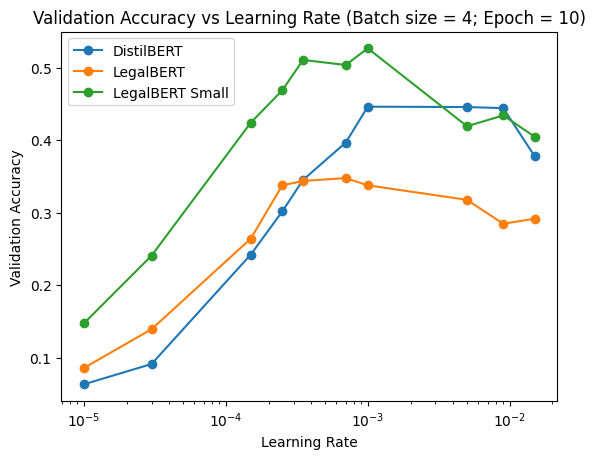

In [ ]:
# subset to only those rows with epoch = 10 and batch size = 4
baseline_learningrate_df = baseline_hyperparameters_df[(baseline_hyperparameters_df['Epoch'] == 10) & (baseline_hyperparameters_df['Batch_size'] == 4)]

# plot three lines with learning rate on the x-axis, validation accuracy on the y-axis, and each line representing each model
# Iterate through each model and plot
for model in baseline_learningrate_df['Model'].unique():
    subset = baseline_learningrate_df[baseline_learningrate_df['Model'] == model]
    plt.plot(subset['Learning_Rate'], subset['Validation_Accuracy'], marker='o', label=model)

# Adding labels, title, and legend
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate (Batch size = 4; Epoch = 10)')
plt.xscale('log')  # Use a logarithmic scale for learning rates
plt.legend()

# Save the plot as a PNG file
output_path = '/content/drive/MyDrive/6.8610/NLP Final Project/baseline_learningrate.png'  # Define the path
plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


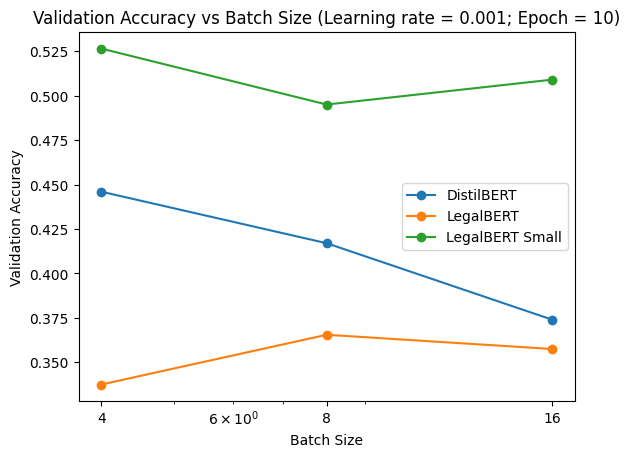

In [ ]:
# subset to only those rows with epoch = 10 and learning_rate = 0.001
baseline_batch_size_df = baseline_hyperparameters_df[(baseline_hyperparameters_df['Epoch'] == 10) & (baseline_hyperparameters_df['Learning_Rate'] == 0.001)]

# plot three lines with learning rate on the x-axis, validation accuracy on the y-axis, and each line representing each model
# Iterate through each model and plot
for model in baseline_batch_size_df['Model'].unique():
    subset = baseline_batch_size_df[baseline_batch_size_df['Model'] == model]
    plt.plot(subset['Batch_size'], subset['Validation_Accuracy'], marker='o', label=model)

# Adding labels, title, and legend
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Batch Size (Learning rate = 0.001; Epoch = 10)')
plt.xscale('log')  # Use a logarithmic scale for learning rates
plt.xticks([4, 8, 16], ["4", "8", "16"])
plt.legend()

# Save the plot as a PNG file
output_path = '/content/drive/MyDrive/6.8610/NLP Final Project/baseline_batch_size.png'  # Define the path
plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()